# Сбор данных

## Собираем данные с помощью парсинга с сайта Spotify. Выбор пал на 6 из 10 самых популярных жанров музыки(по опросам за последний месяц в мире): hip_hop, kpop, indian, metal, classical, blues.

In [2]:
!pip install spotipy
!pip install catboost
!pip install pydot
!pip install graphviz
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import StandardScaler
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
import joblib
import os
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import tensorflow as tf
from tensorflow.keras.utils import to_categoricalч

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 16.1 MB/s eta 0:00:00


In [ ]:
client_id = 'e24a34a39a8d452d872989b36d49ab10' # Для получения нужно зарегестрироваться на Spotify
client_secret = '59ef5b99ccea4ea8956b12decf0bf3b7' # Для получения нужно зарегестрироваться на Spotify

auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [ ]:
# Функция для сбора id треков в Spotify
def collect_tracks(query, max_tracks=5000):
    track_ids = set()
    offset = 0
    try:
        while len(track_ids) < max_tracks:
            results = sp.search(q=query, type='track', limit=50, offset=offset)
            tracks = results['tracks']['items']
            if not tracks:
                break
            for track in tracks:
                track_ids.add(track['id'])
                if len(track_ids) >= max_tracks:
                    break
            offset += 50
    except Exception as e:
        print(f"An error occurred: {e}")
    return track_ids

In [ ]:
# Жанр хип хопа
queries = ['hip-hop', 'rap', 'hip hop hits', '2024 hip hop']
all_tracks_hip_hop = set()

for query in queries:
    all_tracks_hip_hop.update(collect_tracks(query))
    if len(all_tracks_hip_hop) >= 5000:
        break

# Жанр metal
queries = ['metal', 'heavy metal', 'death metal', 'metalcore']
all_tracks_metal = set()

for query in queries:
    all_tracks_metal.update(collect_tracks(query))
    if len(all_tracks_metal) >= 5000:
        break

# Жанр классическая музыка
queries_classical = ['classical', 'baroque', 'opera', 'symphony']
all_tracks_classical = set()

for query in queries_classical:
    all_tracks_classical.update(collect_tracks(query))
    if len(all_tracks_classical) >= 5000:
        break

# Жанр blues
queries_blues = ['blues', 'chicago blues', 'delta blues', 'country blues']
all_tracks_blues = set()

for query in queries_blues:
    all_tracks_blues.update(collect_tracks(query))
    if len(all_tracks_blues) >= 5000:
        break

# Жанр k-pop
queries_kpop = ['k-pop', 'korean pop', 'kpop idol', 'kpop dance']
all_tracks_kpop = set()

for query in queries_kpop:
    all_tracks_kpop.update(collect_tracks(query))
    if len(all_tracks_kpop) >= 5000:
        break

# Жанр индийской музыки
queries = ['Bollywood', 'Indian classical', 'Bhangra', 'Indian pop']
all_tracks_indian_music = set()

for query in queries:
    all_tracks_indian_music.update(collect_tracks(query))
    if len(all_tracks_indian_music) >= 5000:
        break

## Объединяем все полученные id треков в один датасет, для последующего получения характеристик

In [ ]:
tracks_data = []

def add_genre_track(track_set, genre):
    for track_id in track_set:
        tracks_data.append((track_id, genre))

add_genre_track(all_tracks_kpop, 'kpop')
add_genre_track(all_tracks_blues, 'blues')
add_genre_track(all_tracks_metal, 'metal')
add_genre_track(all_tracks_indian_music, 'indian')
add_genre_track(all_tracks_hip_hop, 'hip_hop')
add_genre_track(all_tracks_classical, 'classical')


df_tracks = pd.DataFrame(tracks_data, columns=['track_id', 'genre_track'])

df_tracks = df_tracks.drop_duplicates(subset='track_id')

df_tracks['duration_ms'] = np.nan
df_tracks['explicit'] = np.nan
df_tracks['danceability'] = np.nan
df_tracks['energy'] = np.nan
df_tracks['key'] = np.nan
df_tracks['loudness'] = np.nan
df_tracks['mode'] = np.nan
df_tracks['speechiness'] = np.nan
df_tracks['acousticness'] = np.nan
df_tracks['instrumentalness'] = np.nan
df_tracks['liveness'] = np.nan
df_tracks['valence'] = np.nan
df_tracks['tempo'] = np.nan
df_tracks['time_signature'] = np.nan

df_tracks.to_csv('music_data.csv', index=False)

In [15]:
df_tracks = pd.read_csv('music_data.csv').drop(columns=['Unnamed: 0'], axis=1)
df_tracks

track_id genre_track  duration_ms  explicit  \
0      162MHwMBYufdE5jyoRobTo        kpop          NaN       NaN   
1      517RaXryInkI9MstFWUDkz        kpop          NaN       NaN   
2      0nvFEQ9DrRrj8wYZfIsSm7        kpop          NaN       NaN   
3      4sg4n7YCHA013vqSzY6t6t        kpop          NaN       NaN   
4      2dOO2z1VZF9bNHoLkG5qEw        kpop          NaN       NaN   
...                       ...         ...          ...       ...   
22435  0D7cOLQsjXY9jPkunN84JC      indian          NaN       NaN   
22436  0mftTi05eeOQnZ178jZruN      indian          NaN       NaN   
22437  74klMBiApXASzNAboLR5Xu      indian          NaN       NaN   
22438  7Gn1H85ok0b2eXYwfgw8C0      indian          NaN       NaN   
22439  5S53GEeJbsii8Idew95Wrg      indian          NaN       NaN   

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
0               NaN     NaN  NaN       NaN   NaN          NaN           NaN   
1               NaN     NaN  NaN       NaN   NaN          NaN           NaN   
2               NaN     NaN  NaN       NaN   NaN          NaN           NaN   
3               NaN     NaN  NaN       NaN   NaN          NaN           NaN   
4               NaN     NaN  NaN       NaN   NaN          NaN           NaN   
...             ...     ...  ...       ...   ...          ...           ...   
22435           NaN     NaN  NaN       NaN   NaN          NaN           NaN   
22436           NaN     NaN  NaN       NaN   NaN          NaN           NaN   
22437           NaN     NaN  NaN       NaN   NaN          NaN           NaN   
22438           NaN     NaN  NaN       NaN   NaN          NaN           NaN   
22439           NaN     NaN  NaN       NaN   NaN          NaN           NaN   

       instrumentalness  liveness  valence  tempo  time_signature  
0                   NaN       NaN      NaN    NaN             NaN  
1                   NaN       NaN      NaN    NaN             NaN  
2                   NaN       NaN      NaN    NaN             NaN  
3                   NaN       NaN      NaN    NaN             NaN  
4                   NaN       NaN      NaN    NaN             NaN  
...                 ...       ...      ...    ...             ...  
22435               NaN       NaN      NaN    NaN             NaN  
22436               NaN       NaN      NaN    NaN             NaN  
22437               NaN       NaN      NaN    NaN             NaN  
22438               NaN       NaN      NaN    NaN             NaN  
22439               NaN       NaN      NaN    NaN             NaN  

[22440 rows x 16 columns]

Была создана таблица с id треков и их жанрами.
Теперь будут получены характеристики песен.

In [ ]:
for i in range(len(df_tracks)):

    track_id = df_tracks['track_id'][i]

    try:
        track_data = sp.track(track_id)
        track_features = sp.audio_features(track_id)[0]

        # Проверка на None
        if track_features is None:
            print(f"No features found for track {track_id}. Skipping.")
            continue

        # Заполнение датафрейма данными
        df_tracks.at[i, 'duration_ms'] = track_data['duration_ms']
        df_tracks.at[i, 'explicit'] = track_data['explicit']

        df_tracks.at[i, 'danceability'] = track_features['danceability']
        df_tracks.at[i, 'energy'] = track_features['energy']
        df_tracks.at[i, 'key'] = track_features['key']
        df_tracks.at[i, 'loudness'] = track_features['loudness']
        df_tracks.at[i, 'mode'] = track_features['mode']
        df_tracks.at[i, 'speechiness'] = track_features['speechiness']
        df_tracks.at[i, 'acousticness'] = track_features['acousticness']
        df_tracks.at[i, 'instrumentalness'] = track_features['instrumentalness']
        df_tracks.at[i, 'liveness'] = track_features['liveness']
        df_tracks.at[i, 'valence'] = track_features['valence']
        df_tracks.at[i, 'tempo'] = track_features['tempo']
        df_tracks.at[i, 'time_signature'] = track_features['time_signature']


    except spotipy.SpotifyException as e:
        if e.http_status == 429:
            retry_after = int(e.headers['Retry-After']) if 'Retry-After' in e.headers else 10
            print(f"Rate limit exceeded. Retrying after {retry_after} seconds.")
            time.sleep(retry_after)
            continue
        raise

    df_tracks.to_csv('final_data.csv')

    time.sleep(2)

In [15]:
data = pd.read_csv('final_data.csv')
data

track_id genre_track  duration_ms  explicit  \
0      162MHwMBYufdE5jyoRobTo        kpop     228880.0     False   
1      517RaXryInkI9MstFWUDkz        kpop     190512.0     False   
2      0nvFEQ9DrRrj8wYZfIsSm7        kpop      35236.0     False   
3      4sg4n7YCHA013vqSzY6t6t        kpop     182000.0     False   
4      2dOO2z1VZF9bNHoLkG5qEw        kpop     219506.0     False   
...                       ...         ...          ...       ...   
22435  0D7cOLQsjXY9jPkunN84JC      indian     279773.0     False   
22436  0mftTi05eeOQnZ178jZruN      indian     300520.0     False   
22437  74klMBiApXASzNAboLR5Xu      indian     234000.0     False   
22438  7Gn1H85ok0b2eXYwfgw8C0      indian     179266.0     False   
22439  5S53GEeJbsii8Idew95Wrg      indian    1799131.0     False   

       danceability  energy   key  loudness  mode  speechiness  acousticness  \
0             0.885  0.9420   1.0    -0.548   0.0       0.0798        0.1770   
1             0.331  0.5320   1.0    -5.119   1.0       0.0416        0.5780   
2             0.748  0.5010   7.0   -12.613   1.0       0.0593        0.0313   
3             0.627  0.8650   5.0    -4.241   1.0       0.0457        0.0025   
4             0.703  0.7870   6.0    -5.058   1.0       0.6290        0.2340   
...             ...     ...   ...       ...   ...          ...           ...   
22435         0.200  0.2270  10.0   -16.243   0.0       0.0375        0.9120   
22436         0.648  0.5350  10.0   -10.505   1.0       0.0561        0.3650   
22437         0.118  0.0602   6.0   -27.248   0.0       0.0432        0.9860   
22438         0.200  0.1330   6.0   -21.504   1.0       0.0407        0.8560   
22439         0.442  0.3610  11.0   -15.399   1.0       0.0598        0.9750   

       instrumentalness  liveness  valence    tempo  time_signature  
0                 0.000    0.1150   0.9370  114.994             4.0  
1                 0.000    0.1130   0.0412  134.929             4.0  
2                 0.263    0.1410   0.7080  109.010             4.0  
3                 0.000    0.3620   0.3600  106.093             4.0  
4                 0.000    0.4080   0.6620  104.776             4.0  
...                 ...       ...      ...      ...             ...  
22435             0.757    0.3300   0.0681  117.764             1.0  
22436             0.000    0.0779   0.6650  111.974             4.0  
22437             0.952    0.0996   0.2010   66.830             4.0  
22438             0.893    0.3450   0.0383  119.165             1.0  
22439             0.751    0.6910   0.1280  101.801             4.0  

[22440 rows x 16 columns]

Был получен датасет, будем работать с ним

# Предобработка данных

In [16]:
has_duplicates = data.duplicated().any()

print("Есть дубликаты в датасете:", has_duplicates)

Есть дубликаты в датасете: False


In [17]:
data = data.dropna()
data.shape

(22440, 16)

In [18]:
data['genre_track'].value_counts()

genre_track
indian       3854
classical    3834
metal        3796
blues        3765
kpop         3681
hip_hop      3510
Name: count, dtype: int64

# Аналитика
## Построим гистограммы распределения, ящики с усами и violin plot для каждого признака и смотрим как попарно они отличаются между жанрами

In [19]:
genres_data = {
    'Metal': data[data['genre_track'] == 'metal'],
    'Classical': data[data['genre_track'] == 'classical'],
    'K-Pop': data[data['genre_track'] == 'kpop'],
    'Hip-Hop': data[data['genre_track'] == 'hip_hop'],
    'Blues': data[data['genre_track'] == 'blues'],
    'Indian': data[data['genre_track'] == 'indian']
}

genre_pairs = list(itertools.combinations(genres_data.keys(), 2))

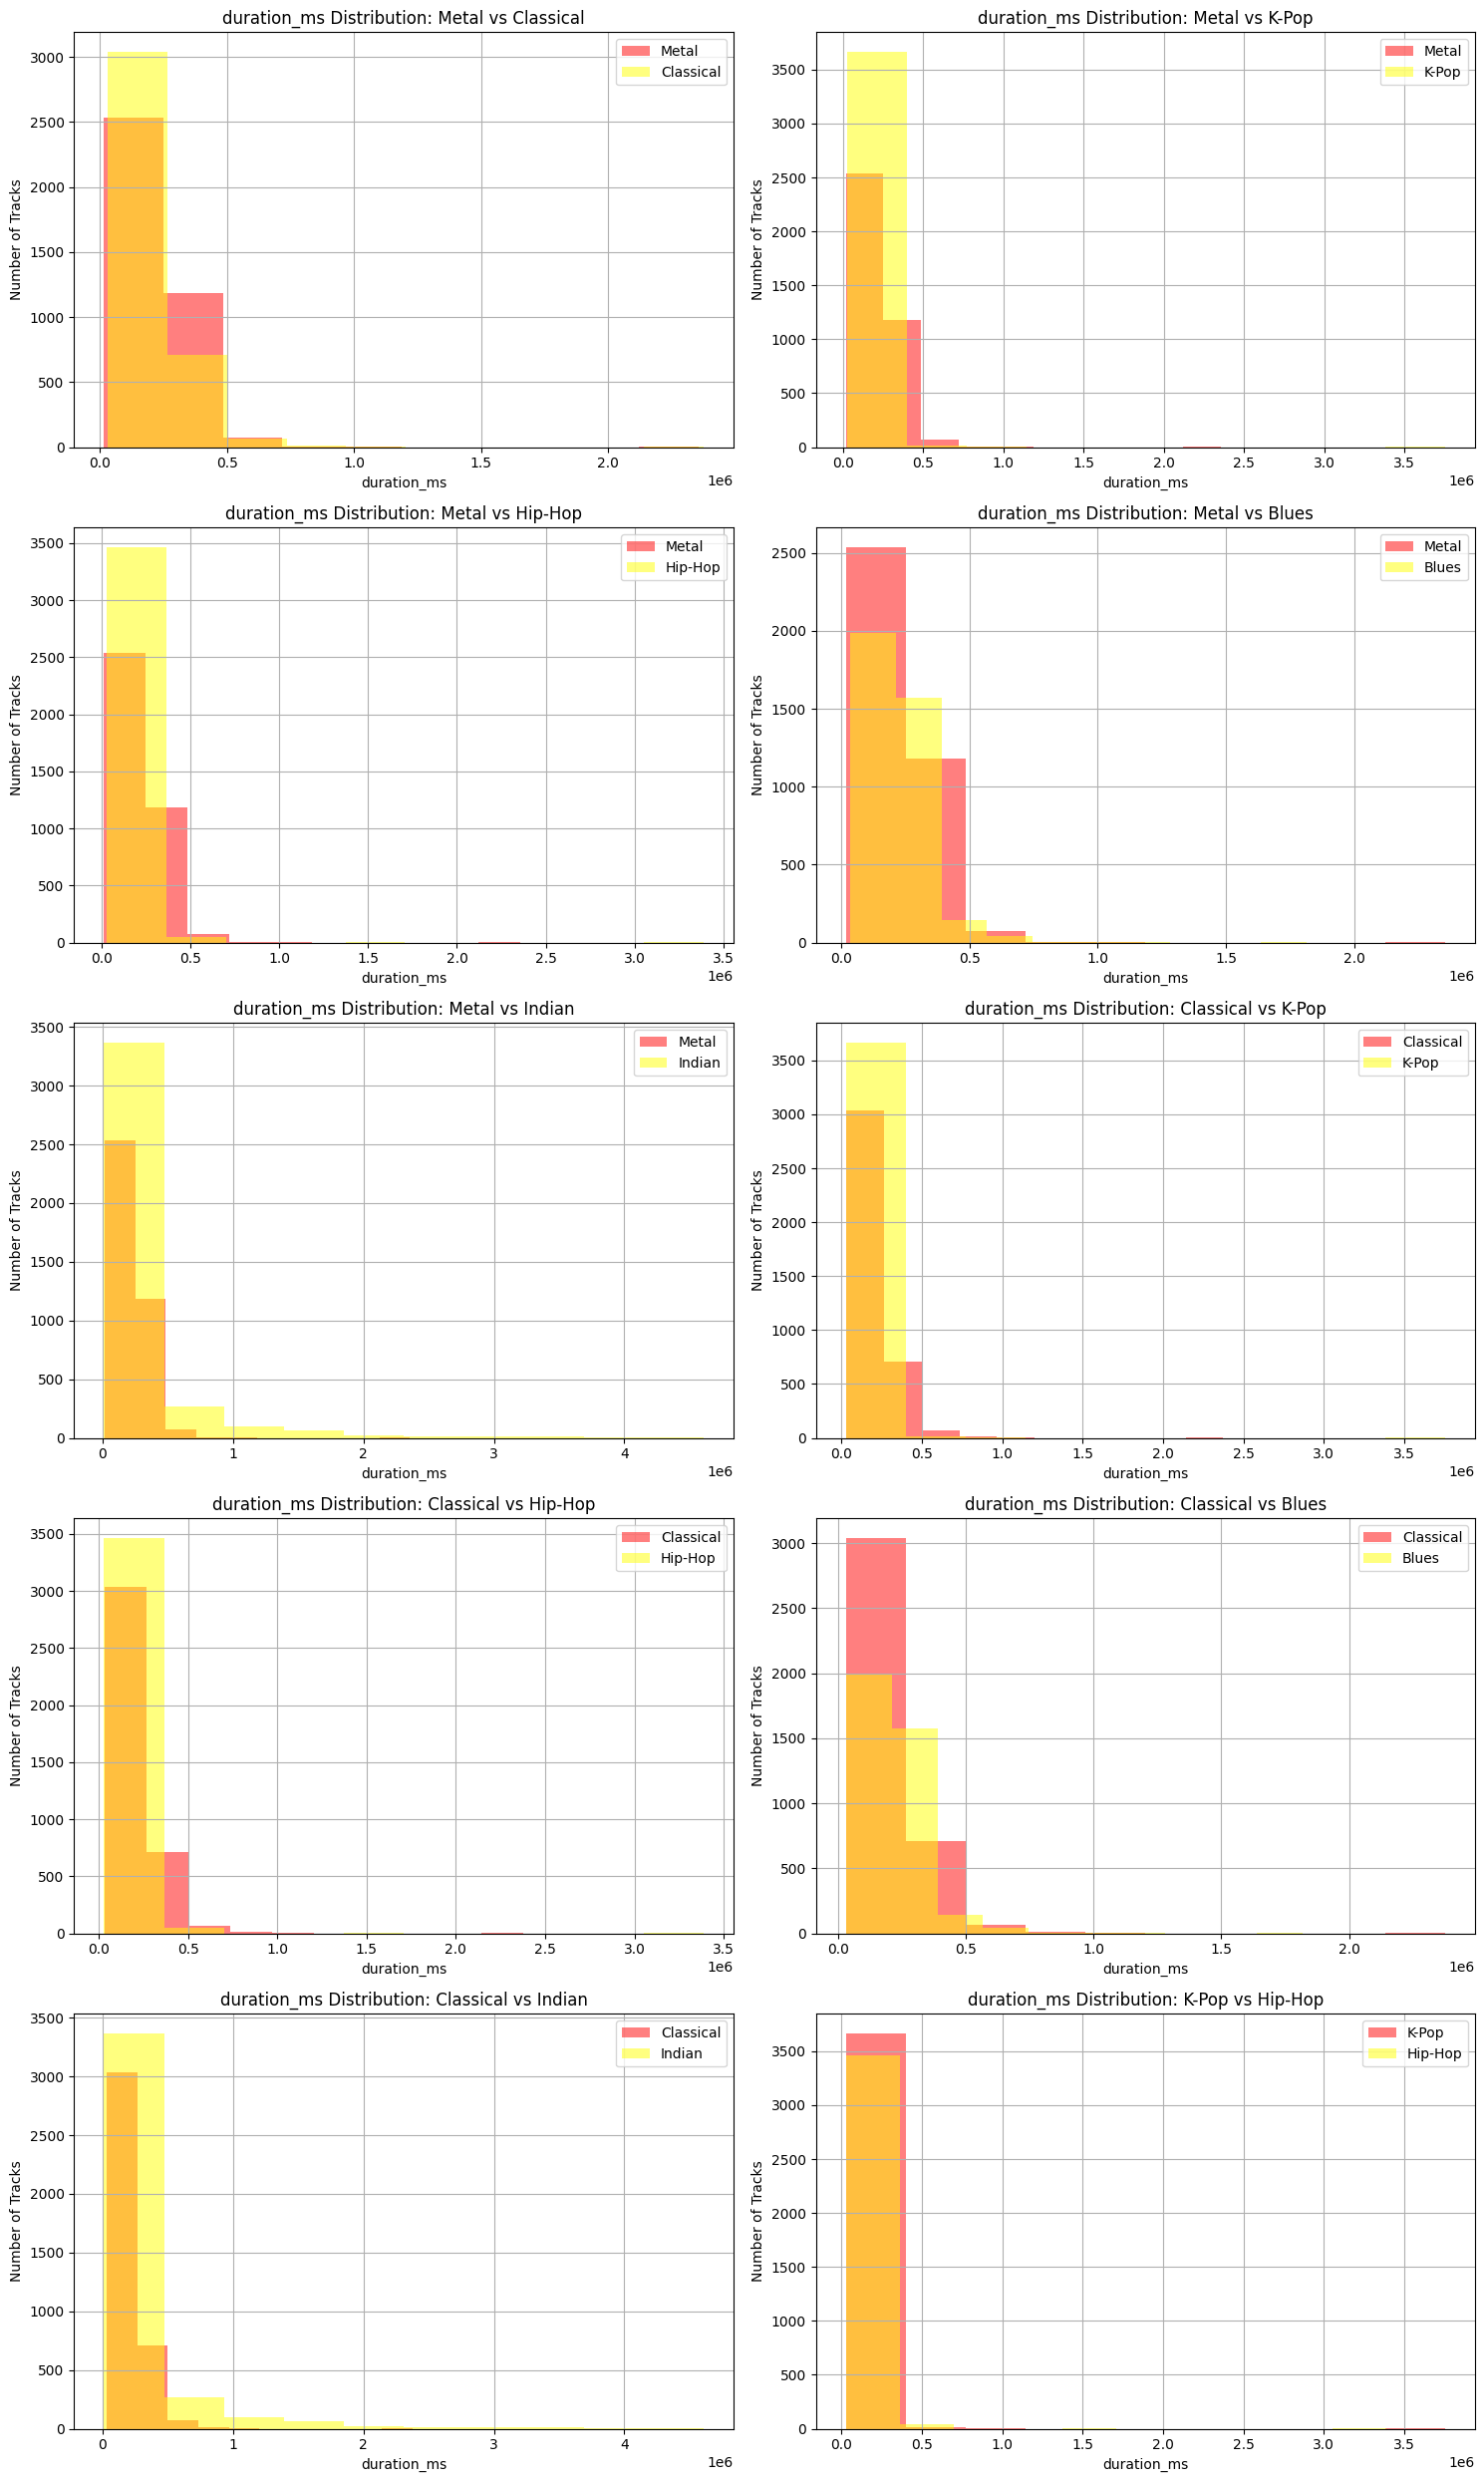

In [20]:
# duration_ms
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    ax.hist(genres_data[genre1]['duration_ms'], bins=10, alpha=0.5, label=genre1, color='red')
    ax.hist(genres_data[genre2]['duration_ms'], bins=10, alpha=0.5, label=genre2, color='yellow')
    ax.set_title(f'duration_ms Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('duration_ms')
    ax.set_ylabel('Number of Tracks')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

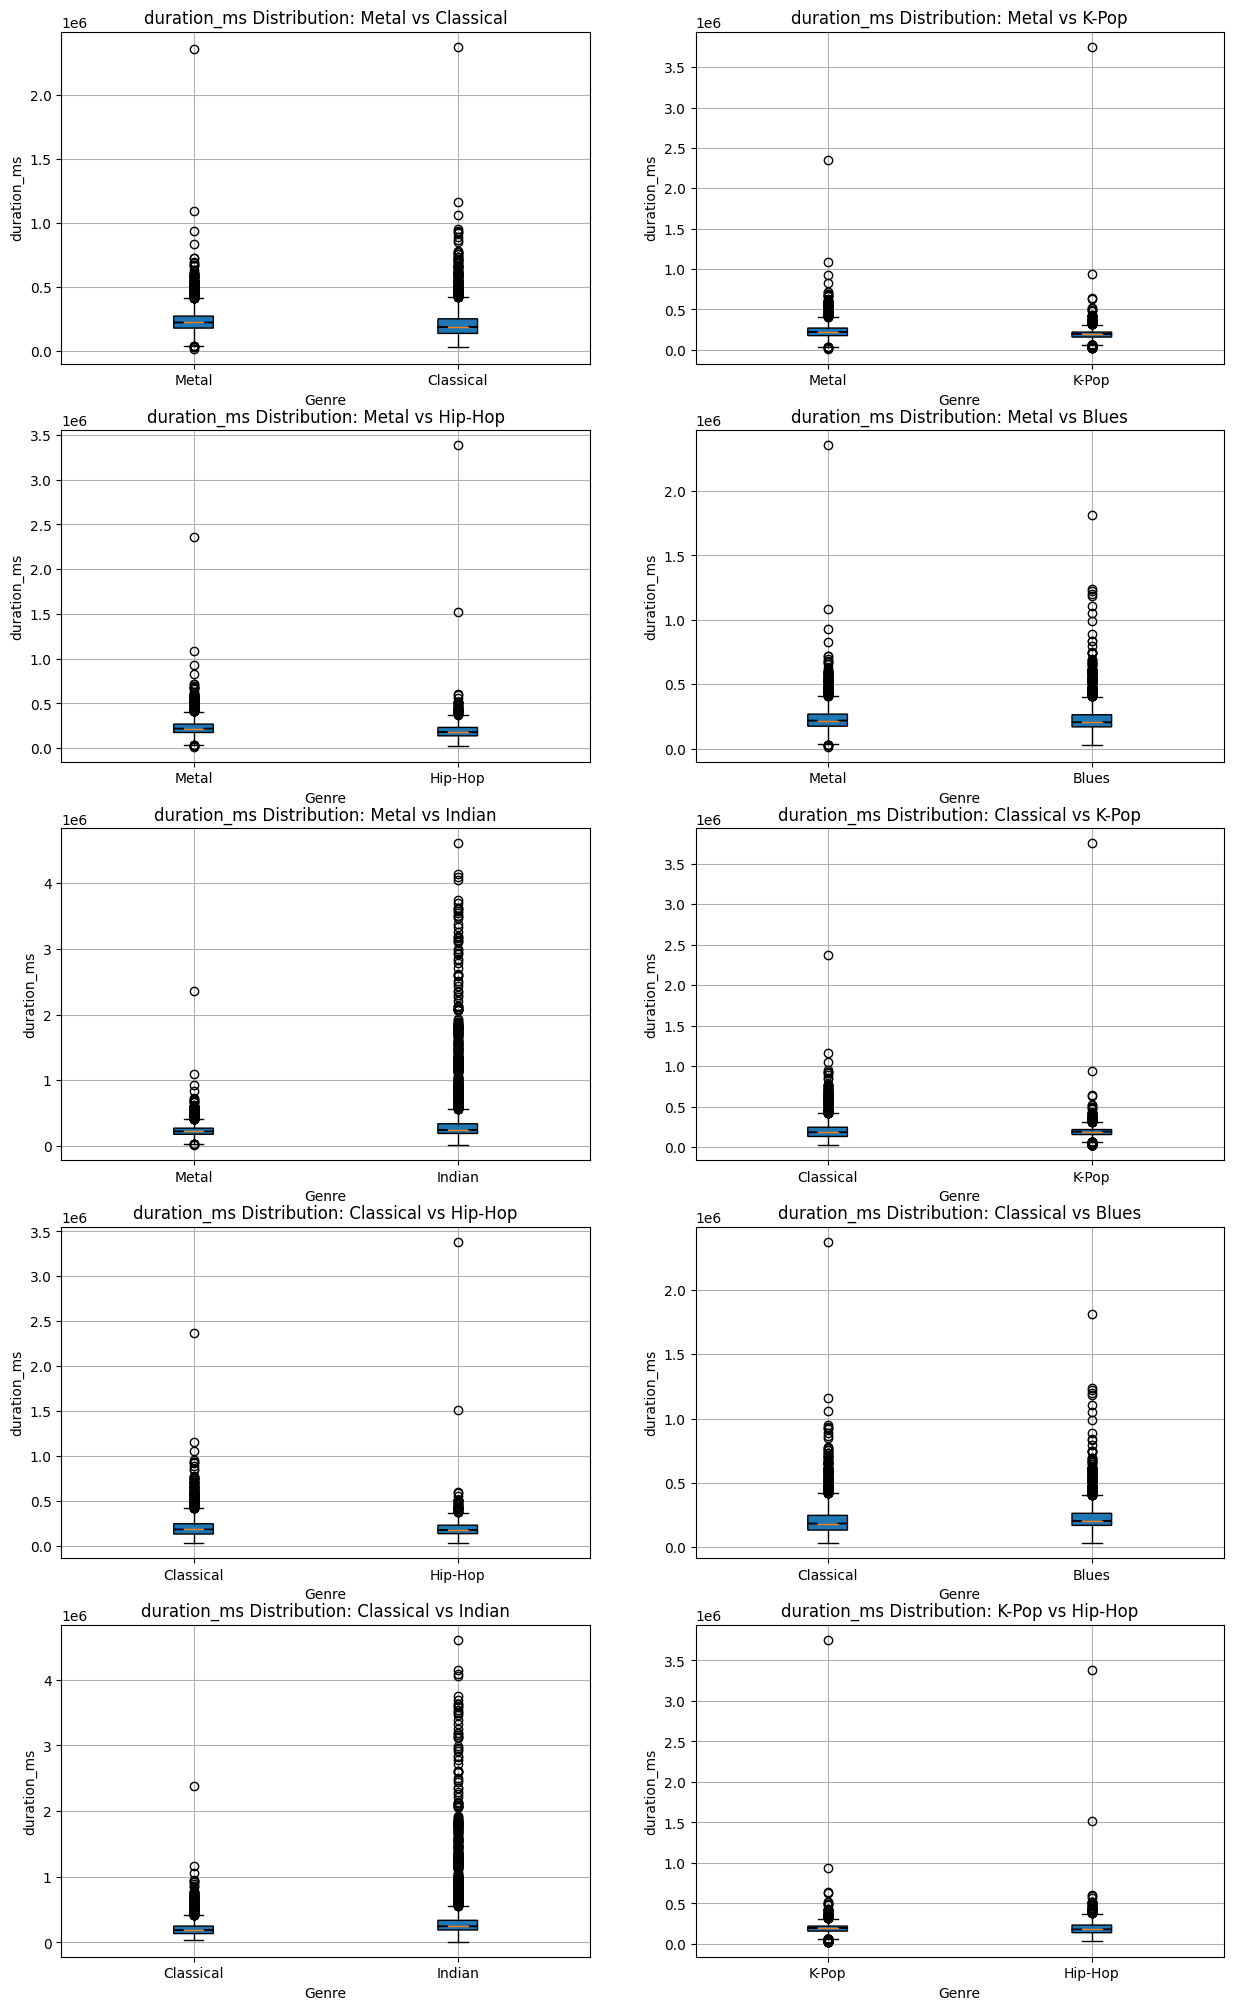

In [21]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    data_to_plot = [genres_data[genre1]['duration_ms'], genres_data[genre2]['duration_ms']]
    ax.boxplot(data_to_plot, labels=[genre1, genre2], notch=True, patch_artist=True)
    ax.set_title(f'duration_ms Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('Genre')
    ax.set_ylabel('duration_ms')
    ax.grid(True)

In [20]:
data

track_id genre_track  duration_ms  explicit  \
0      162MHwMBYufdE5jyoRobTo        kpop     228880.0     False   
1      517RaXryInkI9MstFWUDkz        kpop     190512.0     False   
2      0nvFEQ9DrRrj8wYZfIsSm7        kpop      35236.0     False   
3      4sg4n7YCHA013vqSzY6t6t        kpop     182000.0     False   
4      2dOO2z1VZF9bNHoLkG5qEw        kpop     219506.0     False   
...                       ...         ...          ...       ...   
22435  0D7cOLQsjXY9jPkunN84JC      indian     279773.0     False   
22436  0mftTi05eeOQnZ178jZruN      indian     300520.0     False   
22437  74klMBiApXASzNAboLR5Xu      indian     234000.0     False   
22438  7Gn1H85ok0b2eXYwfgw8C0      indian     179266.0     False   
22439  5S53GEeJbsii8Idew95Wrg      indian    1799131.0     False   

       danceability  energy   key  loudness  mode  speechiness  acousticness  \
0             0.885  0.9420   1.0    -0.548   0.0       0.0798        0.1770   
1             0.331  0.5320   1.0    -5.119   1.0       0.0416        0.5780   
2             0.748  0.5010   7.0   -12.613   1.0       0.0593        0.0313   
3             0.627  0.8650   5.0    -4.241   1.0       0.0457        0.0025   
4             0.703  0.7870   6.0    -5.058   1.0       0.6290        0.2340   
...             ...     ...   ...       ...   ...          ...           ...   
22435         0.200  0.2270  10.0   -16.243   0.0       0.0375        0.9120   
22436         0.648  0.5350  10.0   -10.505   1.0       0.0561        0.3650   
22437         0.118  0.0602   6.0   -27.248   0.0       0.0432        0.9860   
22438         0.200  0.1330   6.0   -21.504   1.0       0.0407        0.8560   
22439         0.442  0.3610  11.0   -15.399   1.0       0.0598        0.9750   

       instrumentalness  liveness  valence    tempo  time_signature  
0                 0.000    0.1150   0.9370  114.994             4.0  
1                 0.000    0.1130   0.0412  134.929             4.0  
2                 0.263    0.1410   0.7080  109.010             4.0  
3                 0.000    0.3620   0.3600  106.093             4.0  
4                 0.000    0.4080   0.6620  104.776             4.0  
...                 ...       ...      ...      ...             ...  
22435             0.757    0.3300   0.0681  117.764             1.0  
22436             0.000    0.0779   0.6650  111.974             4.0  
22437             0.952    0.0996   0.2010   66.830             4.0  
22438             0.893    0.3450   0.0383  119.165             1.0  
22439             0.751    0.6910   0.1280  101.801             4.0  

[22440 rows x 16 columns]

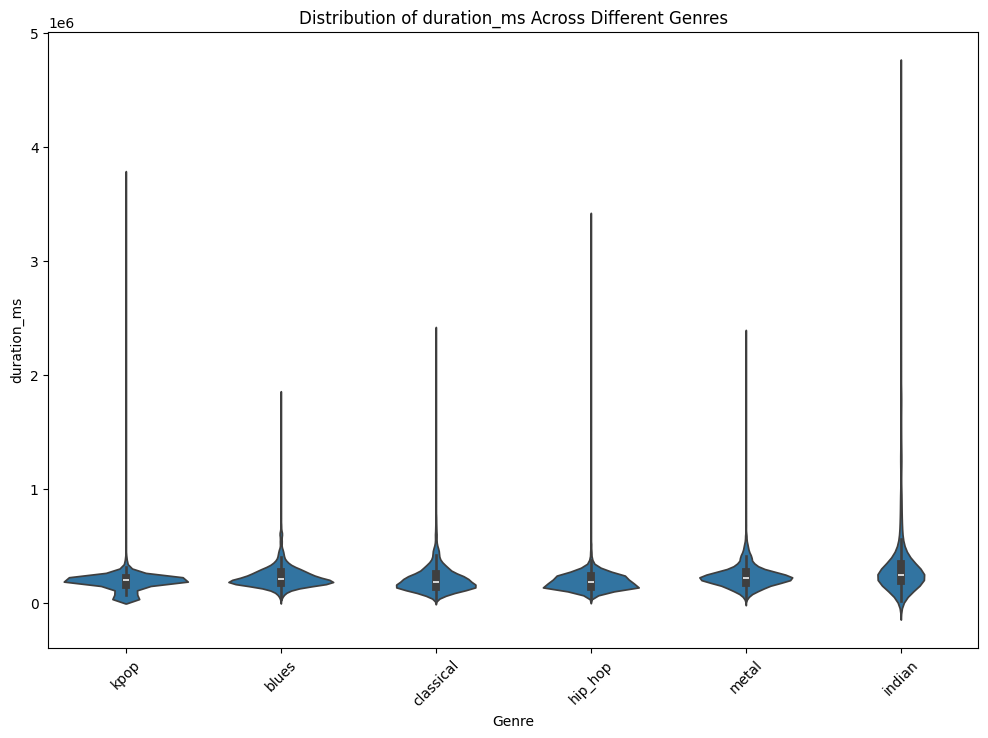

In [19]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='genre_track', y='duration_ms', data=data)
plt.title('Distribution of duration_ms Across Different Genres')
plt.xlabel('Genre')
plt.ylabel('duration_ms')
plt.xticks(rotation=45)
plt.show()

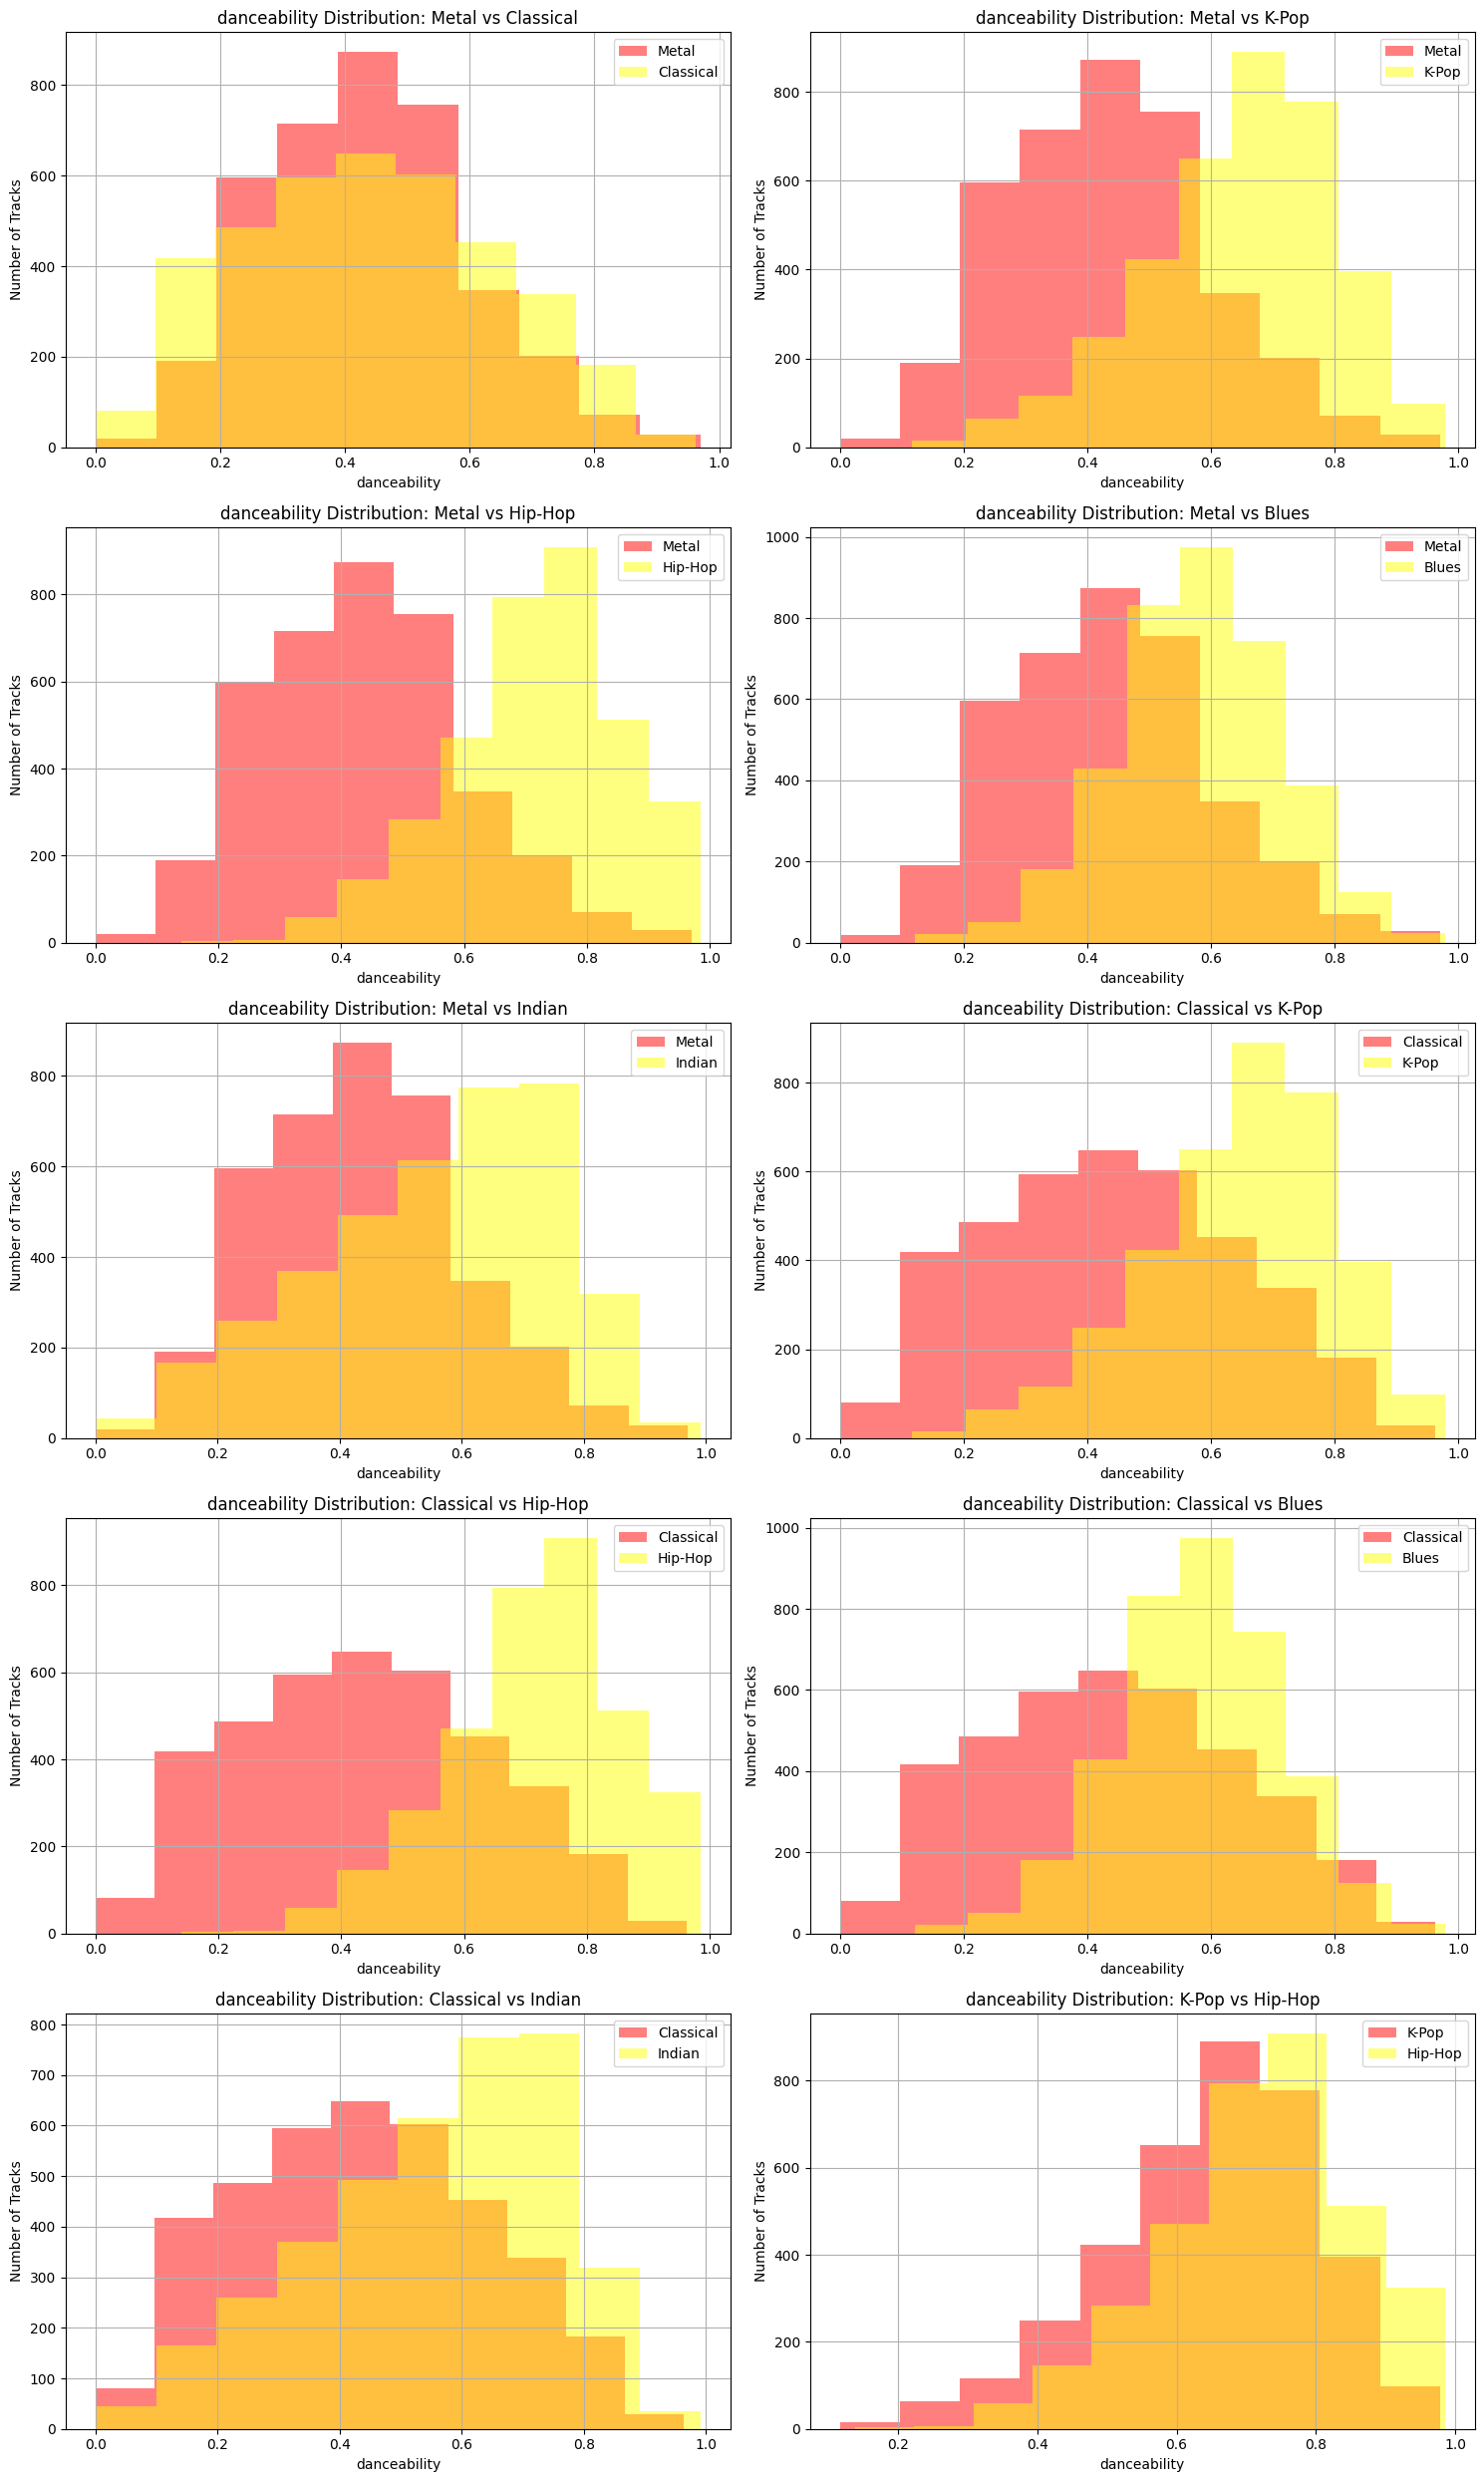

In [22]:
# danceability
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    ax.hist(genres_data[genre1]['danceability'], bins=10, alpha=0.5, label=genre1, color='red')
    ax.hist(genres_data[genre2]['danceability'], bins=10, alpha=0.5, label=genre2, color='yellow')
    ax.set_title(f'danceability Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('danceability')
    ax.set_ylabel('Number of Tracks')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

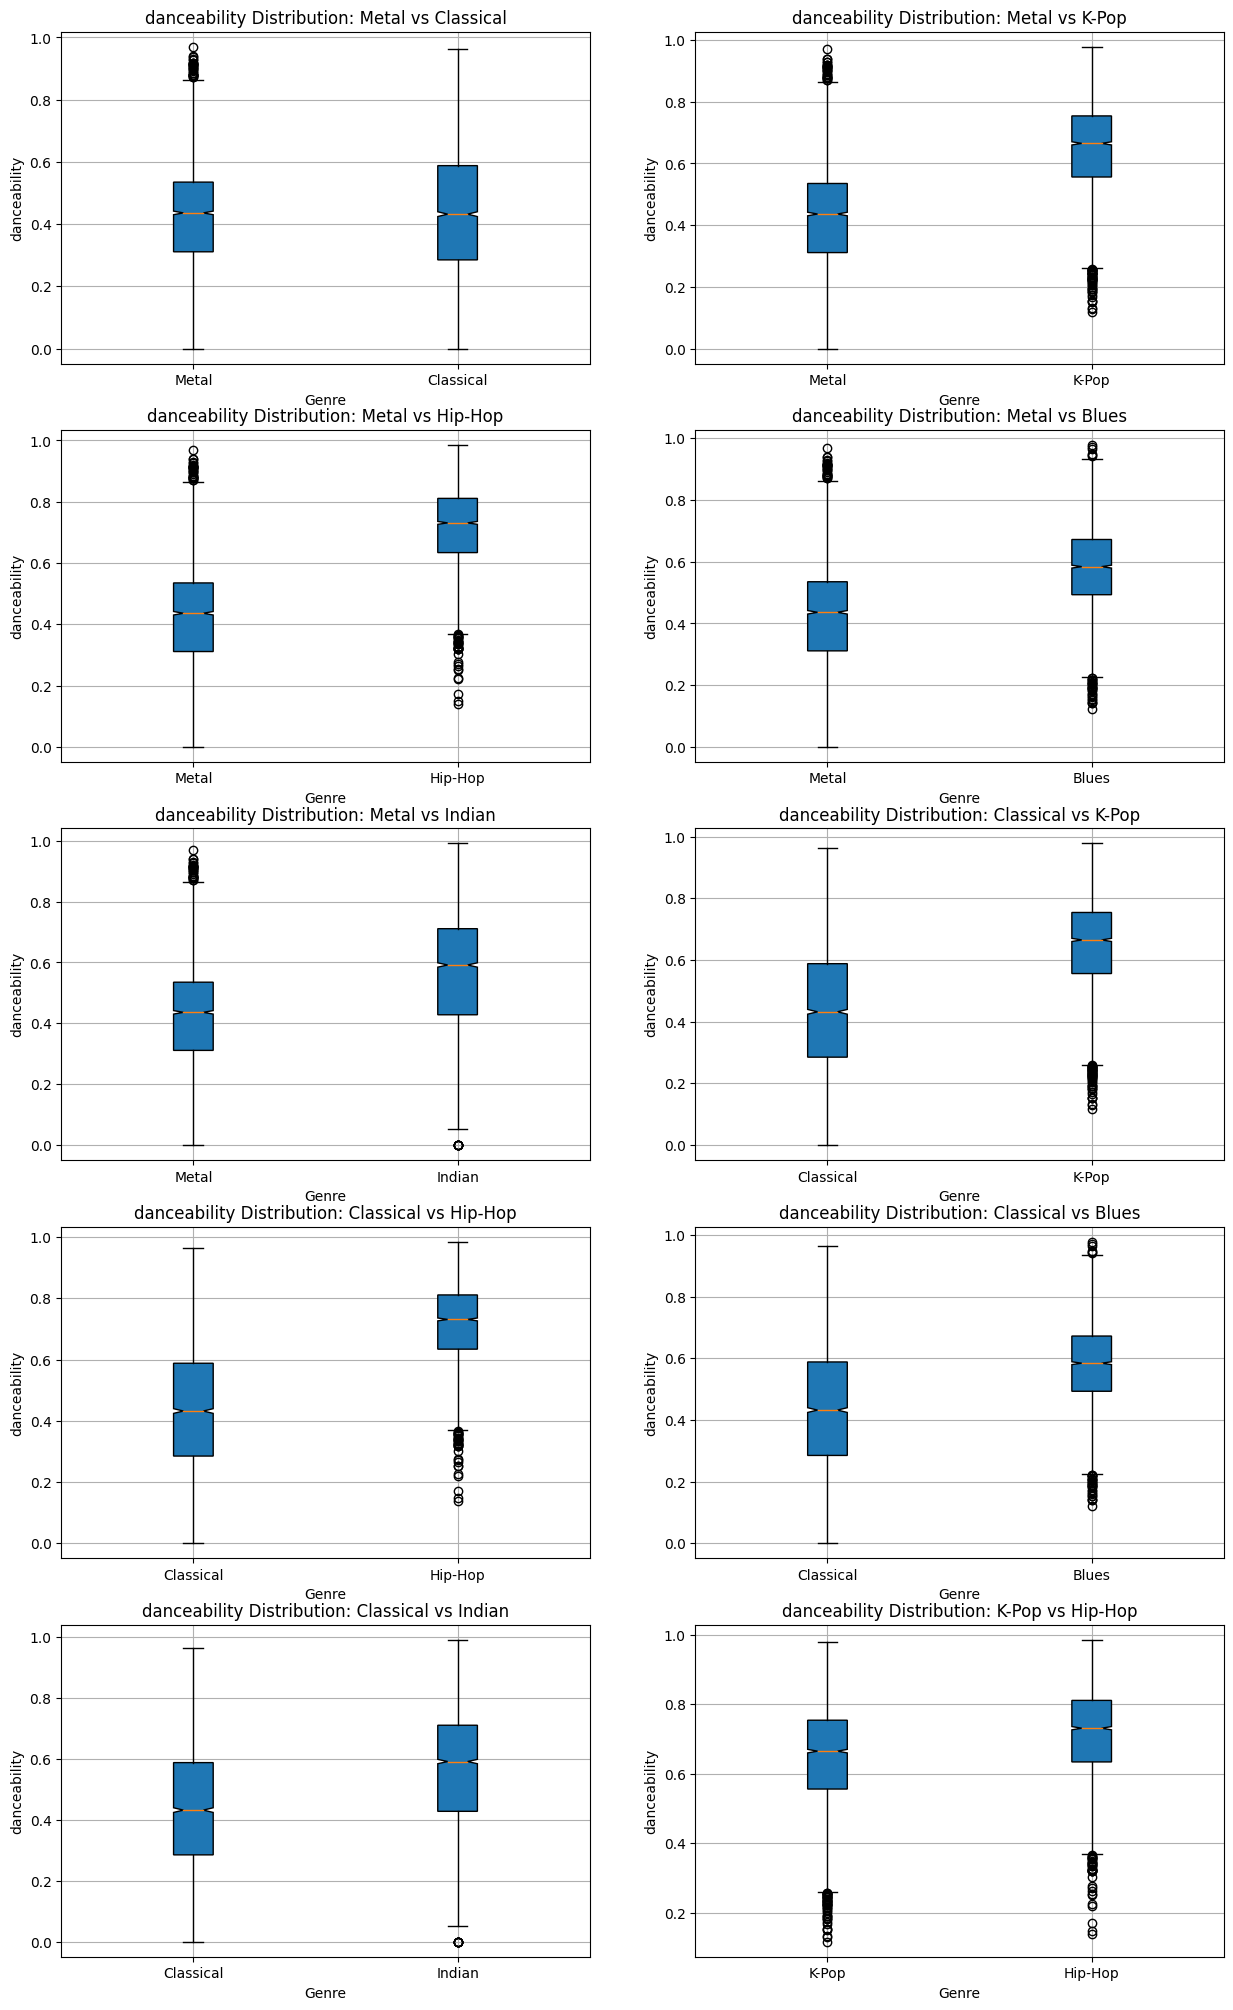

In [23]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    data_to_plot = [genres_data[genre1]['danceability'], genres_data[genre2]['danceability']]
    ax.boxplot(data_to_plot, labels=[genre1, genre2], notch=True, patch_artist=True)
    ax.set_title(f'danceability Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('Genre')
    ax.set_ylabel('danceability')
    ax.grid(True)

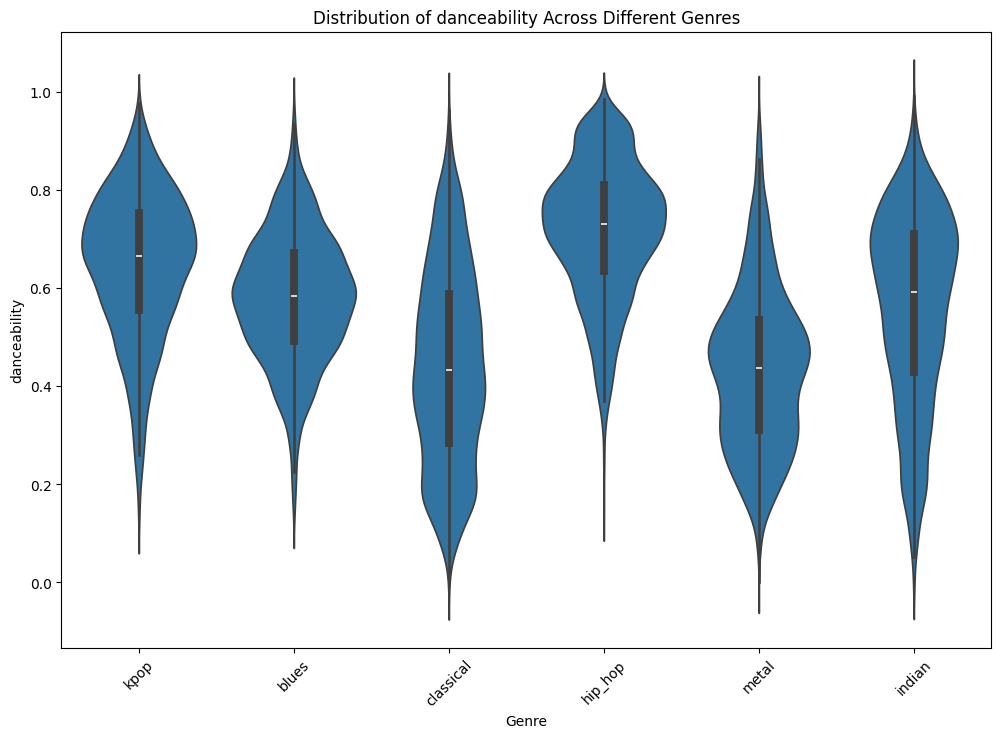

In [21]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='genre_track', y='danceability', data=data)
plt.title('Distribution of danceability Across Different Genres')
plt.xlabel('Genre')
plt.ylabel('danceability')
plt.xticks(rotation=45)
plt.show()

Жанры с высокой танцевальностью:

K-pop и Hip-Hop демонстрируют высокие значения танцевальности, что подчеркивает их ритмичность и популярность на танцполах. Эти жанры имеют более широкие распределения с медианами, приближенными к верхней границе диапазона, что указывает на то, что большинство треков в этих жанрах обладают высокой танцевальностью.
Жанры с низкой танцевальностью:

Classical (классическая музыка) имеет значительно более низкие значения танцевальности с узким распределением около более низкой границы. Это отражает тот факт, что классическая музыка обычно не предназначена для танцев.
Жанры со средней танцевальностью:

Жанры как Blues, Metal и Indian показывают более умеренные уровни танцевальности с широкими распределениями. Это указывает на то, что в этих жанрах существует значительное разнообразие между треками по их пригодности для танцев.
Blues и Indian демонстрируют средние значения танцевальности, но с разбросом, который показывает большой диапазон характеристик треков внутри жанров.
Симметрия и асимметрия распределений:

Большинство жанров показывают симметричные распределения, за исключением Indian, где видна легкая асимметрия с более длинным хвостом в сторону более высоких значений танцевальности.
Ширина скрипок:

Шире "скрипка", тем больше плотность треков с данным уровнем танцевальности. Например, к-pop и hip-hop показывают высокую плотность около своих медианных значений, что делает их очень предсказуемыми в плане танцевальности по сравнению с более изменчивыми жанрами, такими как metal.

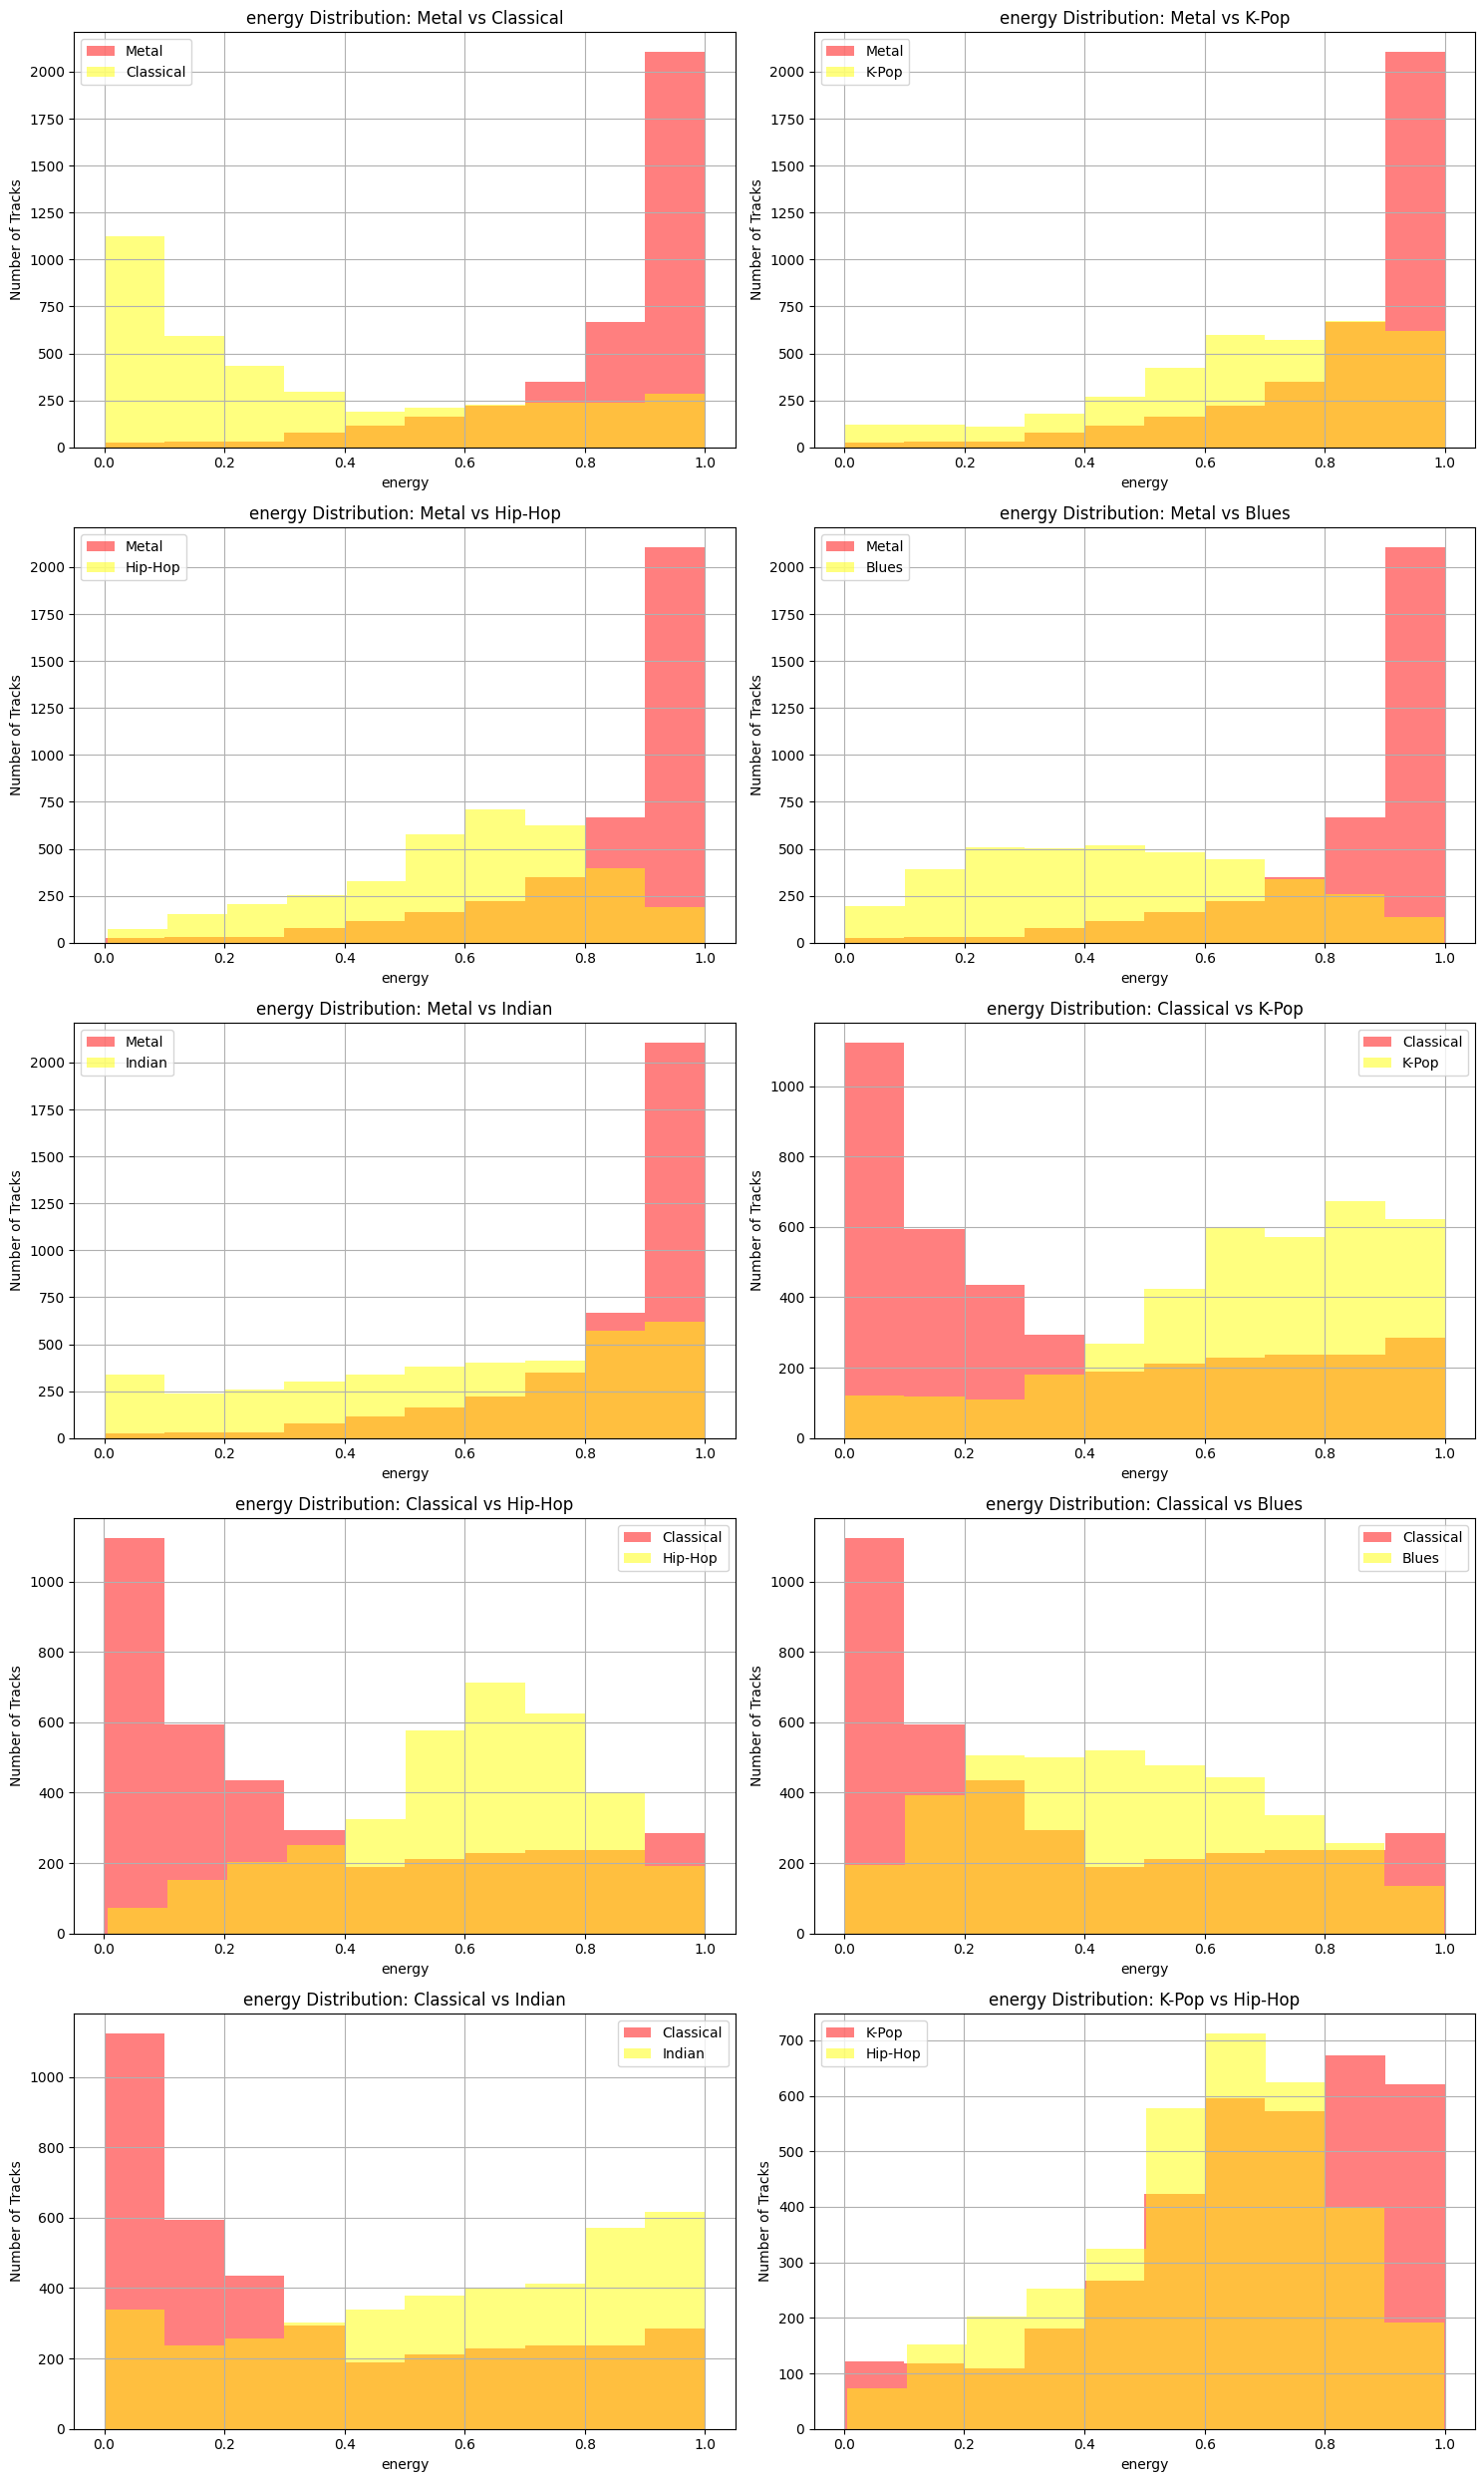

In [24]:
# energy
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    ax.hist(genres_data[genre1]['energy'], bins=10, alpha=0.5, label=genre1, color='red')
    ax.hist(genres_data[genre2]['energy'], bins=10, alpha=0.5, label=genre2, color='yellow')
    ax.set_title(f'energy Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('energy')
    ax.set_ylabel('Number of Tracks')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

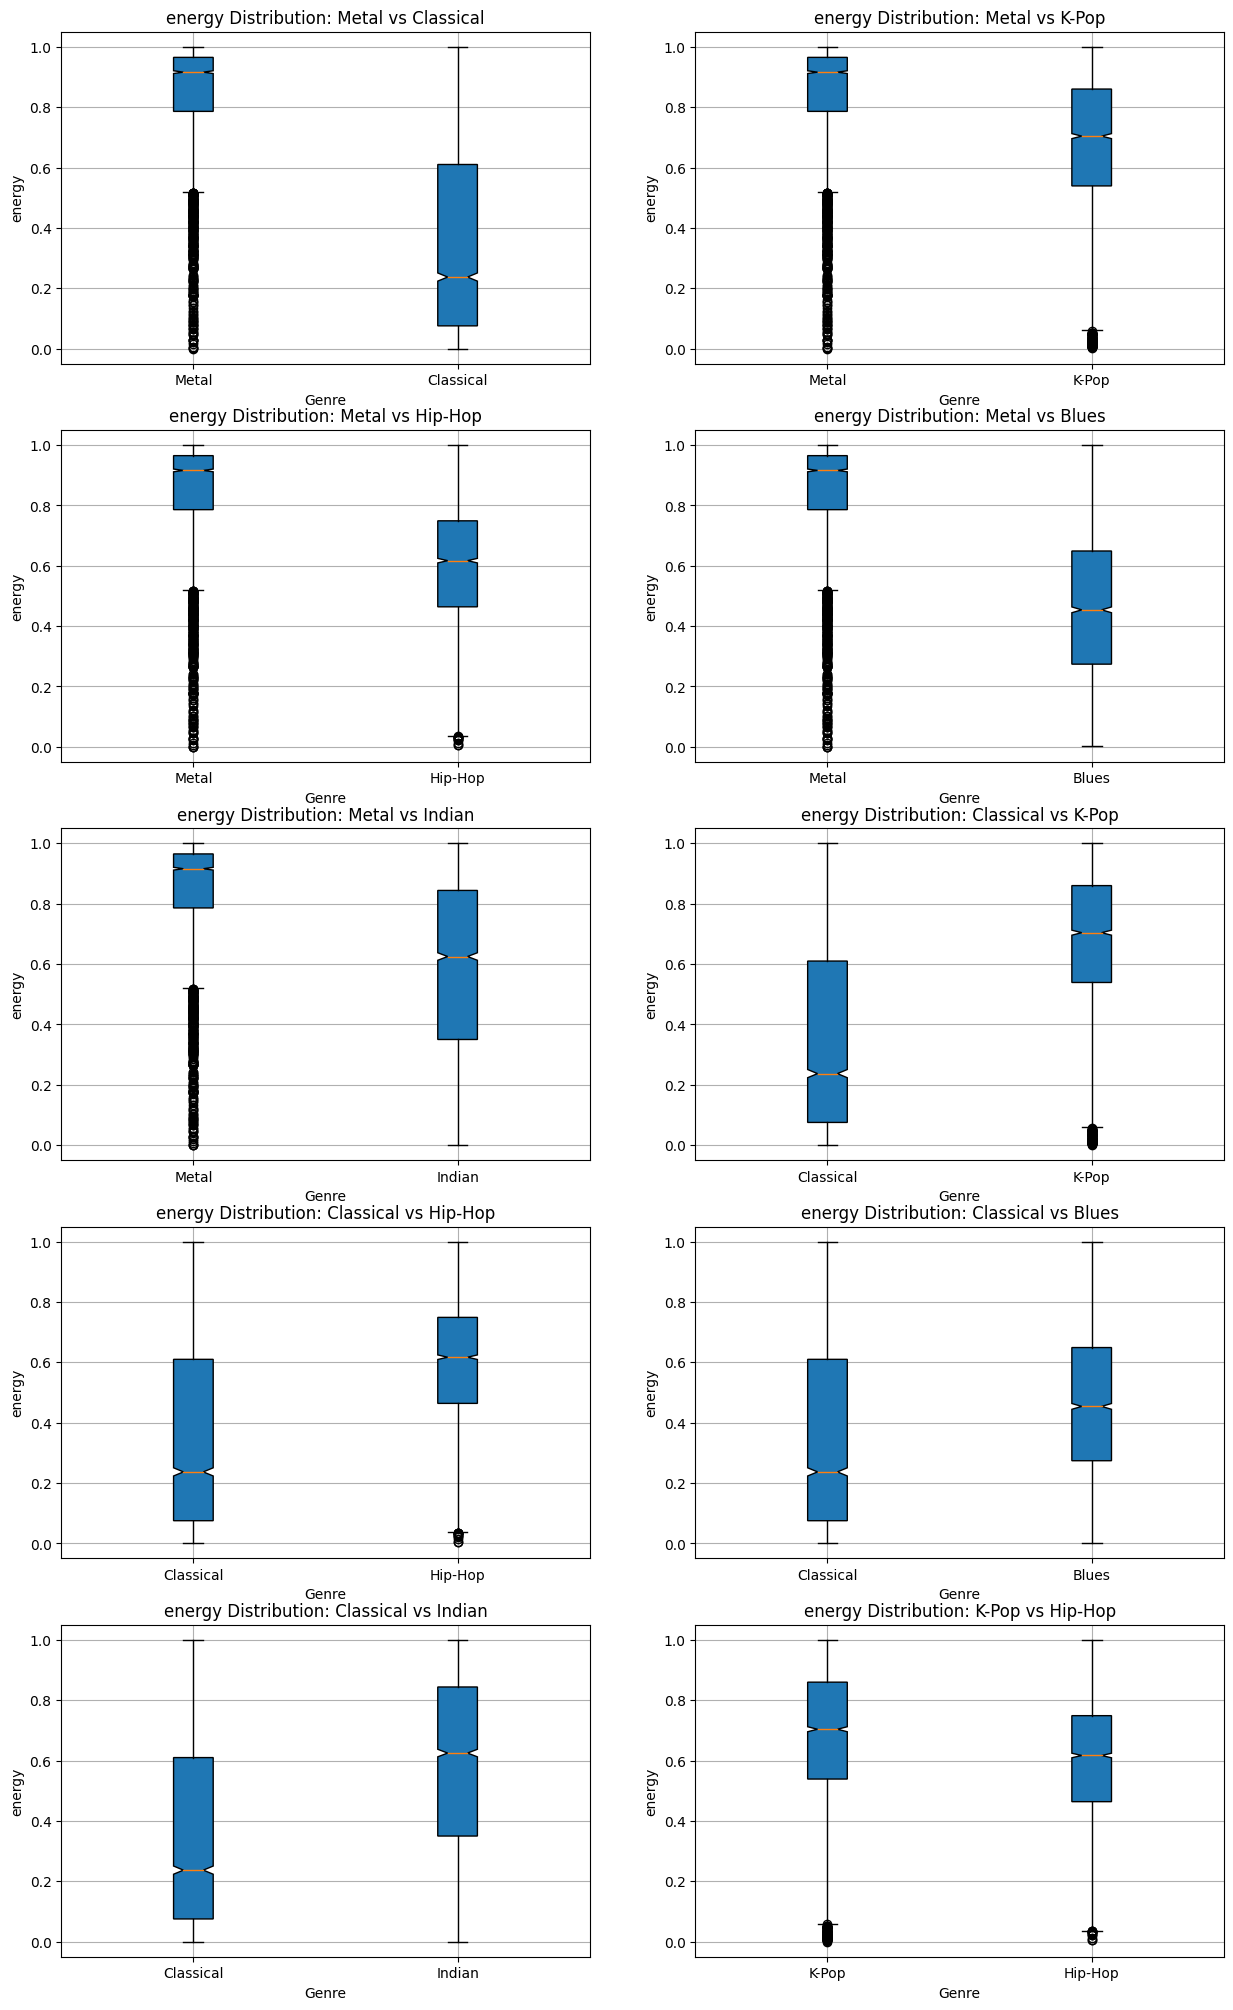

In [25]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    data_to_plot = [genres_data[genre1]['energy'], genres_data[genre2]['energy']]
    ax.boxplot(data_to_plot, labels=[genre1, genre2], notch=True, patch_artist=True)
    ax.set_title(f'energy Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('Genre')
    ax.set_ylabel('energy')
    ax.grid(True)

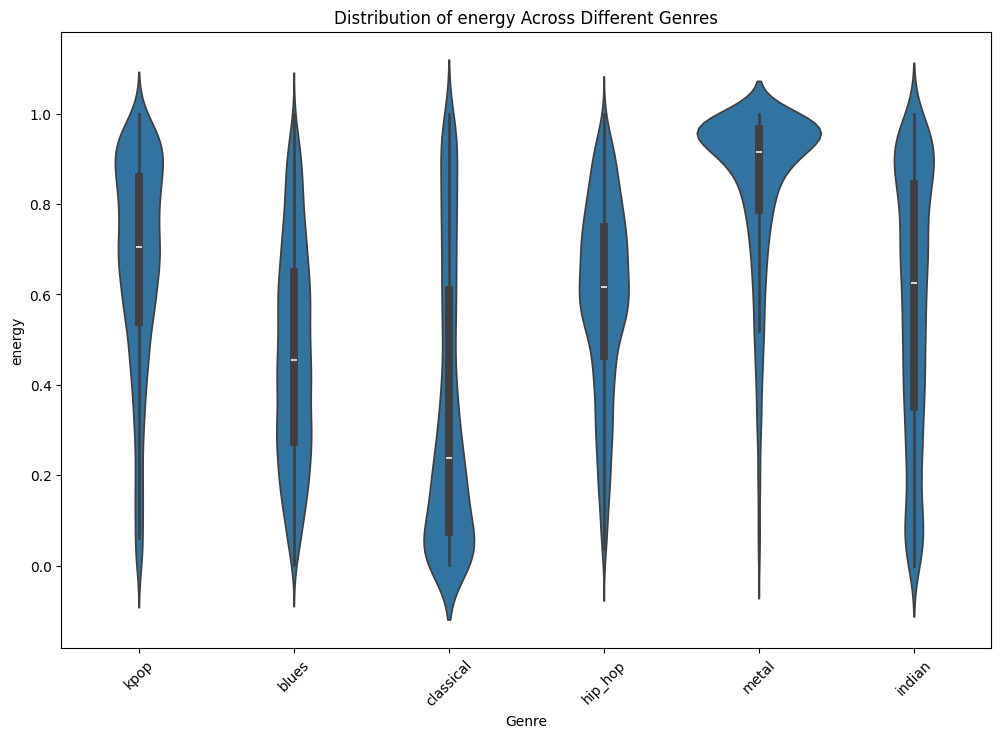

In [24]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='genre_track', y='energy', data=data)
plt.title('Distribution of energy Across Different Genres')
plt.xlabel('Genre')
plt.ylabel('energy')
plt.xticks(rotation=45)
plt.show()

Высокая энергия:
Metal и Hip-Hop показывают самые высокие средние уровни энергии, что соответствует динамичному и сильному характеру этих жанров. Metal особенно выделяется узким распределением около высоких значений, указывая на стабильно высокую энергию.

Низкая энергия:
Classical демонстрирует значительно более низкие уровни энергии, что характерно для этого жанра, где преобладают мягкие и спокойные композиции.

Средняя энергия:
Жанры K-pop, Blues, и Indian показывают средние уровни энергии с различной степенью разброса, что отражает разнообразие треков в этих стилях.

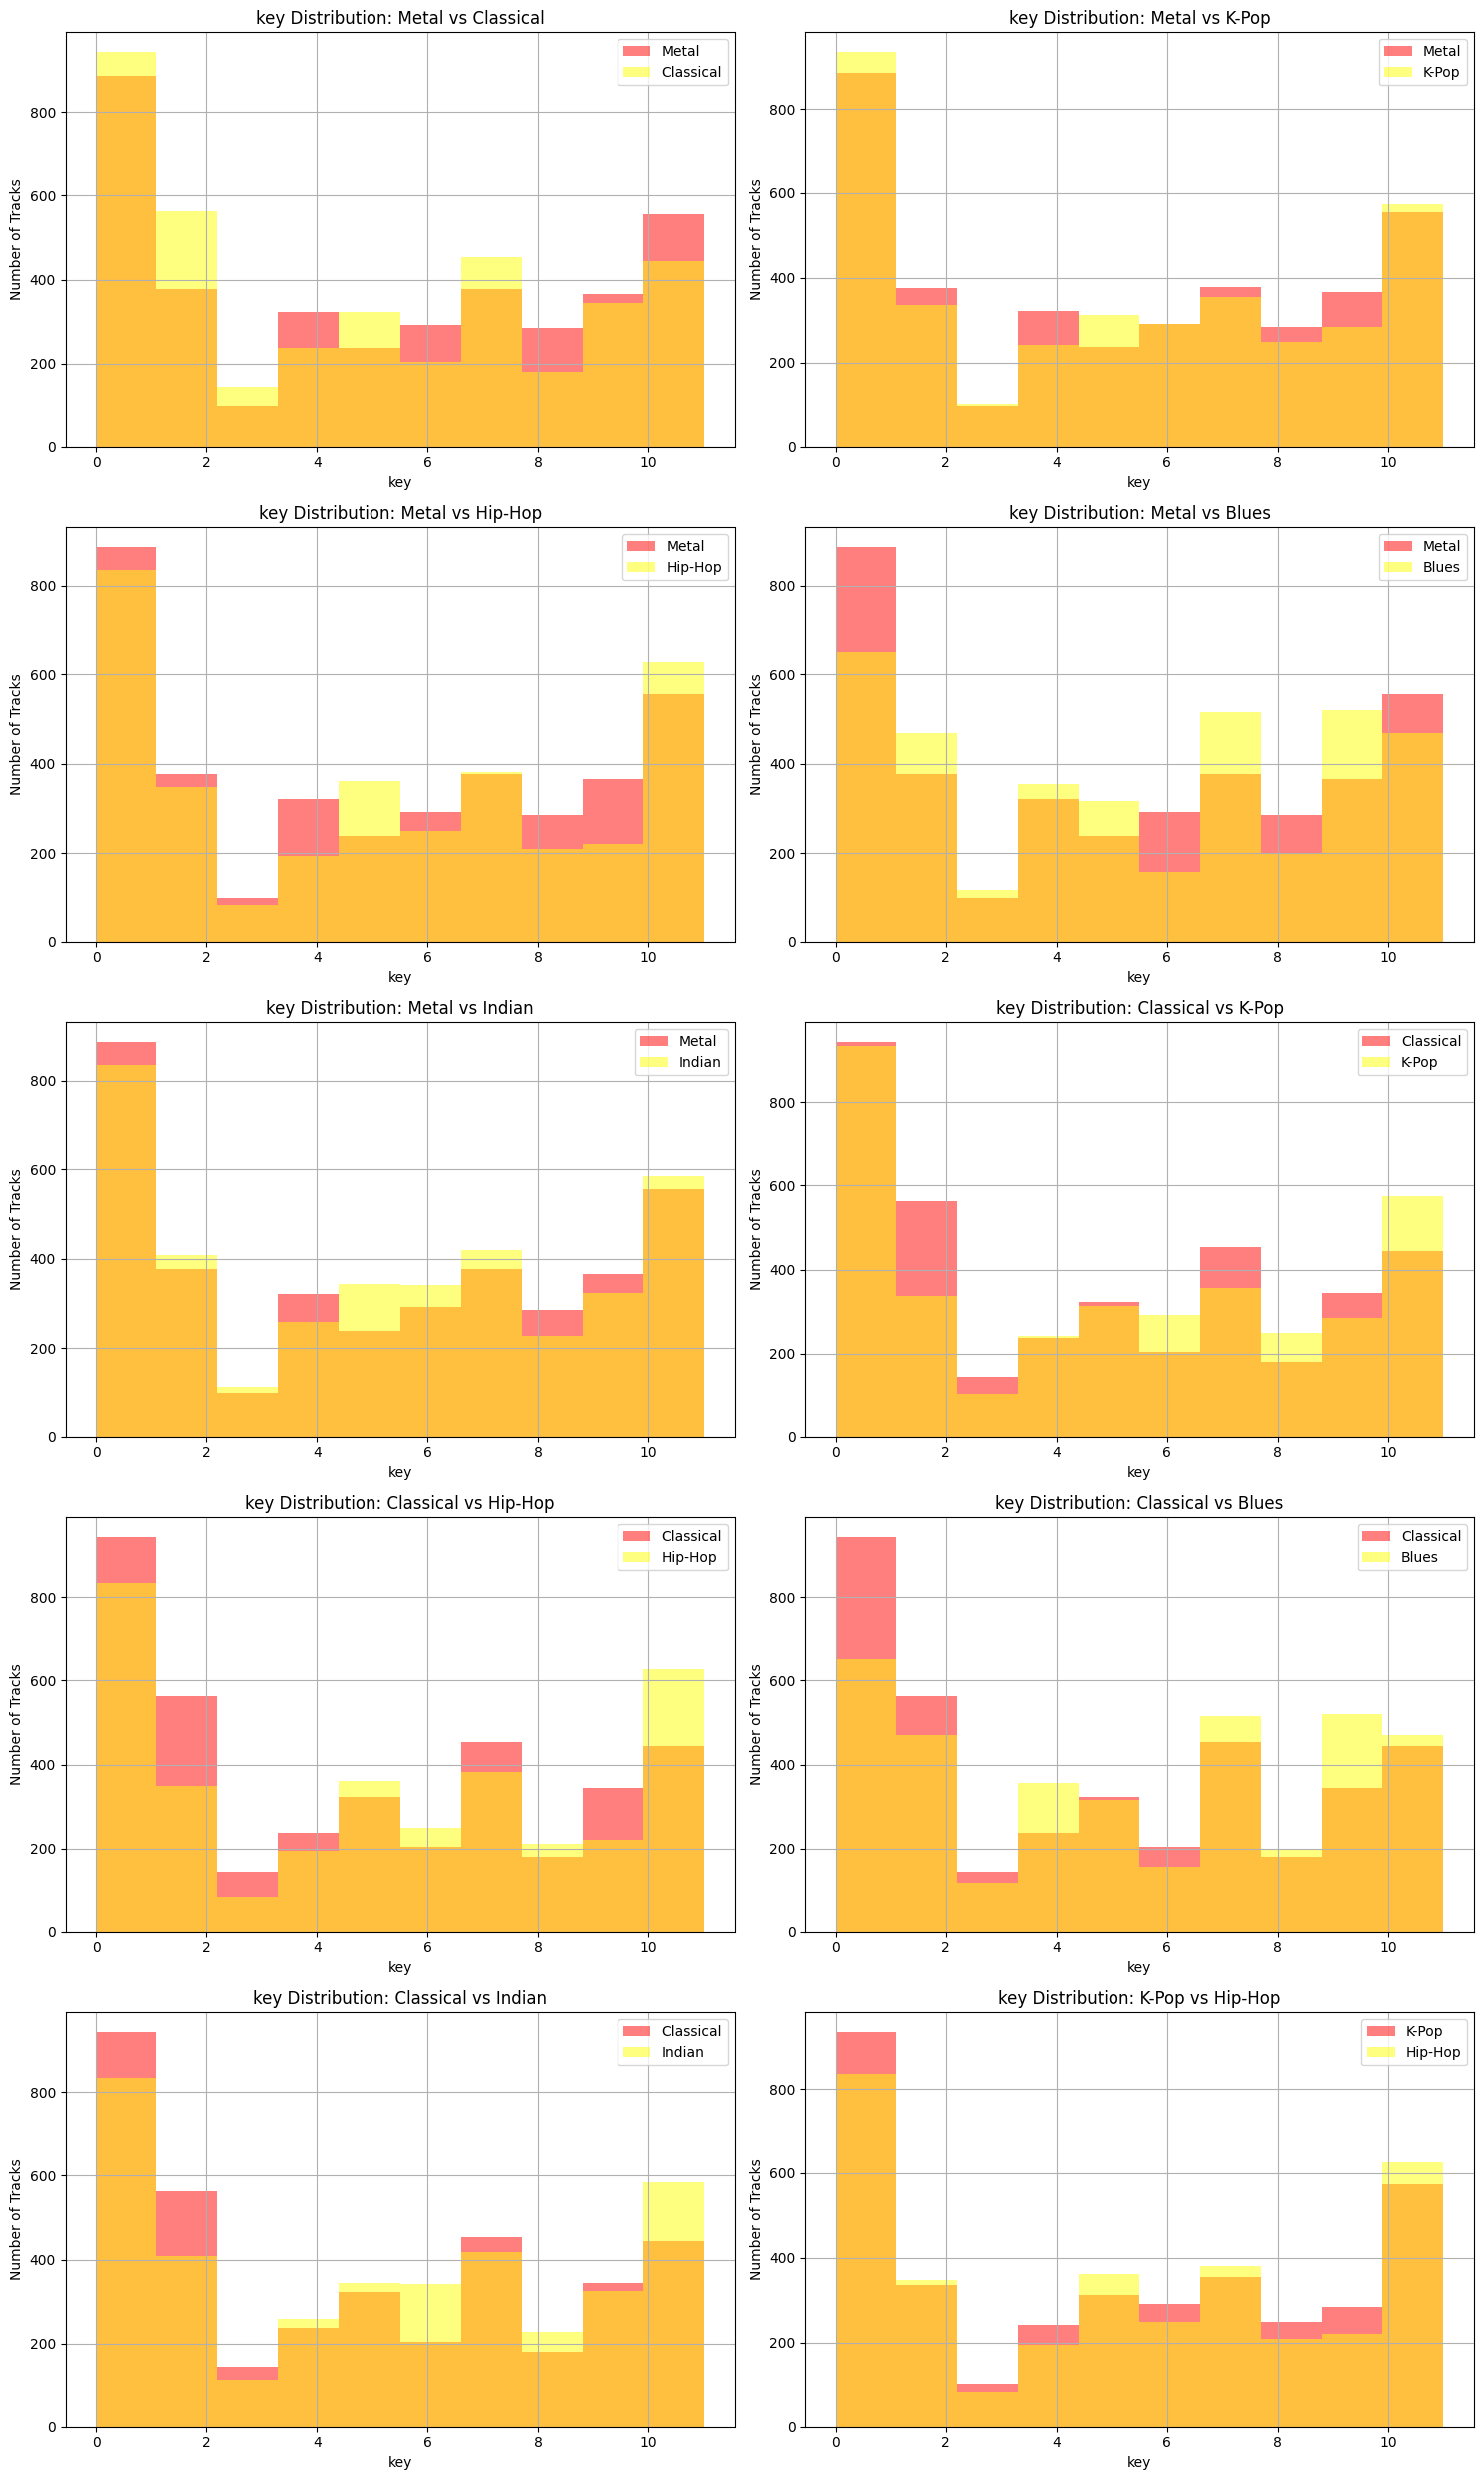

In [26]:
# key
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    ax.hist(genres_data[genre1]['key'], bins=10, alpha=0.5, label=genre1, color='red')
    ax.hist(genres_data[genre2]['key'], bins=10, alpha=0.5, label=genre2, color='yellow')
    ax.set_title(f'key Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('key')
    ax.set_ylabel('Number of Tracks')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

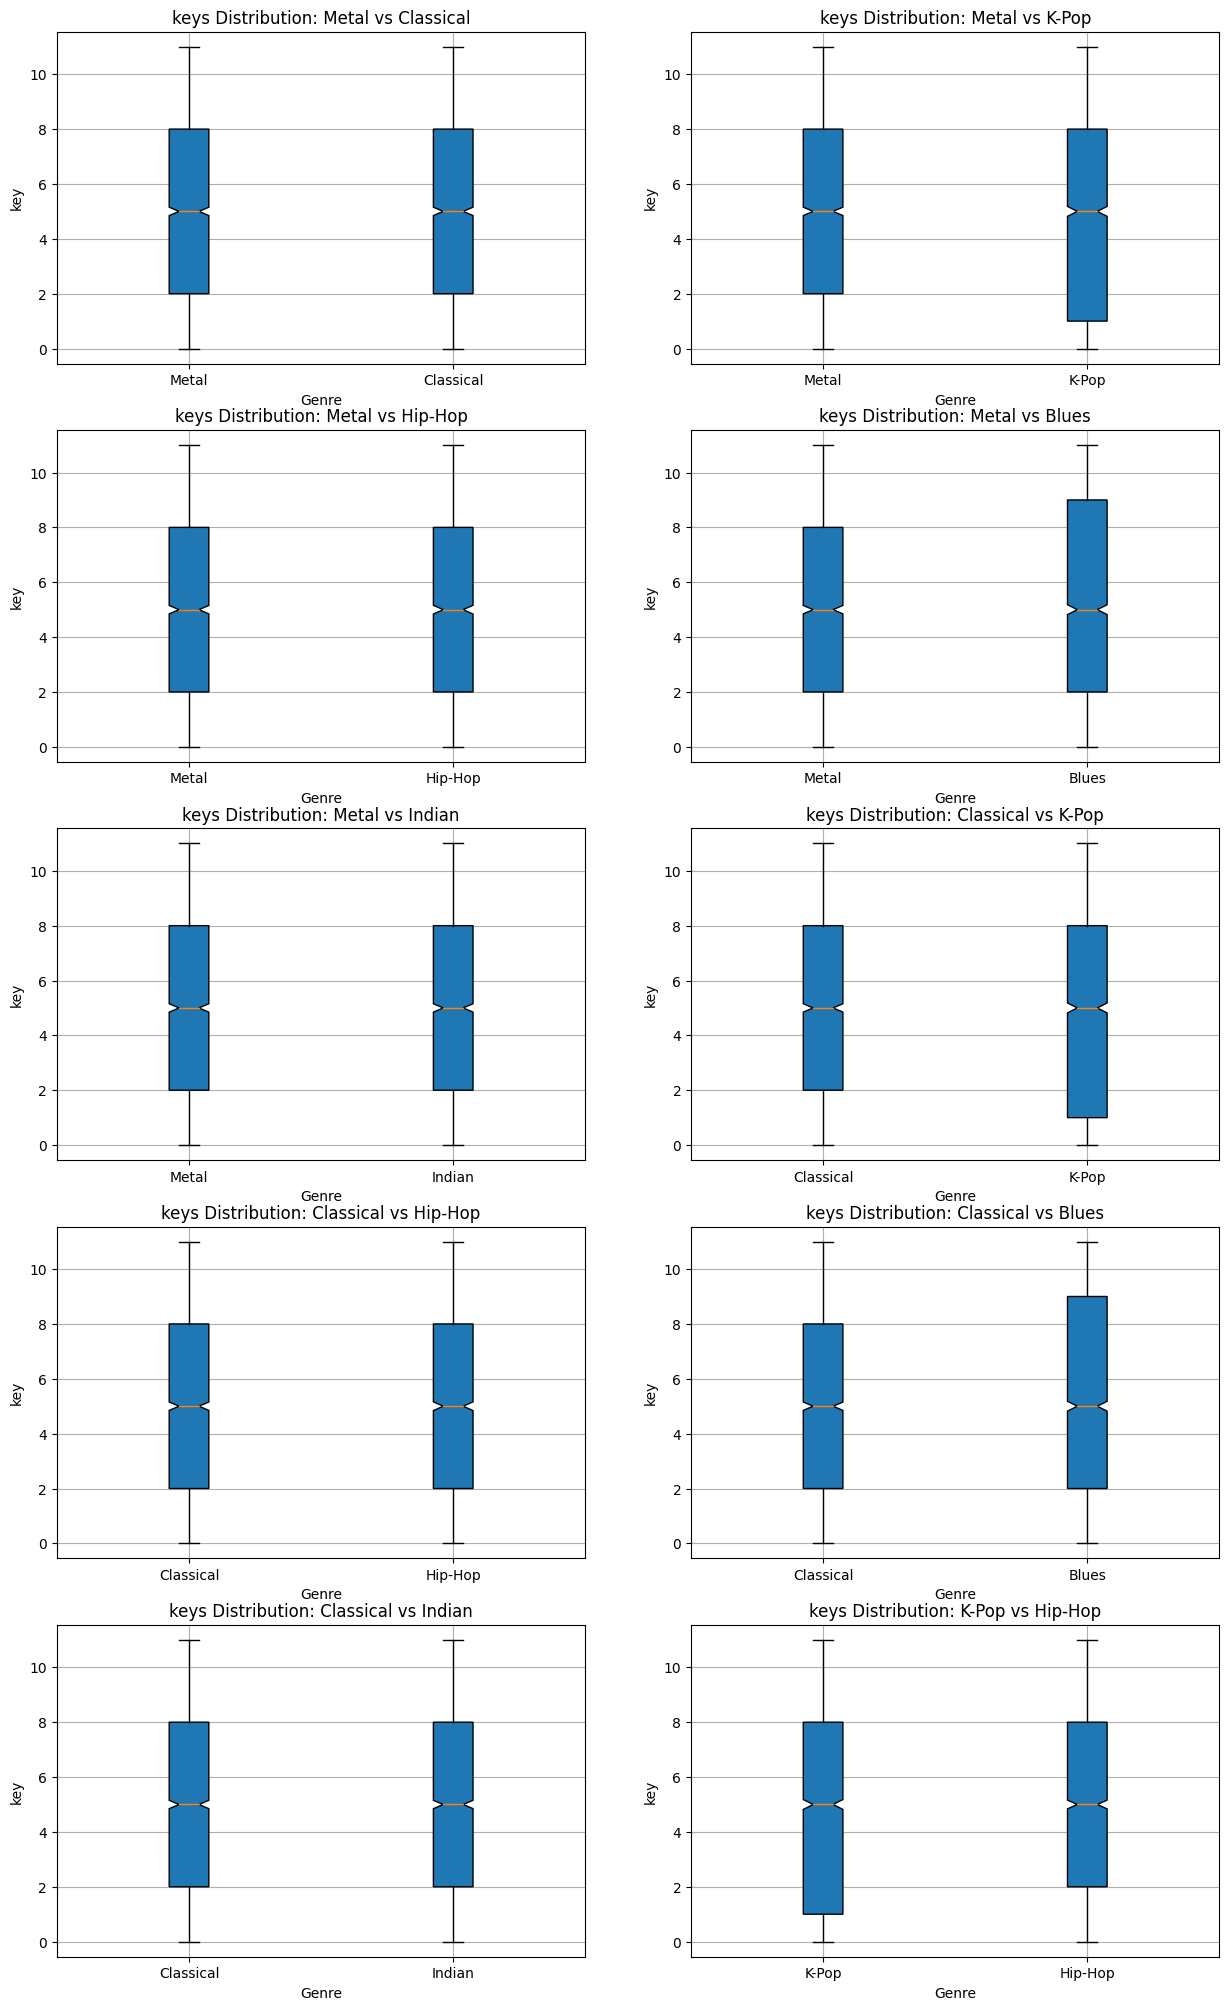

In [27]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    data_to_plot = [genres_data[genre1]['key'], genres_data[genre2]['key']]
    ax.boxplot(data_to_plot, labels=[genre1, genre2], notch=True, patch_artist=True)
    ax.set_title(f'keys Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('Genre')
    ax.set_ylabel('key')
    ax.grid(True)

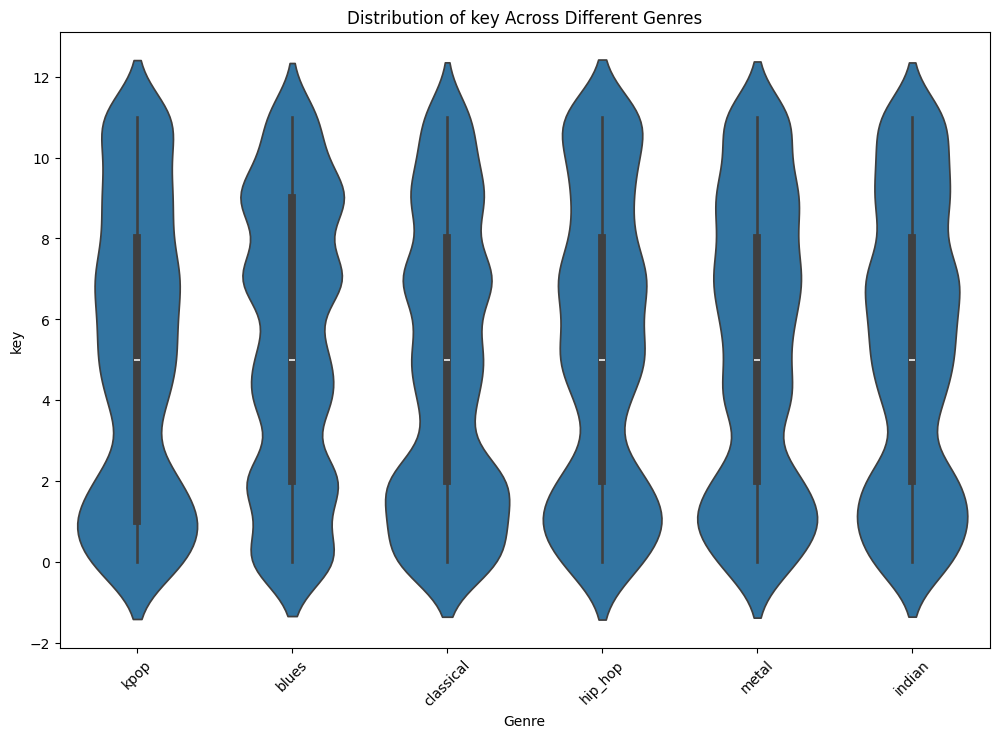

In [25]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='genre_track', y='key', data=data)
plt.title('Distribution of key Across Different Genres')
plt.xlabel('Genre')
plt.ylabel('key')
plt.xticks(rotation=45)
plt.show()

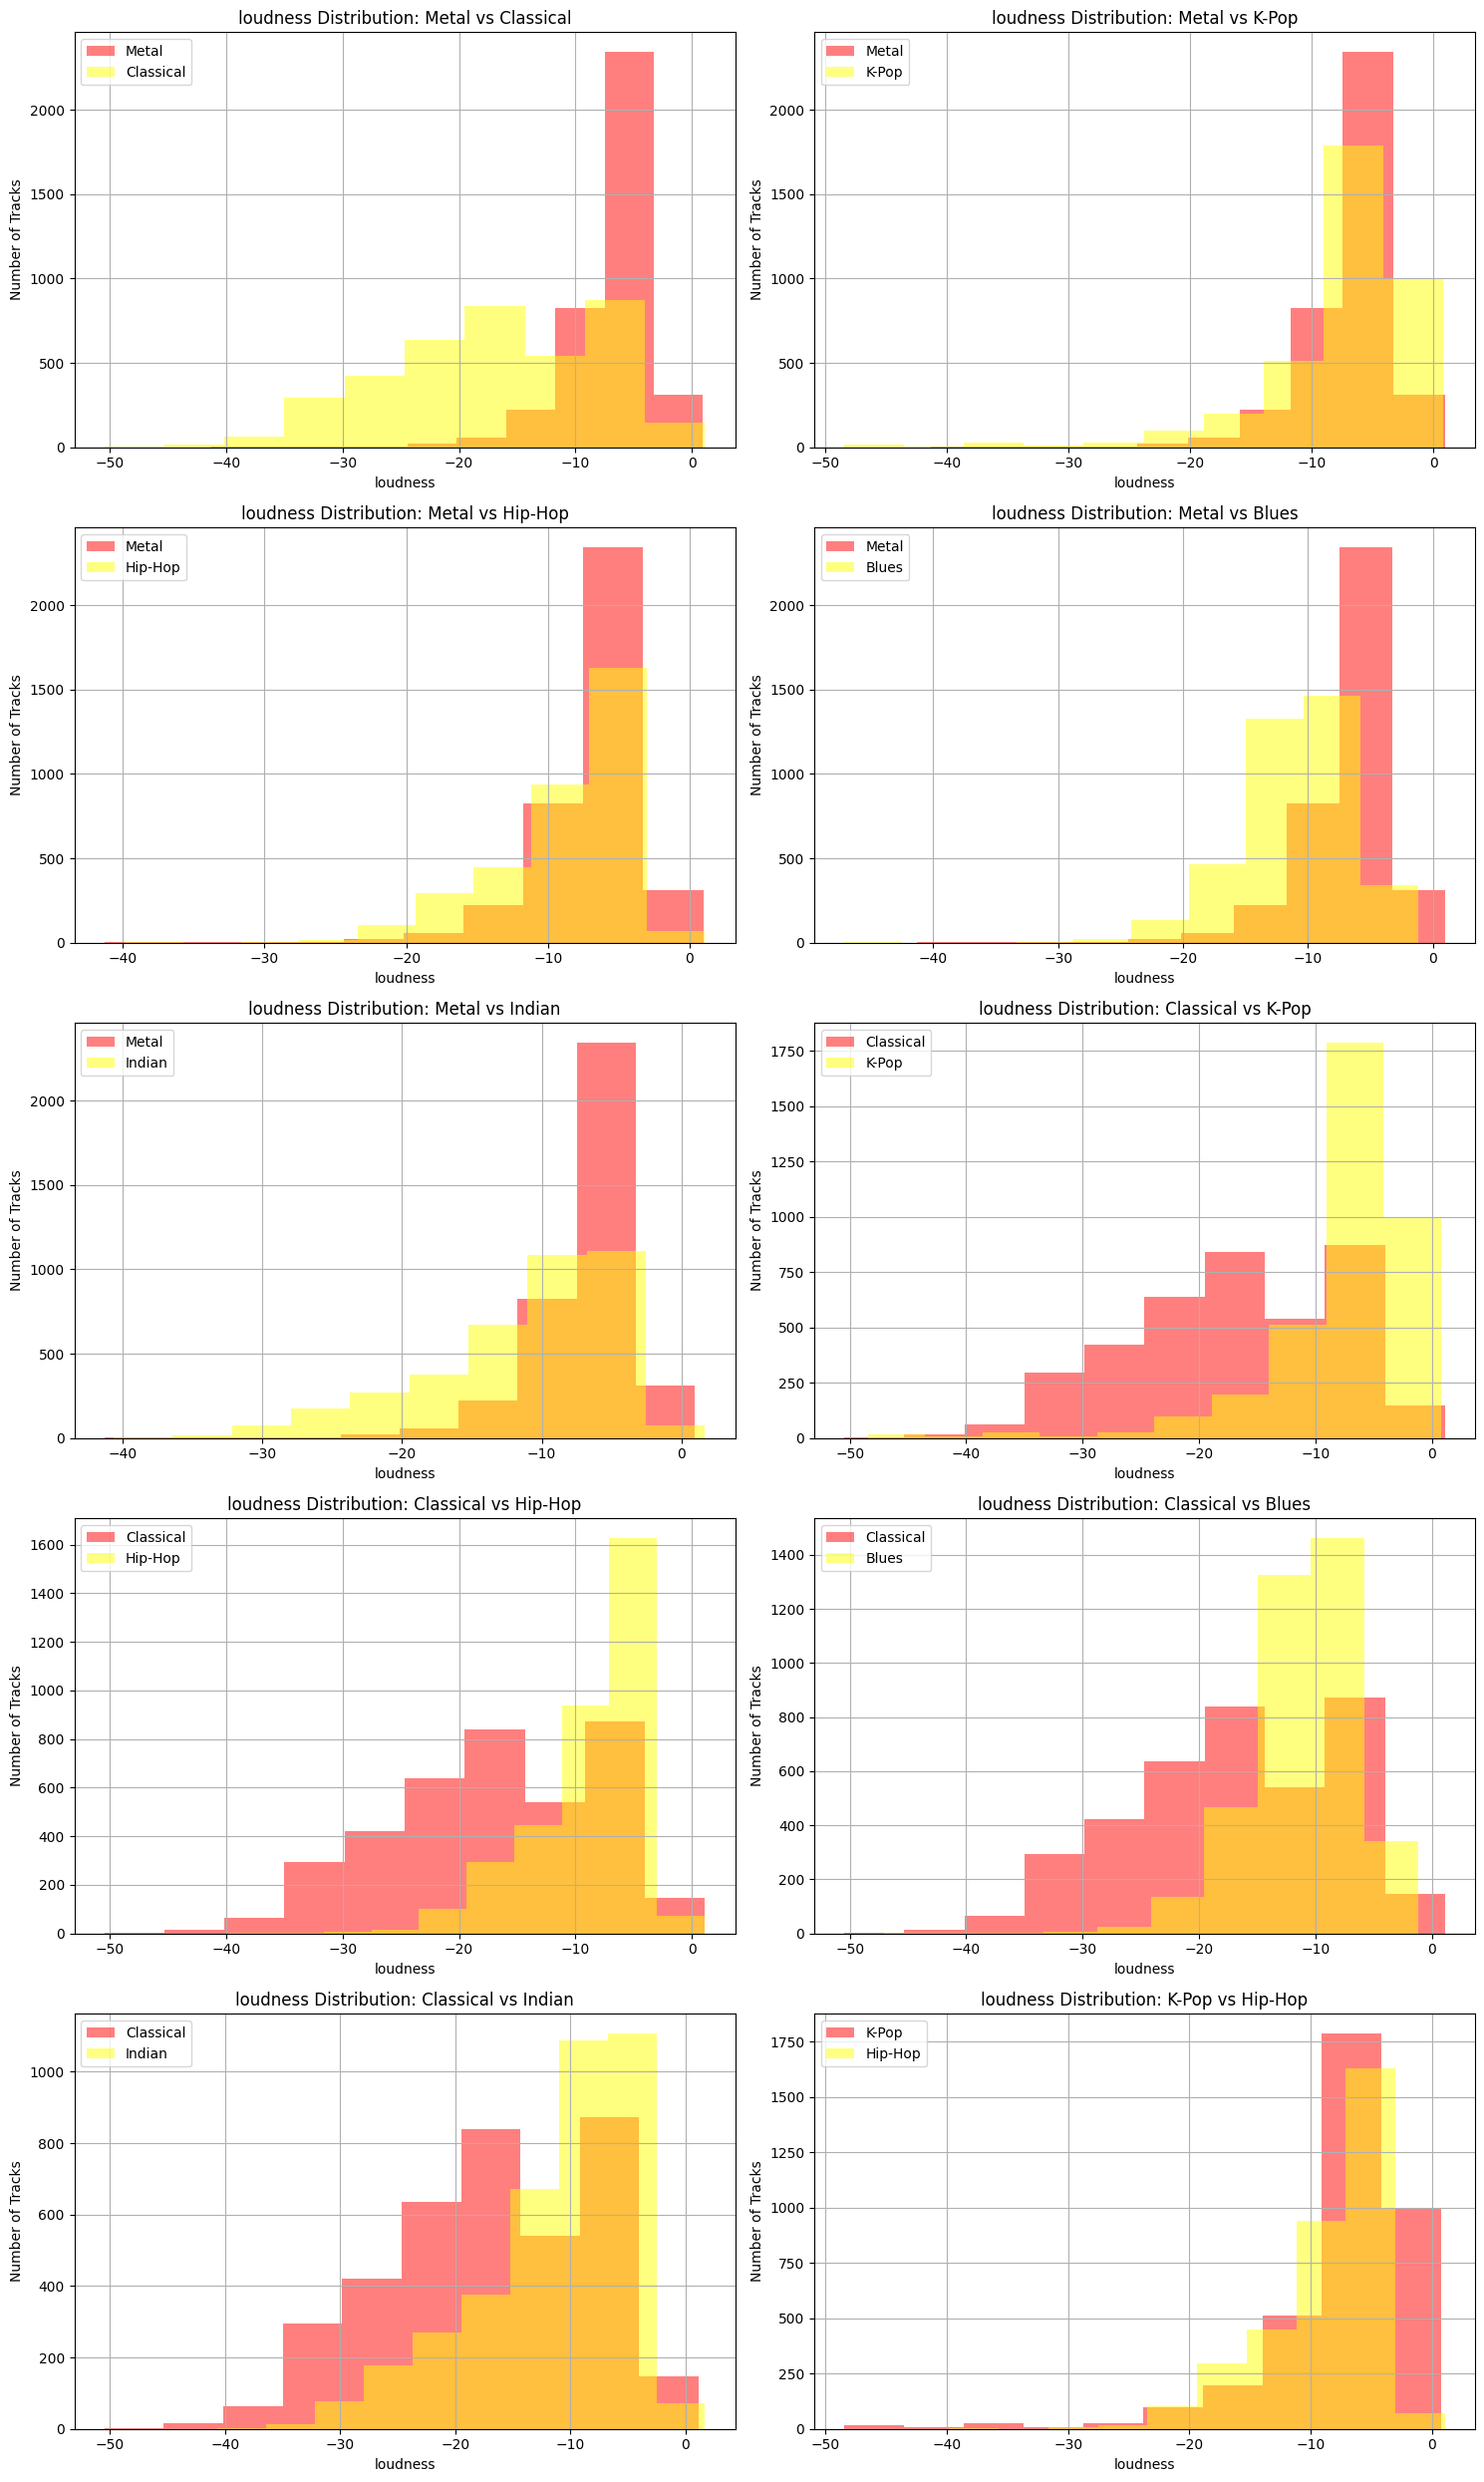

In [28]:
# loudness
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    ax.hist(genres_data[genre1]['loudness'], bins=10, alpha=0.5, label=genre1, color='red')
    ax.hist(genres_data[genre2]['loudness'], bins=10, alpha=0.5, label=genre2, color='yellow')
    ax.set_title(f'loudness Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('loudness')
    ax.set_ylabel('Number of Tracks')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

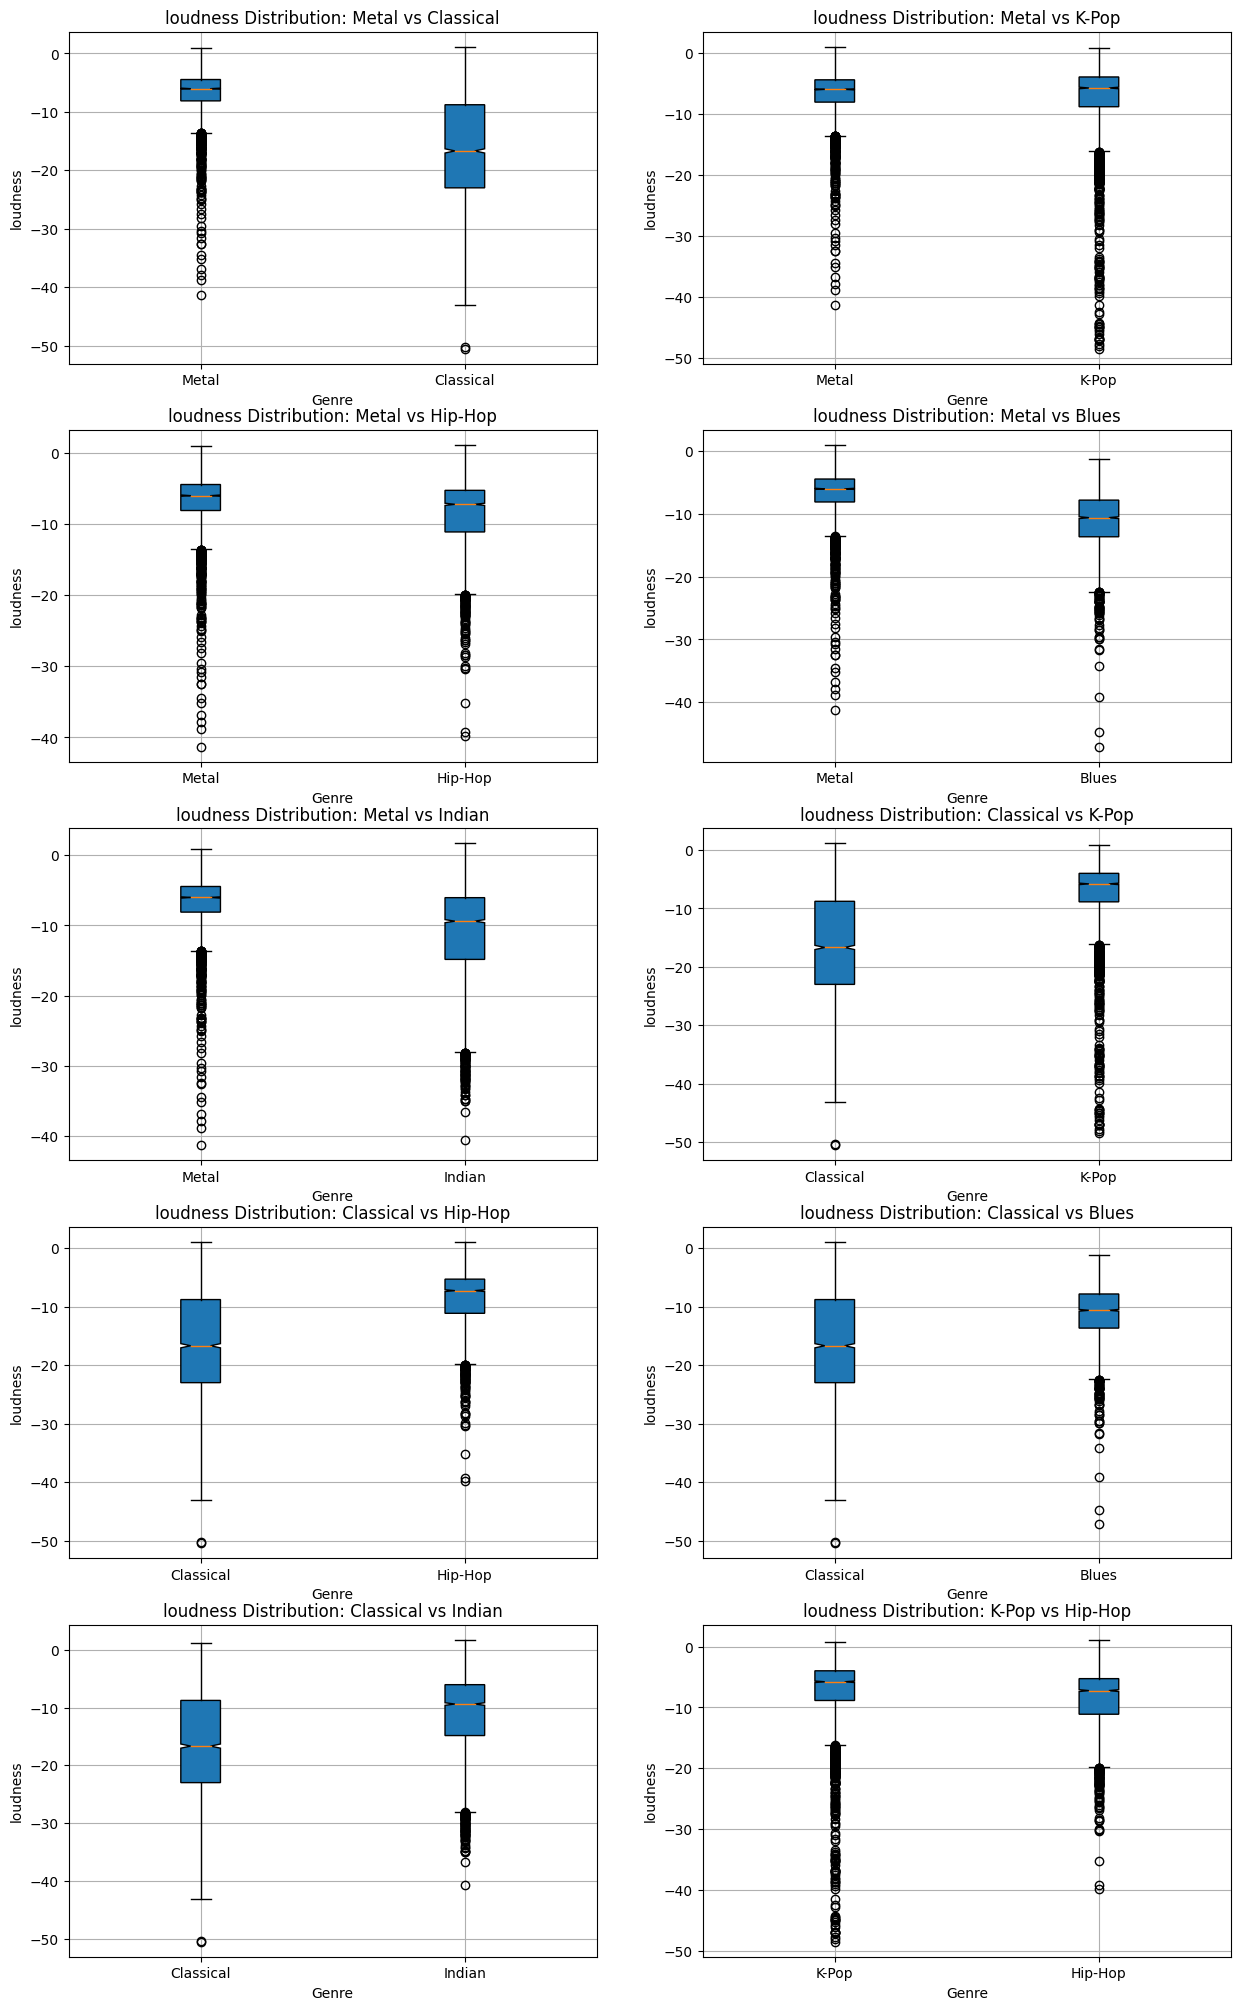

In [29]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    data_to_plot = [genres_data[genre1]['loudness'], genres_data[genre2]['loudness']]
    ax.boxplot(data_to_plot, labels=[genre1, genre2], notch=True, patch_artist=True)
    ax.set_title(f'loudness Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('Genre')
    ax.set_ylabel('loudness')
    ax.grid(True)

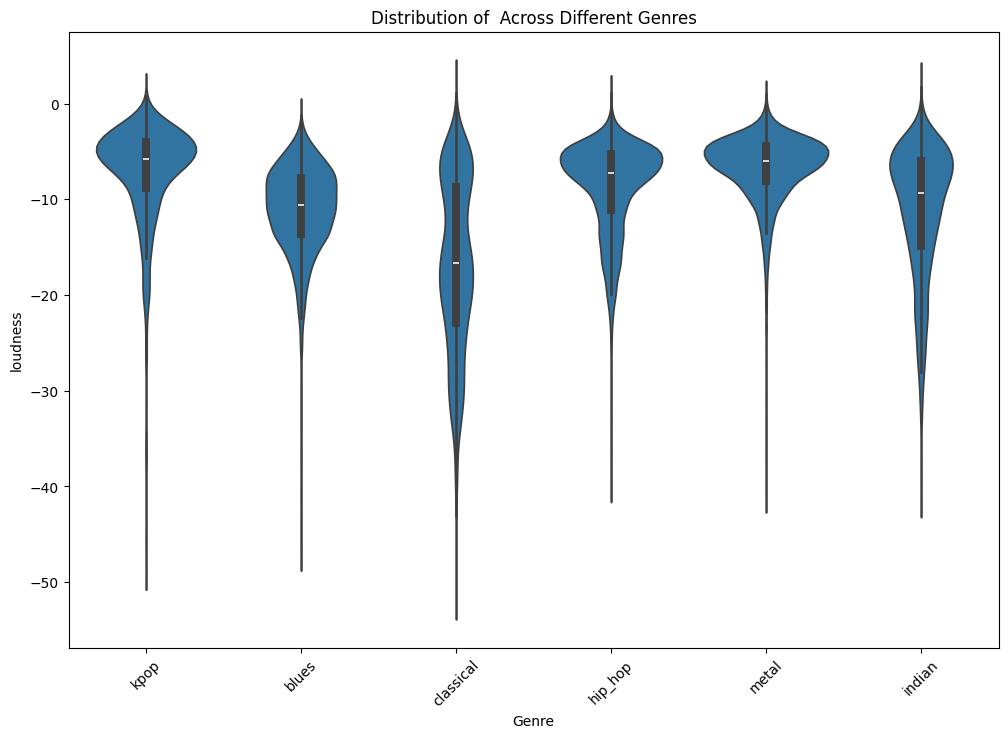

In [26]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='genre_track', y='loudness', data=data)
plt.title('Distribution of loudness Across Different Genres')
plt.xlabel('Genre')
plt.ylabel('loudness')
plt.xticks(rotation=45)
plt.show()

Метал и Хип-Хоп: Эти жанры демонстрируют более высокие средние уровни громкости, что отражает их агрессивный и энергичный характер.

Классика: Классическая музыка показывает самые низкие уровни громкости, что согласуется с её более тонким и динамичным характером, где динамический диапазон может быть очень широким, но максимальная громкость обычно ниже.

K-pop, Блюз и Индийский жанр: Имеют средние значения громкости с различной степенью разброса, что указывает на разнообразие треков в этих жанрах относительно их громкости.

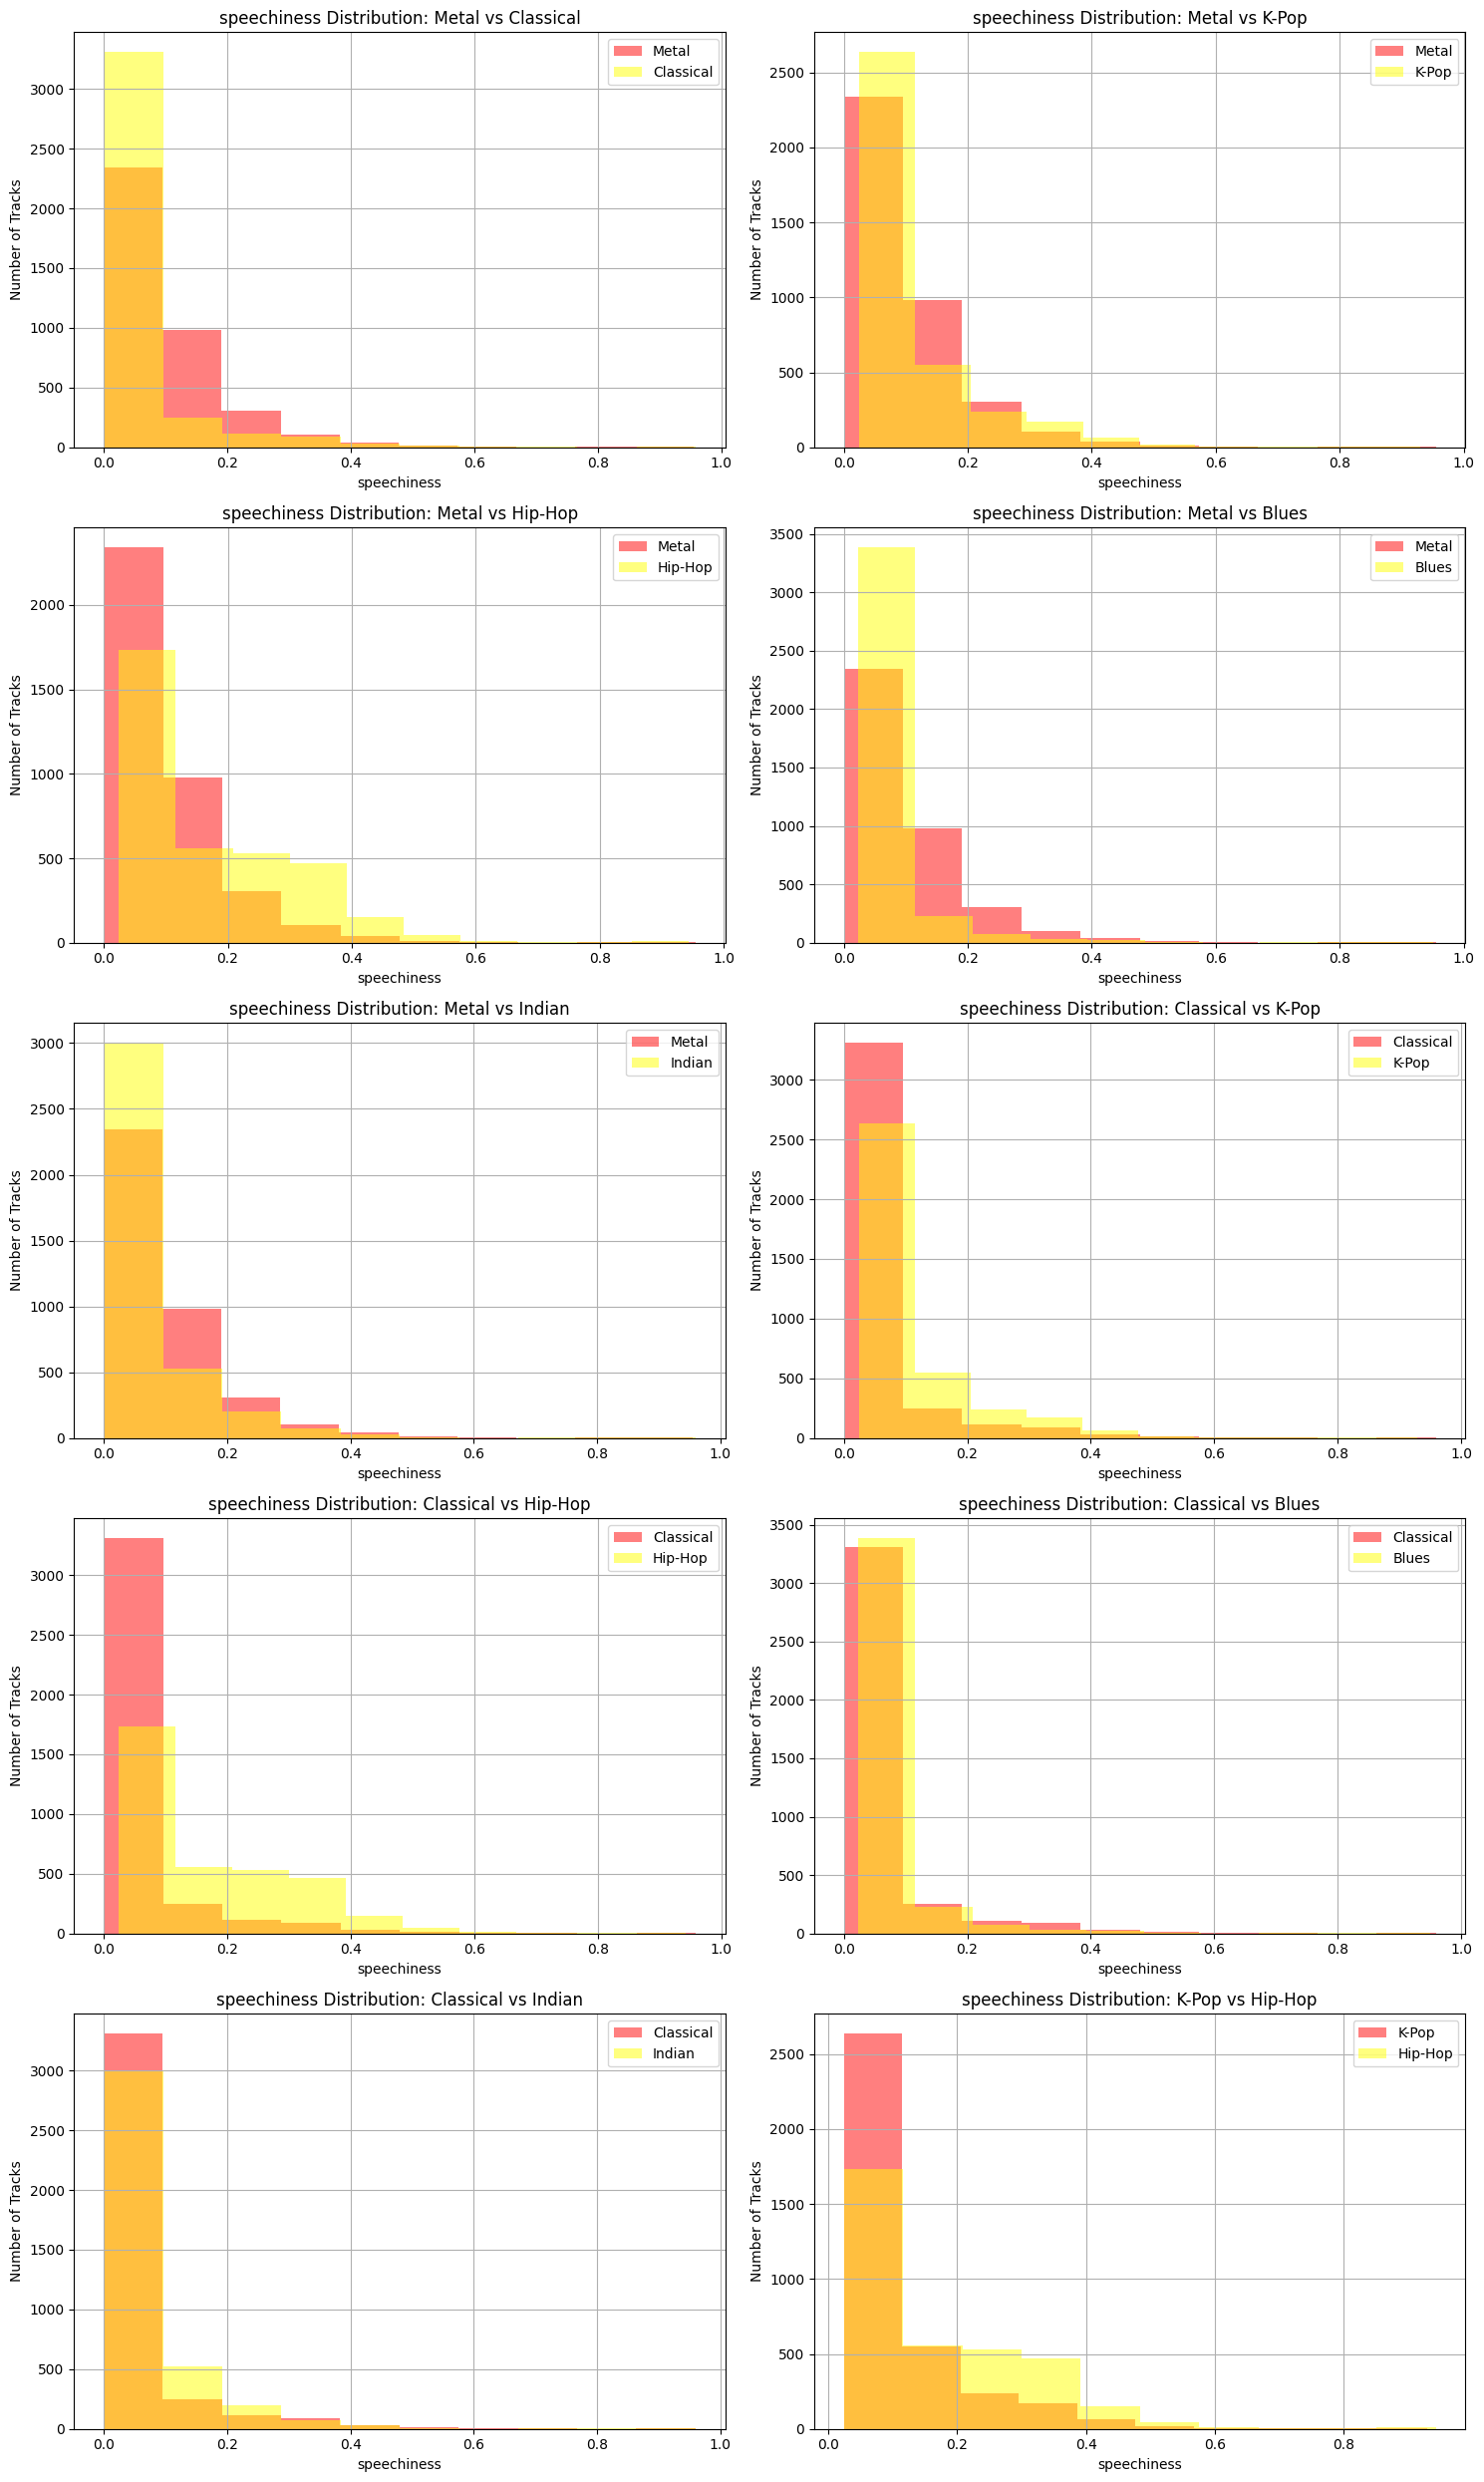

In [30]:
# speechiness
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    ax.hist(genres_data[genre1]['speechiness'], bins=10, alpha=0.5, label=genre1, color='red')
    ax.hist(genres_data[genre2]['speechiness'], bins=10, alpha=0.5, label=genre2, color='yellow')
    ax.set_title(f'speechiness Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('speechiness')
    ax.set_ylabel('Number of Tracks')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

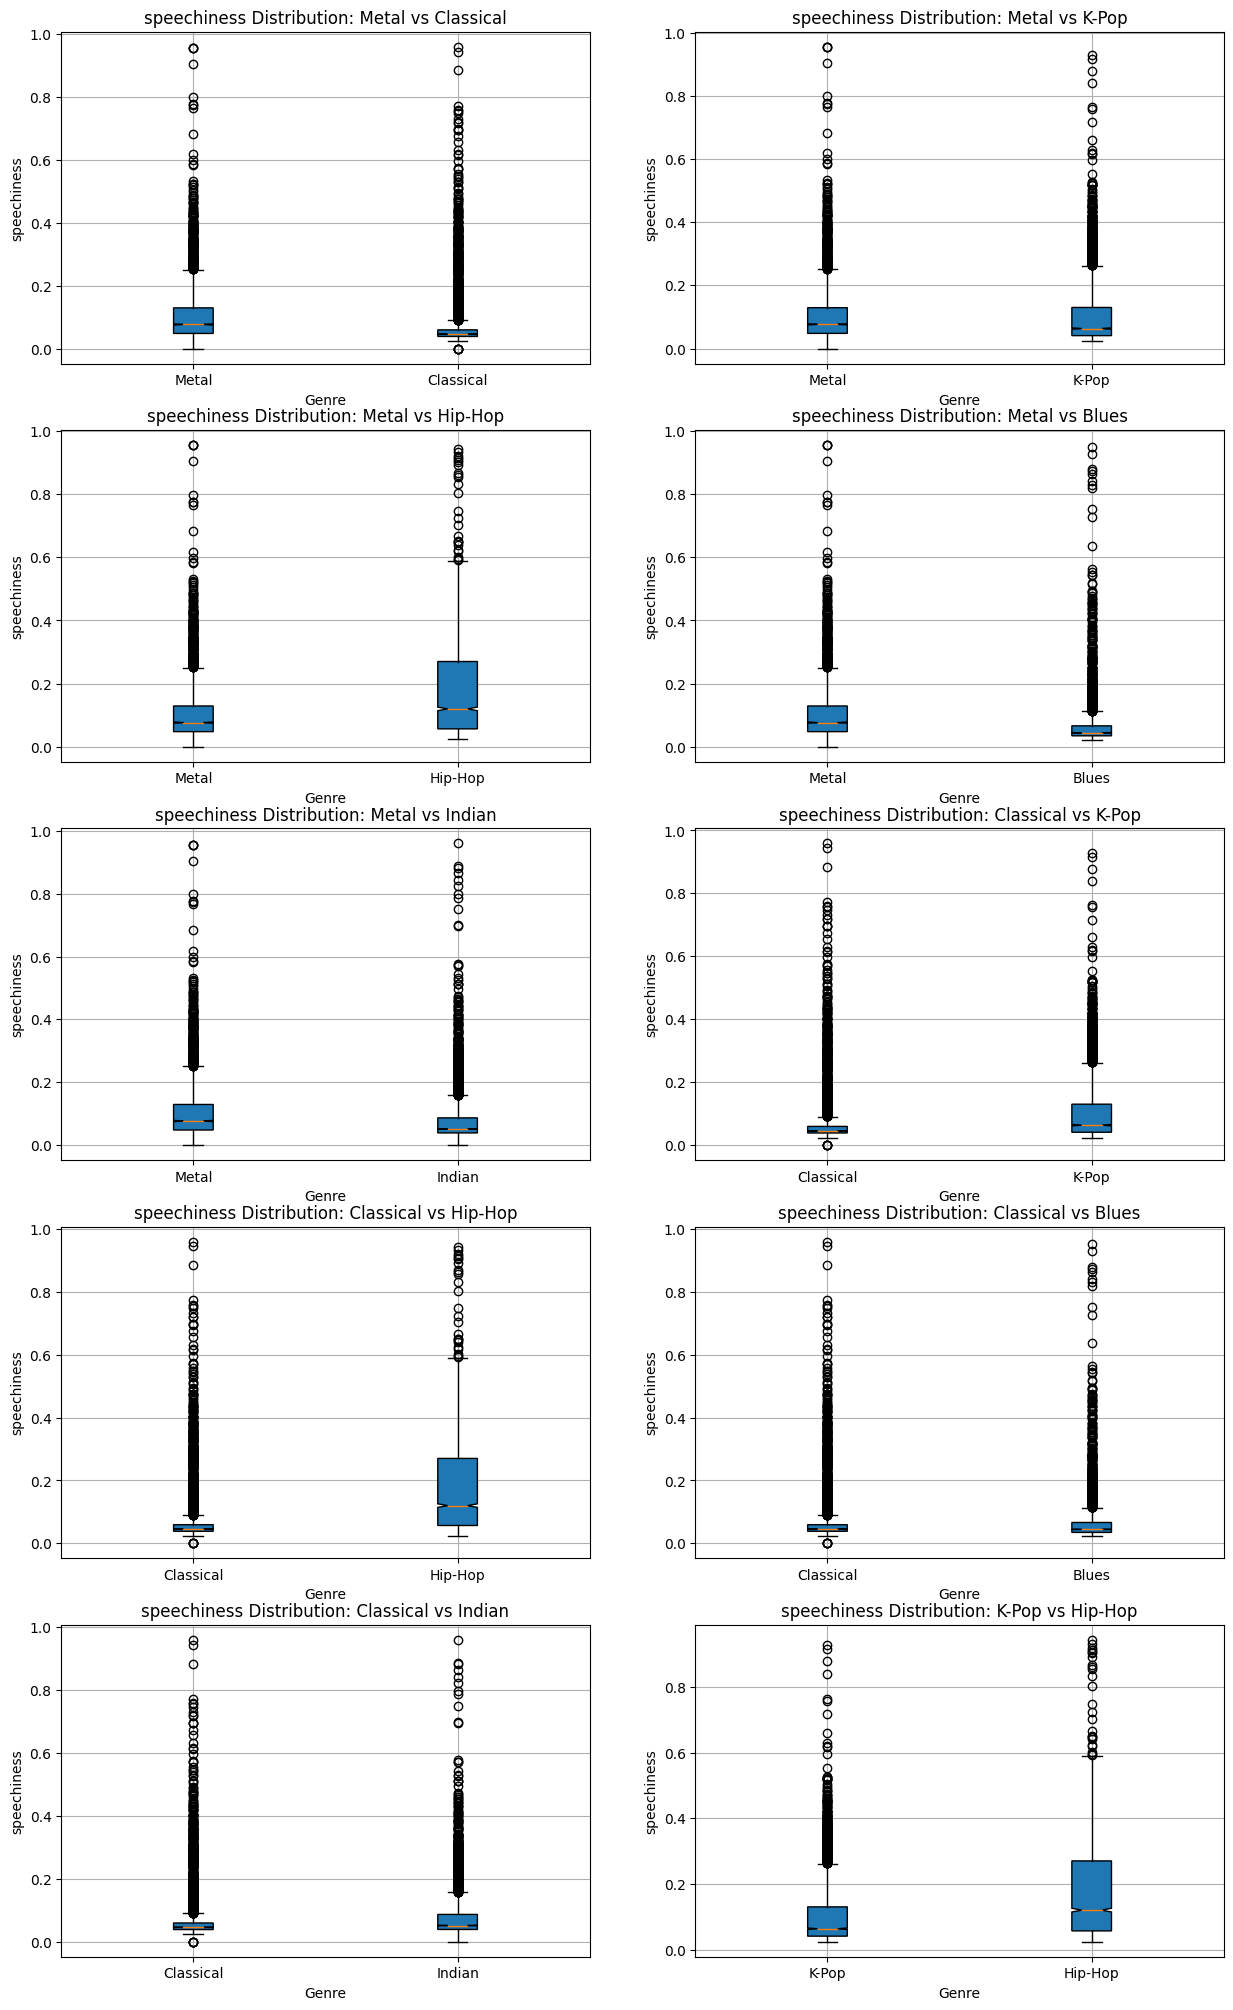

In [31]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    data_to_plot = [genres_data[genre1]['speechiness'], genres_data[genre2]['speechiness']]
    ax.boxplot(data_to_plot, labels=[genre1, genre2], notch=True, patch_artist=True)
    ax.set_title(f'speechiness Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('Genre')
    ax.set_ylabel('speechiness')
    ax.grid(True)

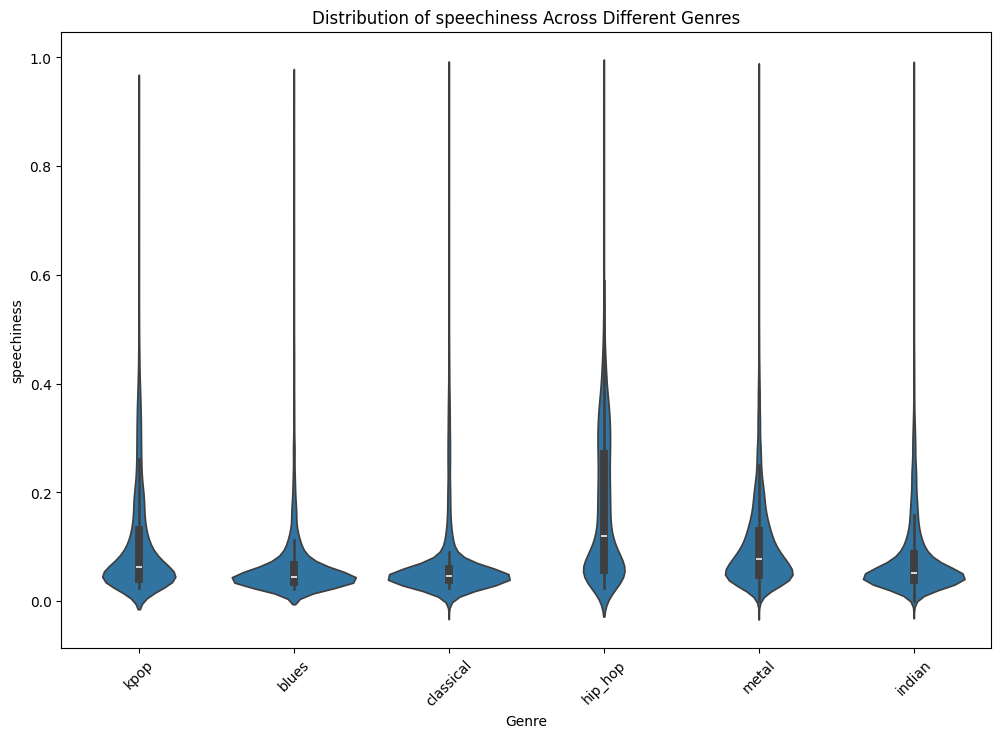

In [27]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='genre_track', y='speechiness', data=data)
plt.title('Distribution of speechiness Across Different Genres')
plt.xlabel('Genre')
plt.ylabel('speechiness')
plt.xticks(rotation=45)
plt.show()

Жанры с высокой речевостью:
Hip-Hop является явным лидером по уровню речевости, что отражает характер жанра, в котором речитатив (рэп) занимает центральное место. Этот жанр показывает не только наивысшую медиану, но и значительную плотность вокруг высоких значений.

Жанры с низкой речевостью:
Classical, Metal, и Blues показывают очень низкие уровни речевости. Это ожидаемо, так как в этих жанрах преобладают инструментальные композиции или композиции, где вокал исполняется певцом, но без речевых элементов.
K-pop и Indian также имеют низкие значения, что указывает на то, что вокал в этих жанрах, хоть и присутствует, не носит характер разговорной речи.

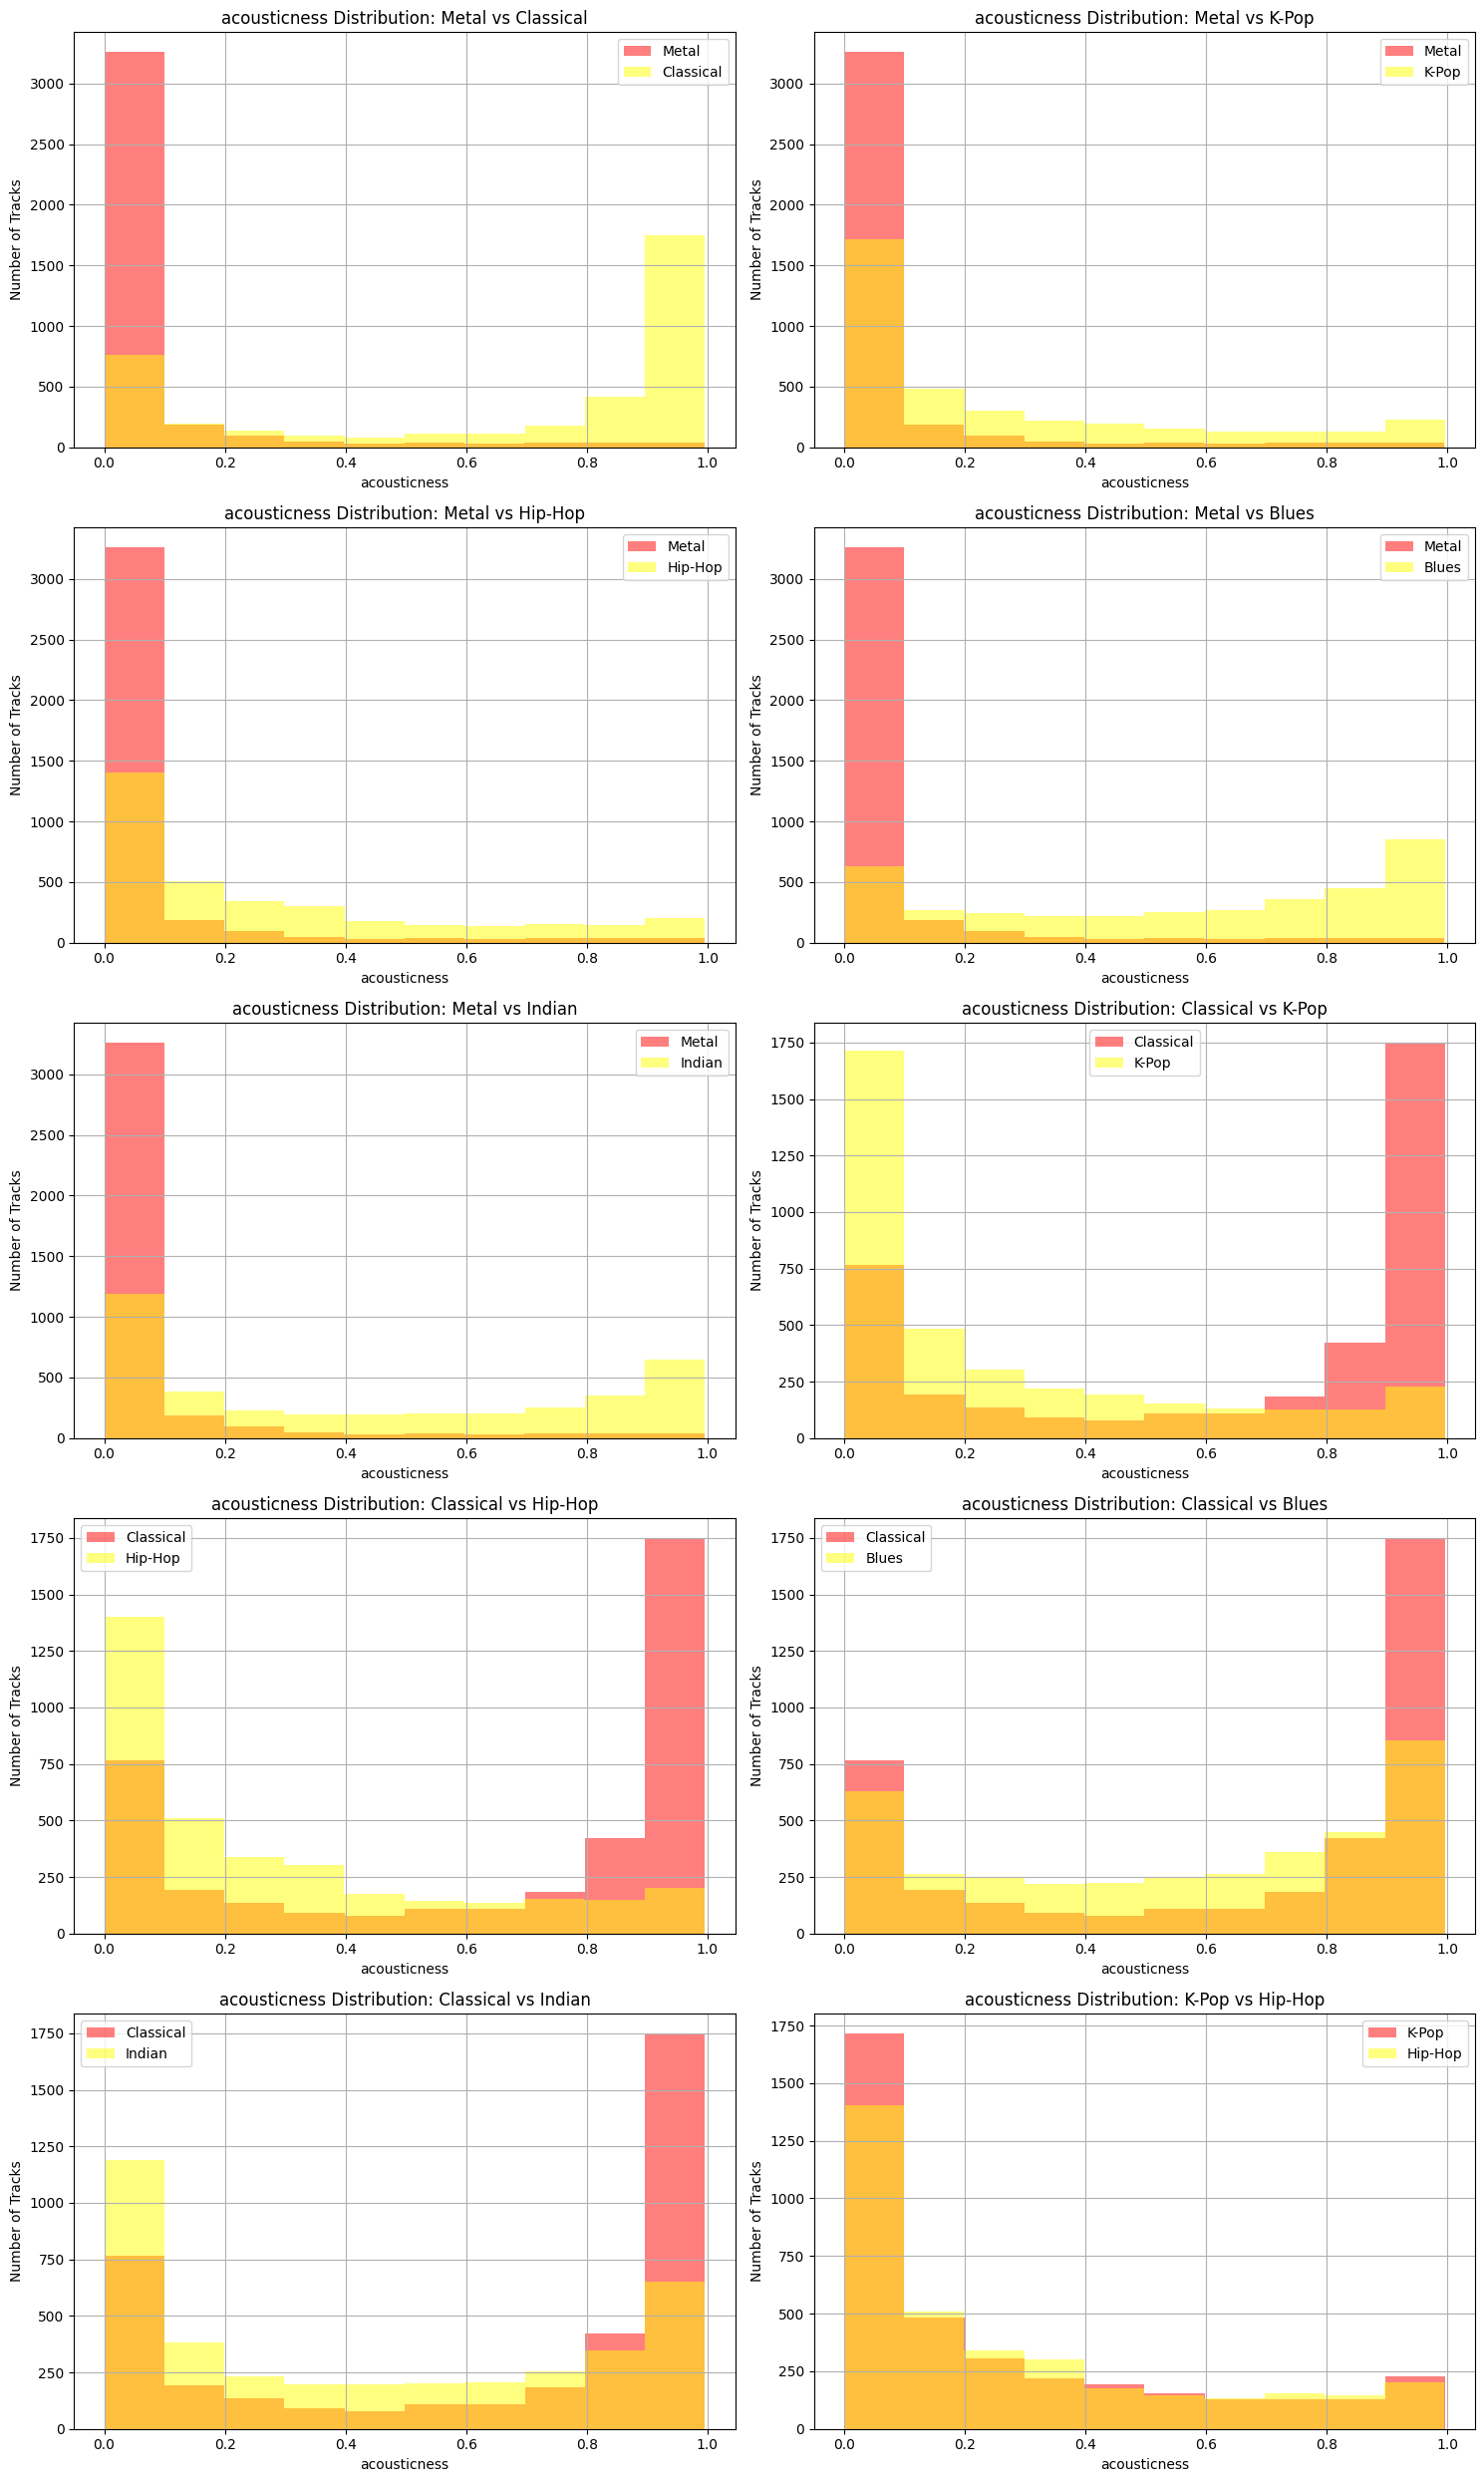

In [32]:
# acousticness
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    ax.hist(genres_data[genre1]['acousticness'], bins=10, alpha=0.5, label=genre1, color='red')
    ax.hist(genres_data[genre2]['acousticness'], bins=10, alpha=0.5, label=genre2, color='yellow')
    ax.set_title(f'acousticness Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('acousticness')
    ax.set_ylabel('Number of Tracks')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

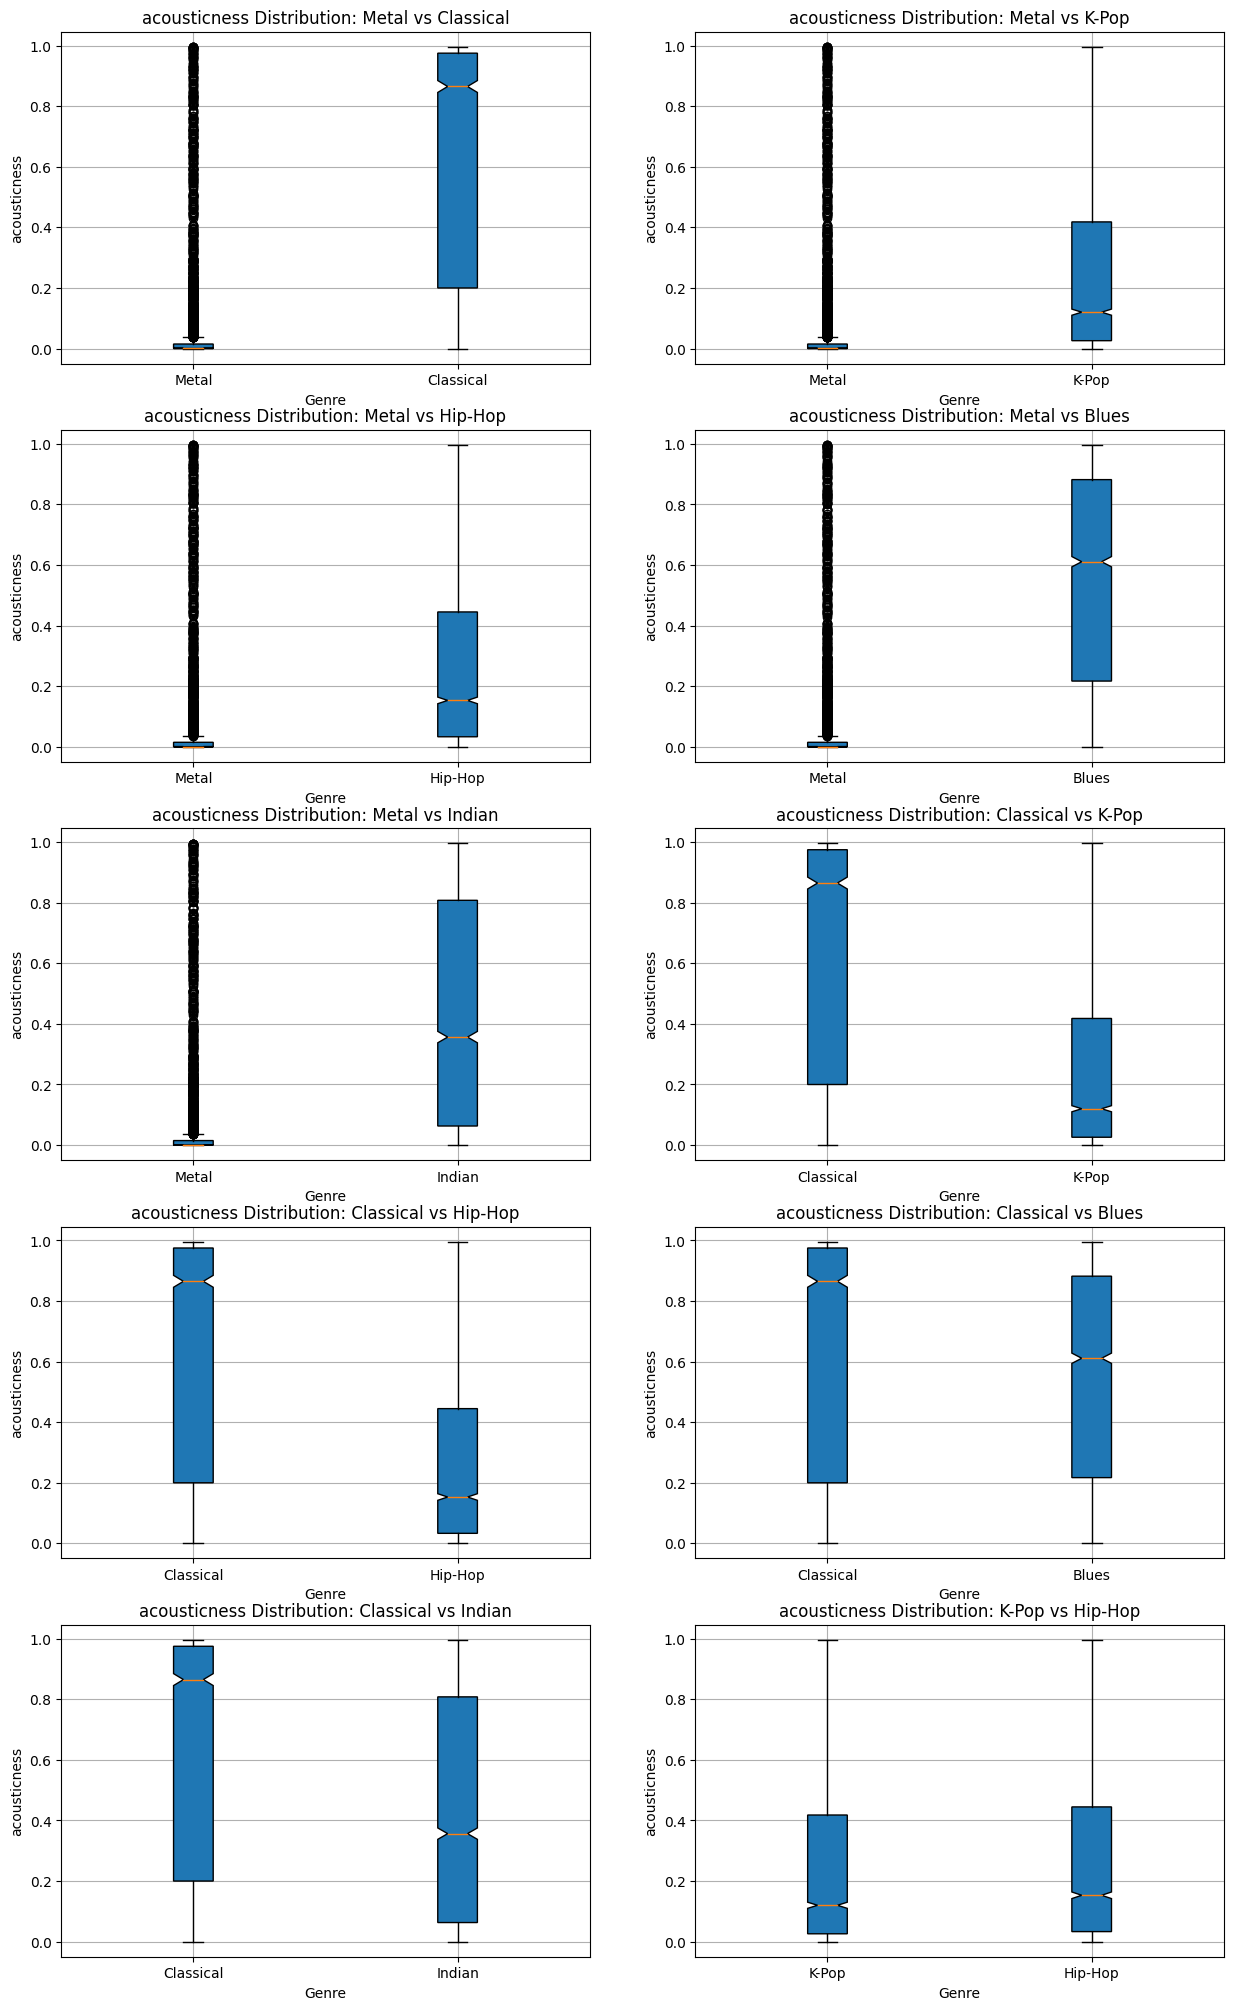

In [33]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    data_to_plot = [genres_data[genre1]['acousticness'], genres_data[genre2]['acousticness']]
    ax.boxplot(data_to_plot, labels=[genre1, genre2], notch=True, patch_artist=True)
    ax.set_title(f'acousticness Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('Genre')
    ax.set_ylabel('acousticness')
    ax.grid(True)

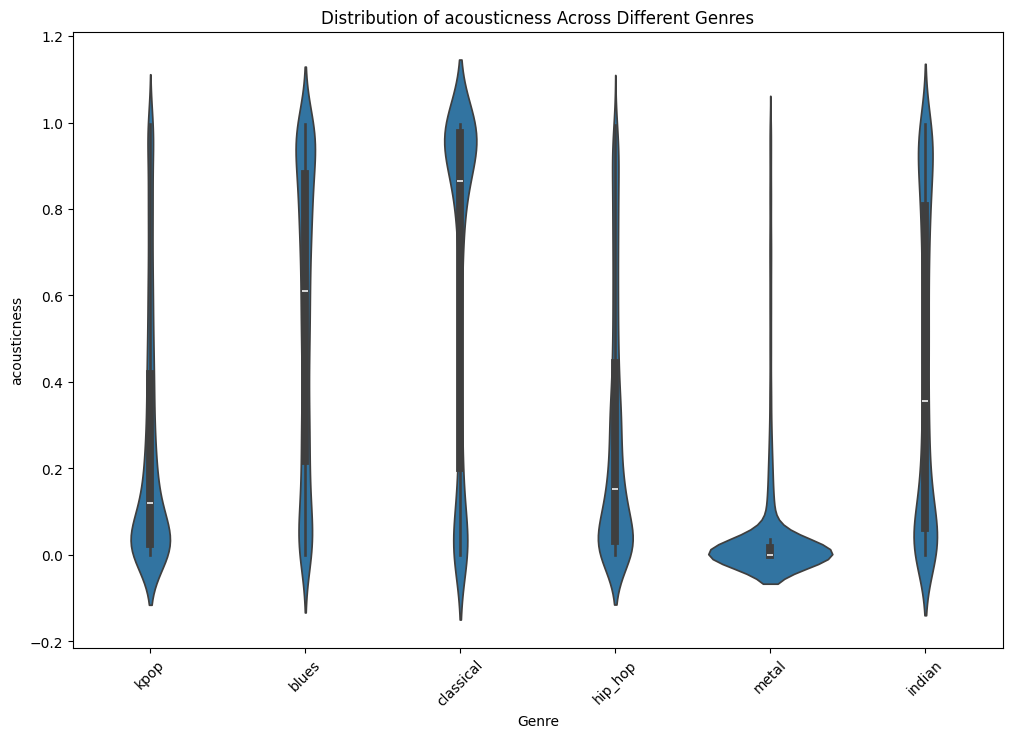

In [28]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='genre_track', y='acousticness', data=data)
plt.title('Distribution of acousticness Across Different Genres')
plt.xlabel('Genre')
plt.ylabel('acousticness')
plt.xticks(rotation=45)
plt.show()

Высокая акустичность:
Classical жанр выделяется среди других своим высоким уровнем акустичности, что соответствует его основе на живой инструментальной музыке без электронных модификаций.

Низкая акустичность:
Жанры Hip-Hop, Metal и Indian показывают низкие уровни акустичности, что отражает их тягу к использованию электронных и усиленных звуков.
Особенно низкую акустичность показывает Metal, что соответствует характеру жанра с преобладанием тяжёлых электрогитар и других усиленных инструментов.

Средняя акустичность:
Жанры K-pop и Blues имеют более умеренные уровни акустичности, что может отражать смешение живых инструментов с элементами электронной музыки.

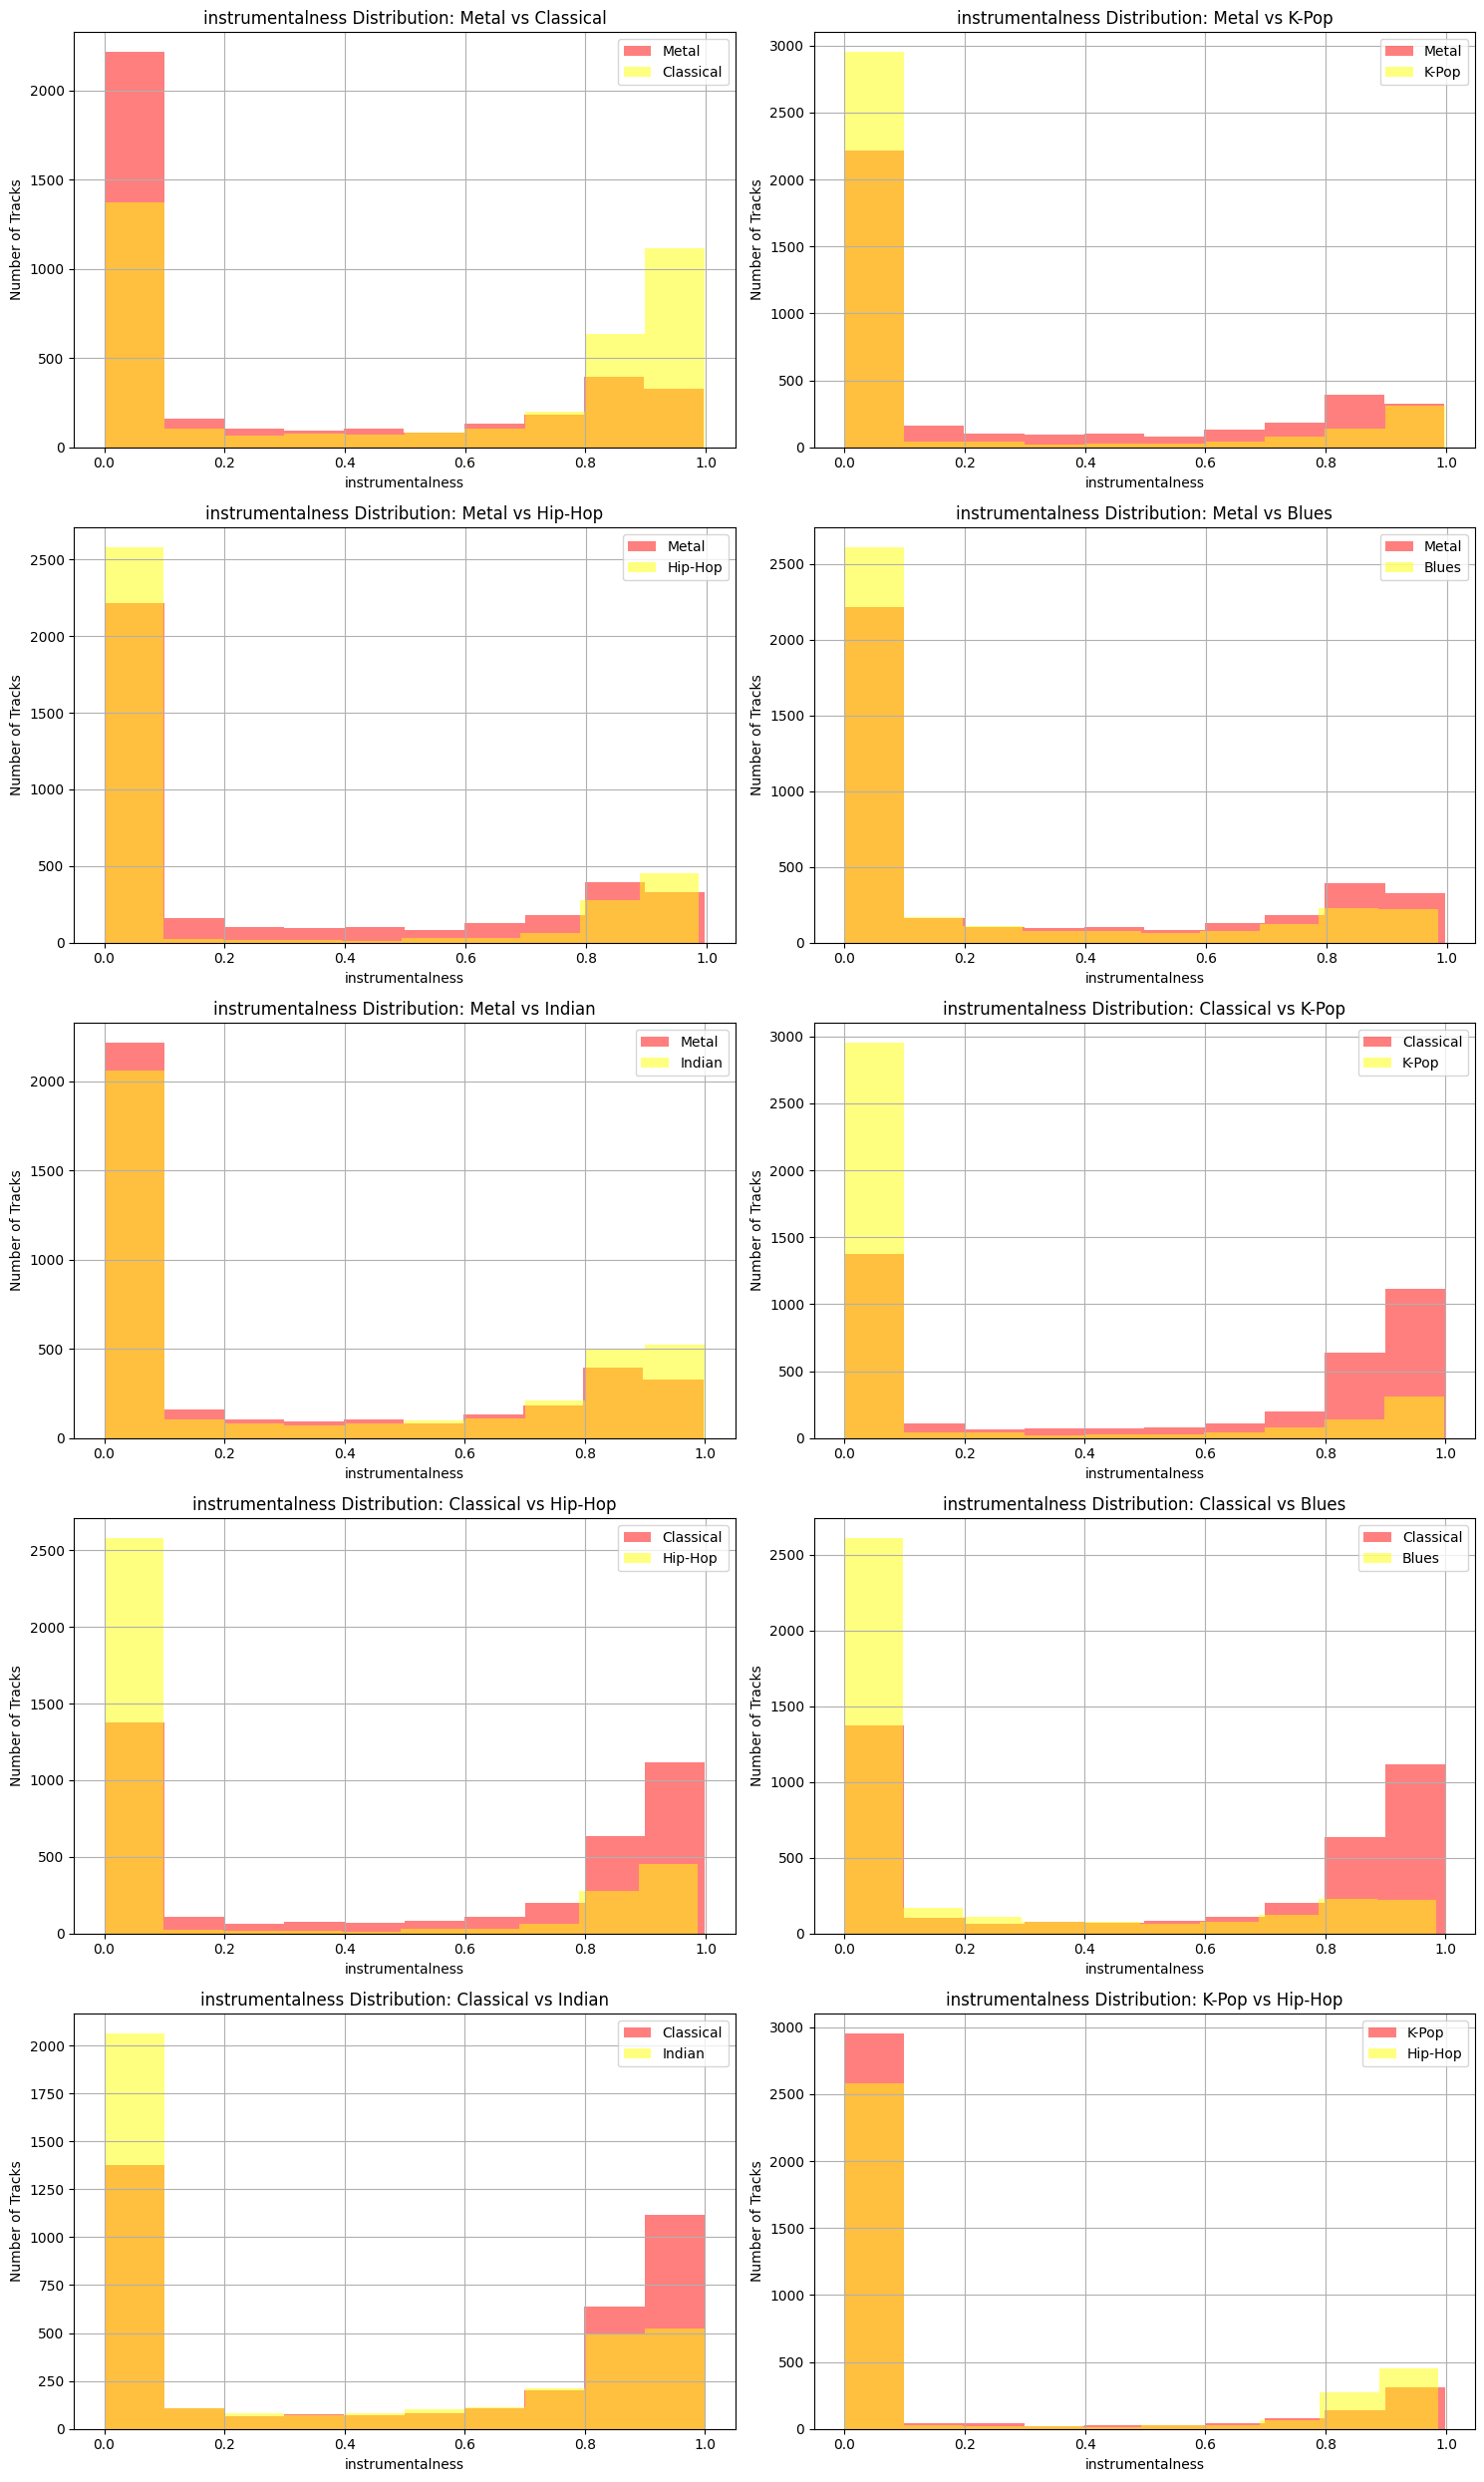

In [34]:
# instrumentalness
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    ax.hist(genres_data[genre1]['instrumentalness'], bins=10, alpha=0.5, label=genre1, color='red')
    ax.hist(genres_data[genre2]['instrumentalness'], bins=10, alpha=0.5, label=genre2, color='yellow')
    ax.set_title(f'instrumentalness Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('instrumentalness')
    ax.set_ylabel('Number of Tracks')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

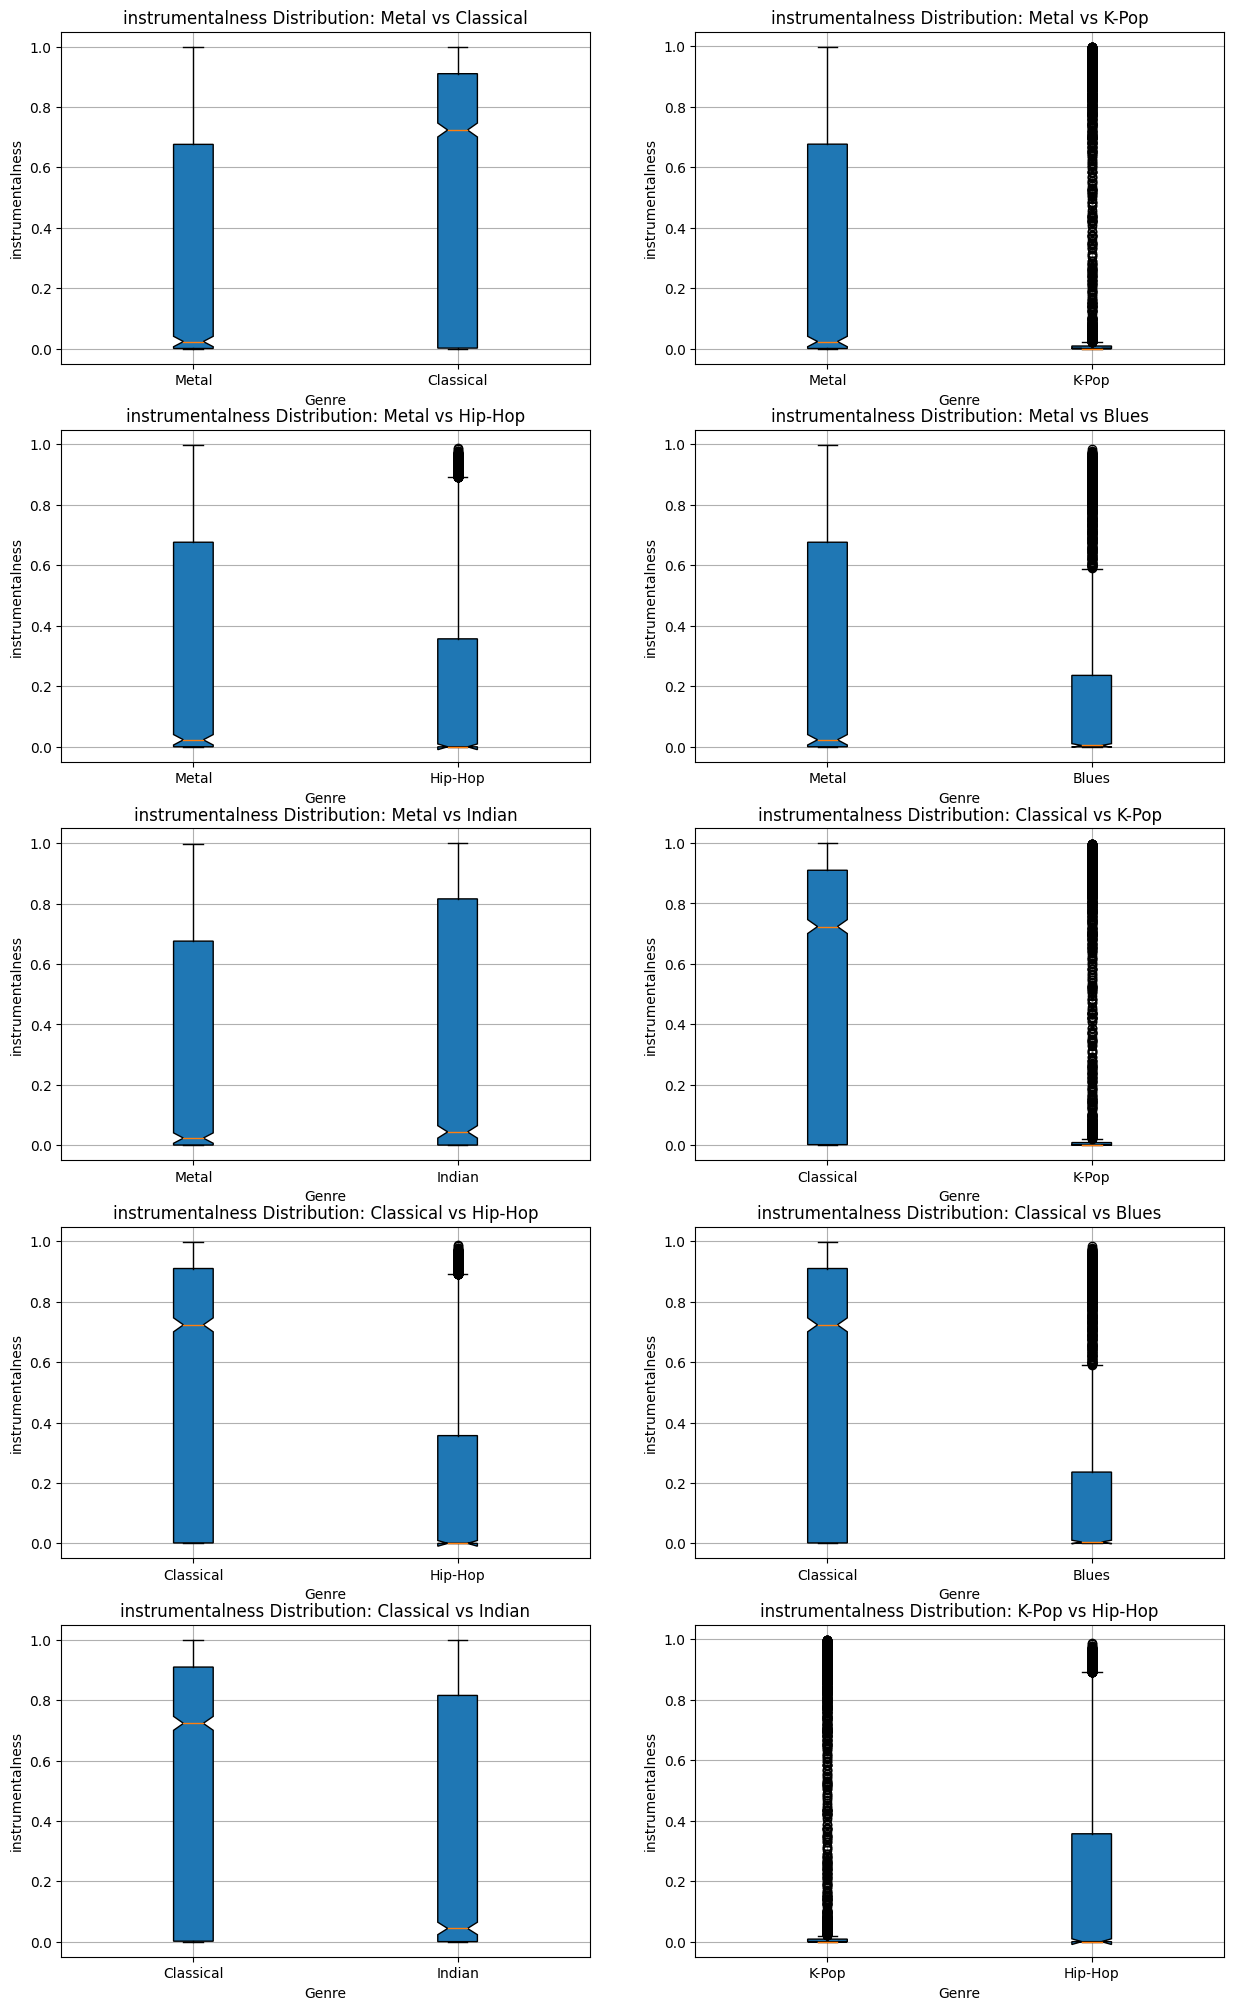

In [35]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    data_to_plot = [genres_data[genre1]['instrumentalness'], genres_data[genre2]['instrumentalness']]
    ax.boxplot(data_to_plot, labels=[genre1, genre2], notch=True, patch_artist=True)
    ax.set_title(f'instrumentalness Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('Genre')
    ax.set_ylabel('instrumentalness')
    ax.grid(True)

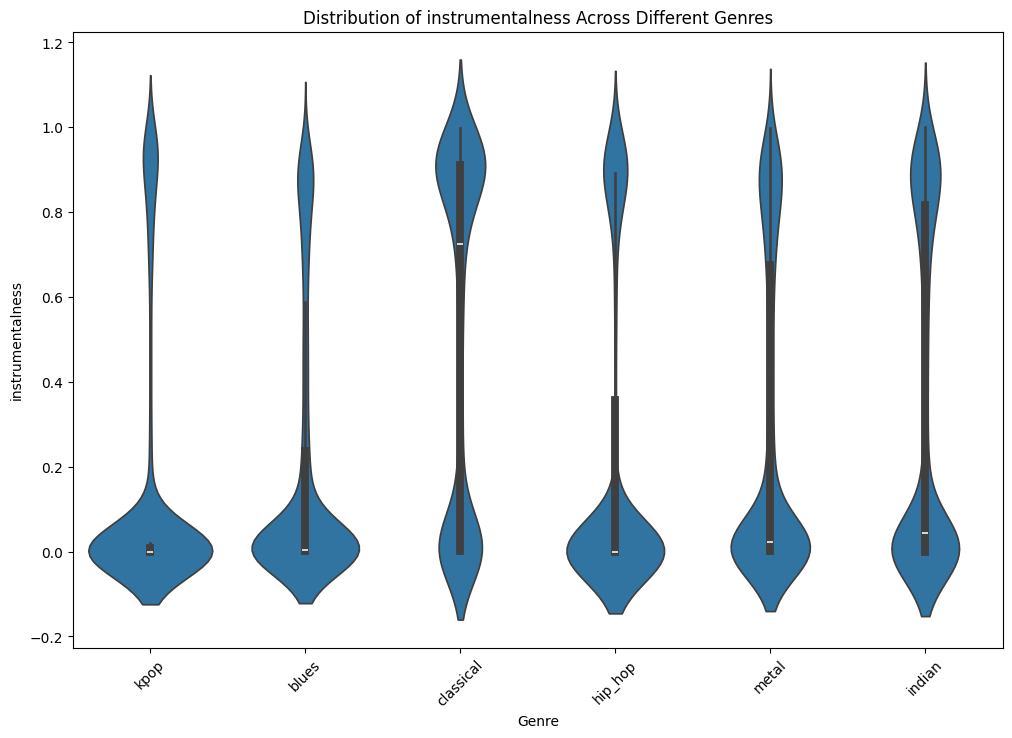

In [29]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='genre_track', y='instrumentalness', data=data)
plt.title('Distribution of instrumentalness Across Different Genres')
plt.xlabel('Genre')
plt.ylabel('instrumentalness')
plt.xticks(rotation=45)
plt.show()

Высокая инструментальность:
Classical жанр выделяется самыми высокими значениями инструментальности, что соответствует преобладанию инструментальной музыки в классической музыке.

Низкая инструментальность:
Жанры Hip-Hop и K-pop демонстрируют очень низкие уровни инструментальности, что отражает их сильный фокус на вокале и речевых элементах.

Средняя инструментальность:
Blues и Indian показывают средние уровни инструментальности с разнообразием в распределении, отражающим смешение вокальных и инструментальных компонентов в музыке этих жанров.

Metal, хотя и содержит значительные инструментальные партии, всё же имеет существенный вокальный компонент, что видно из более низких значений инструментальности по сравнению с классической музыкой.

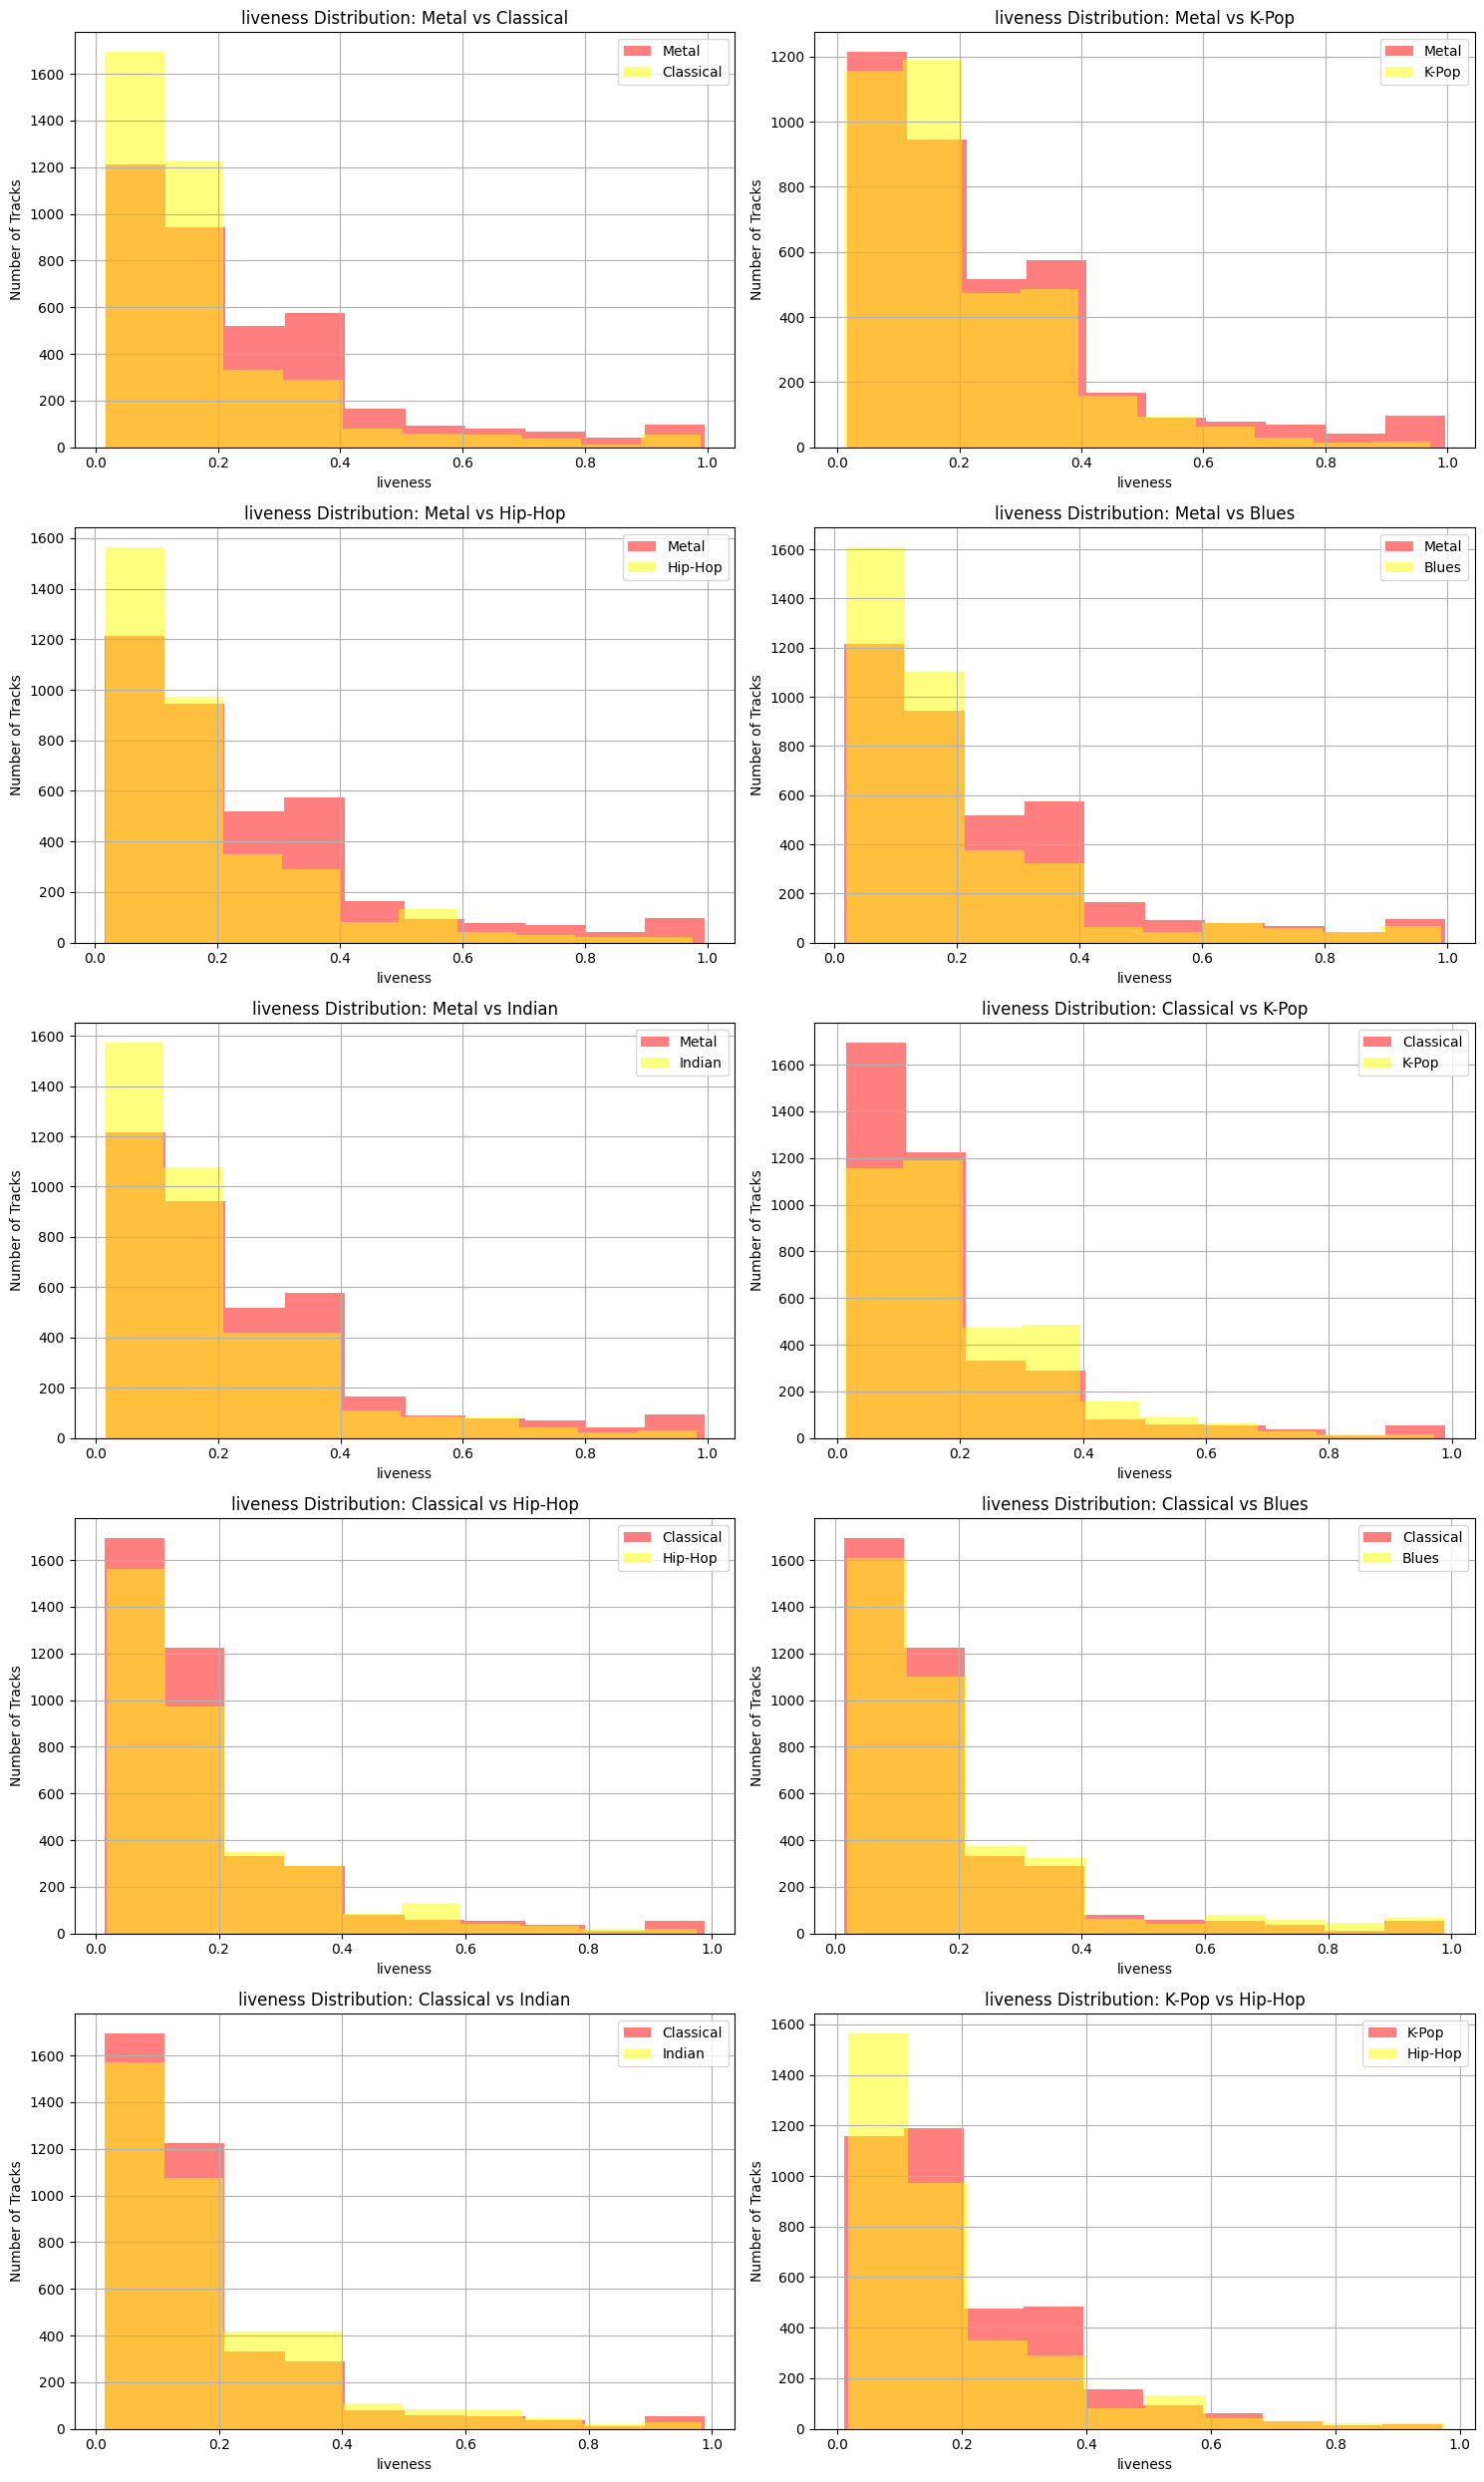

In [36]:
# liveness
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    ax.hist(genres_data[genre1]['liveness'], bins=10, alpha=0.5, label=genre1, color='red')
    ax.hist(genres_data[genre2]['liveness'], bins=10, alpha=0.5, label=genre2, color='yellow')
    ax.set_title(f'liveness Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('liveness')
    ax.set_ylabel('Number of Tracks')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

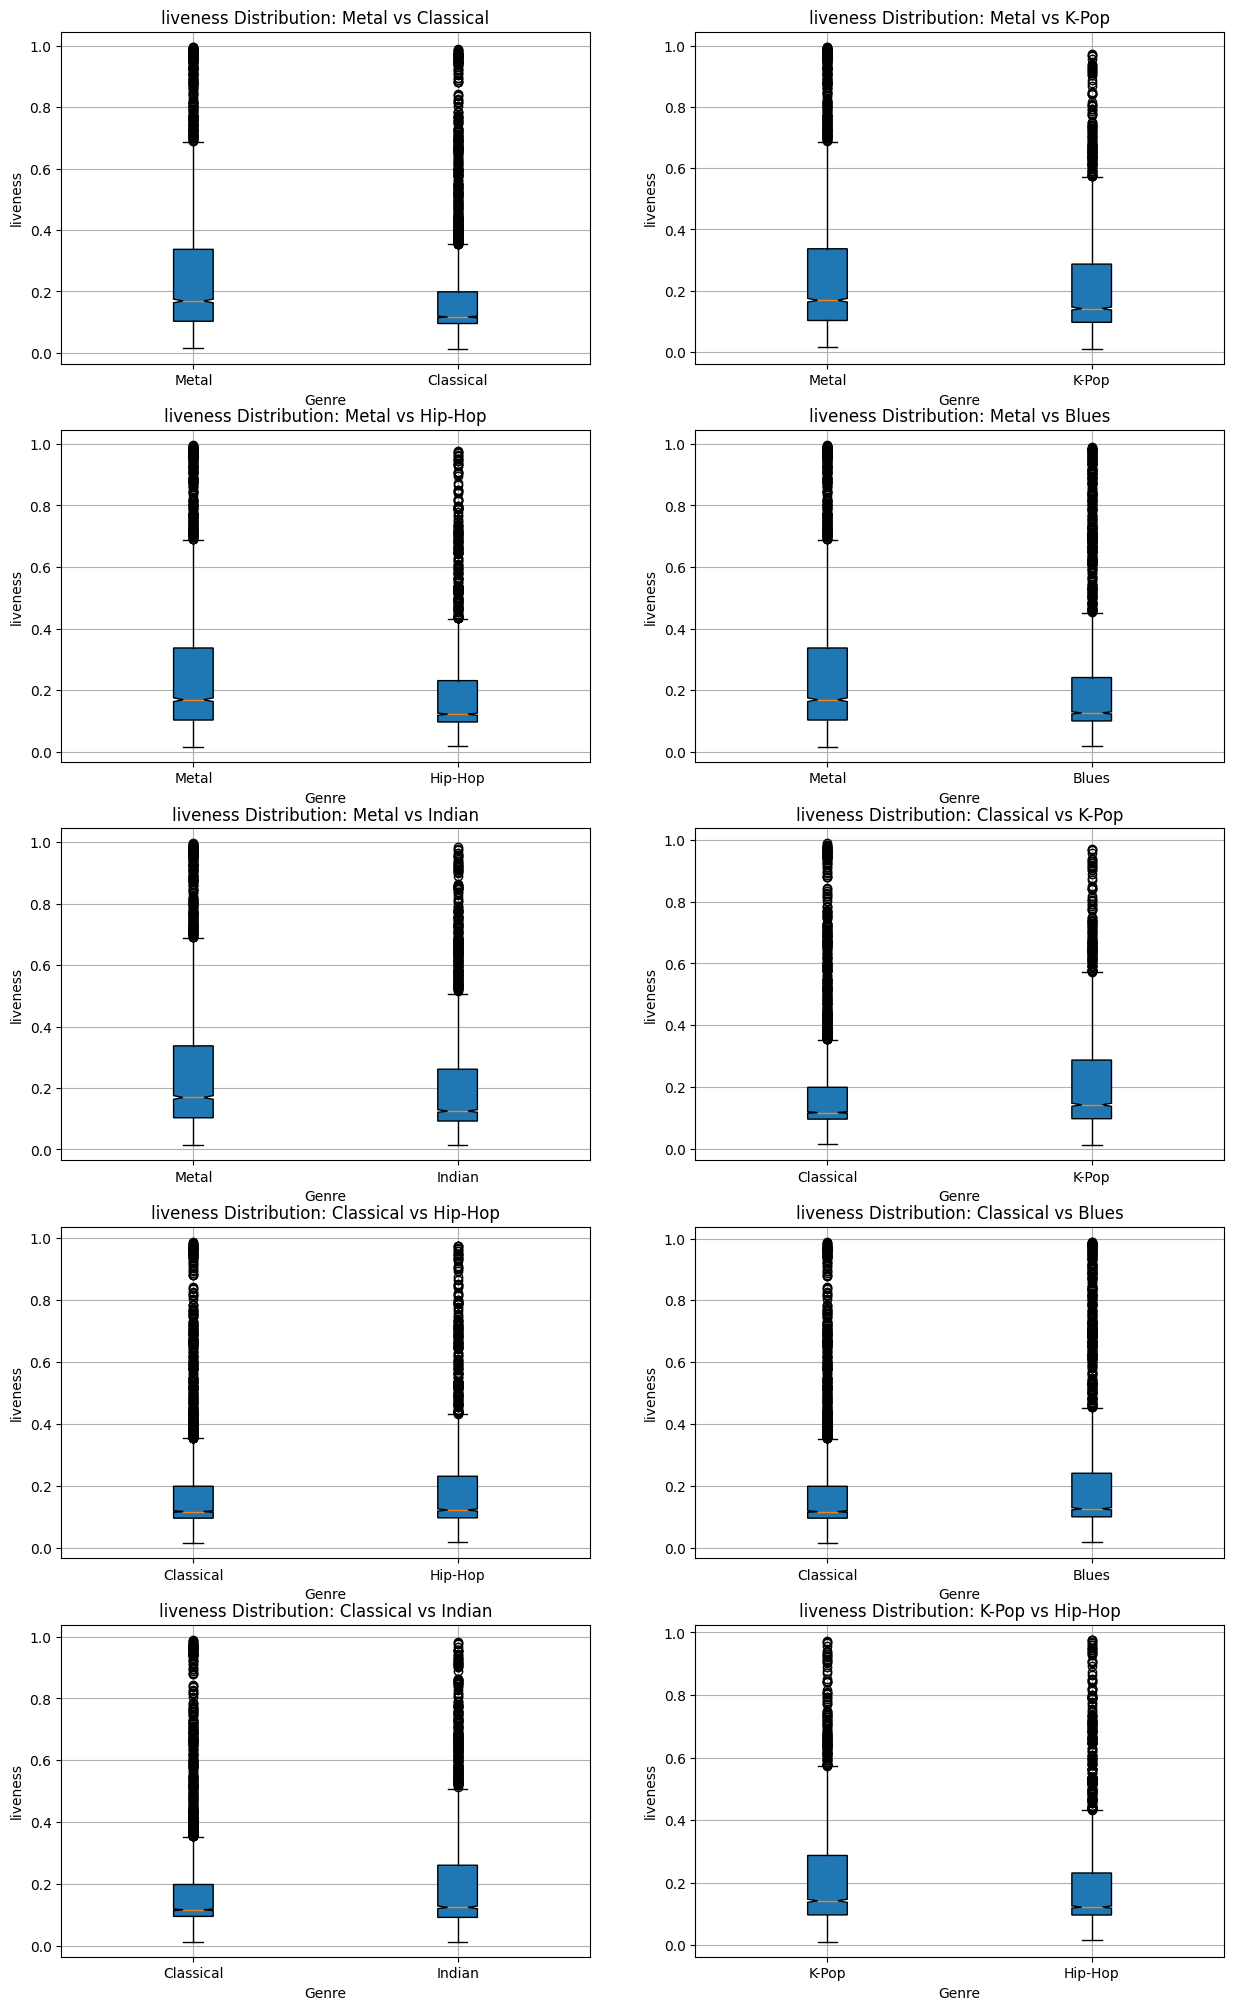

In [37]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    data_to_plot = [genres_data[genre1]['liveness'], genres_data[genre2]['liveness']]
    ax.boxplot(data_to_plot, labels=[genre1, genre2], notch=True, patch_artist=True)
    ax.set_title(f'liveness Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('Genre')
    ax.set_ylabel('liveness')
    ax.grid(True)

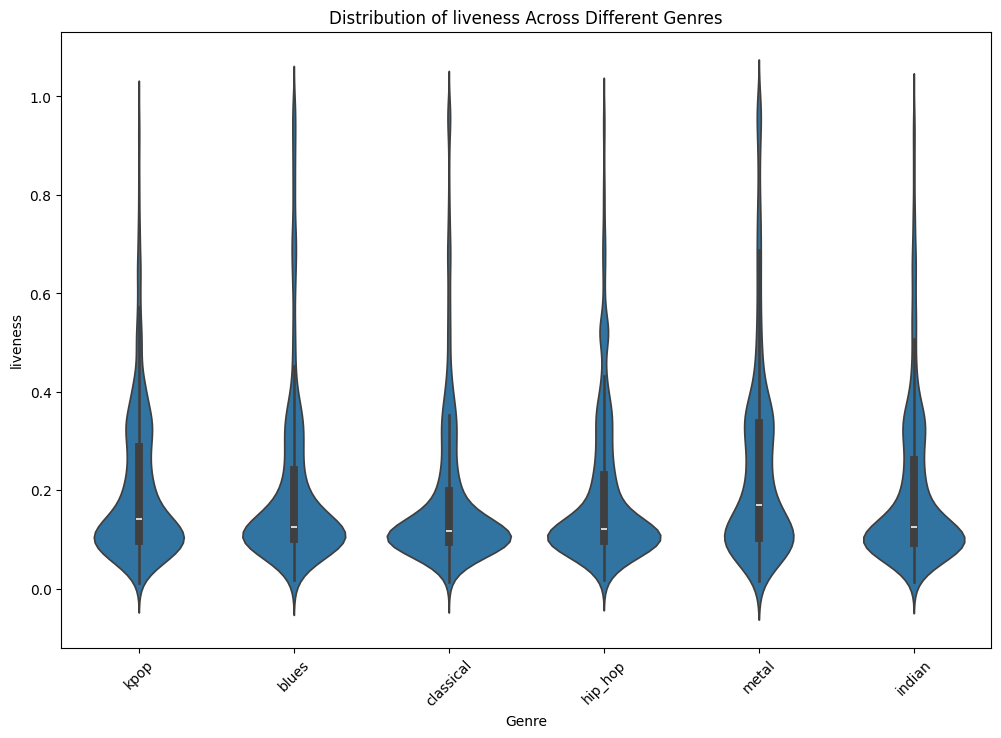

In [30]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='genre_track', y='liveness', data=data)
plt.title('Distribution of liveness Across Different Genres')
plt.xlabel('Genre')
plt.ylabel('liveness')
plt.xticks(rotation=45)
plt.show()

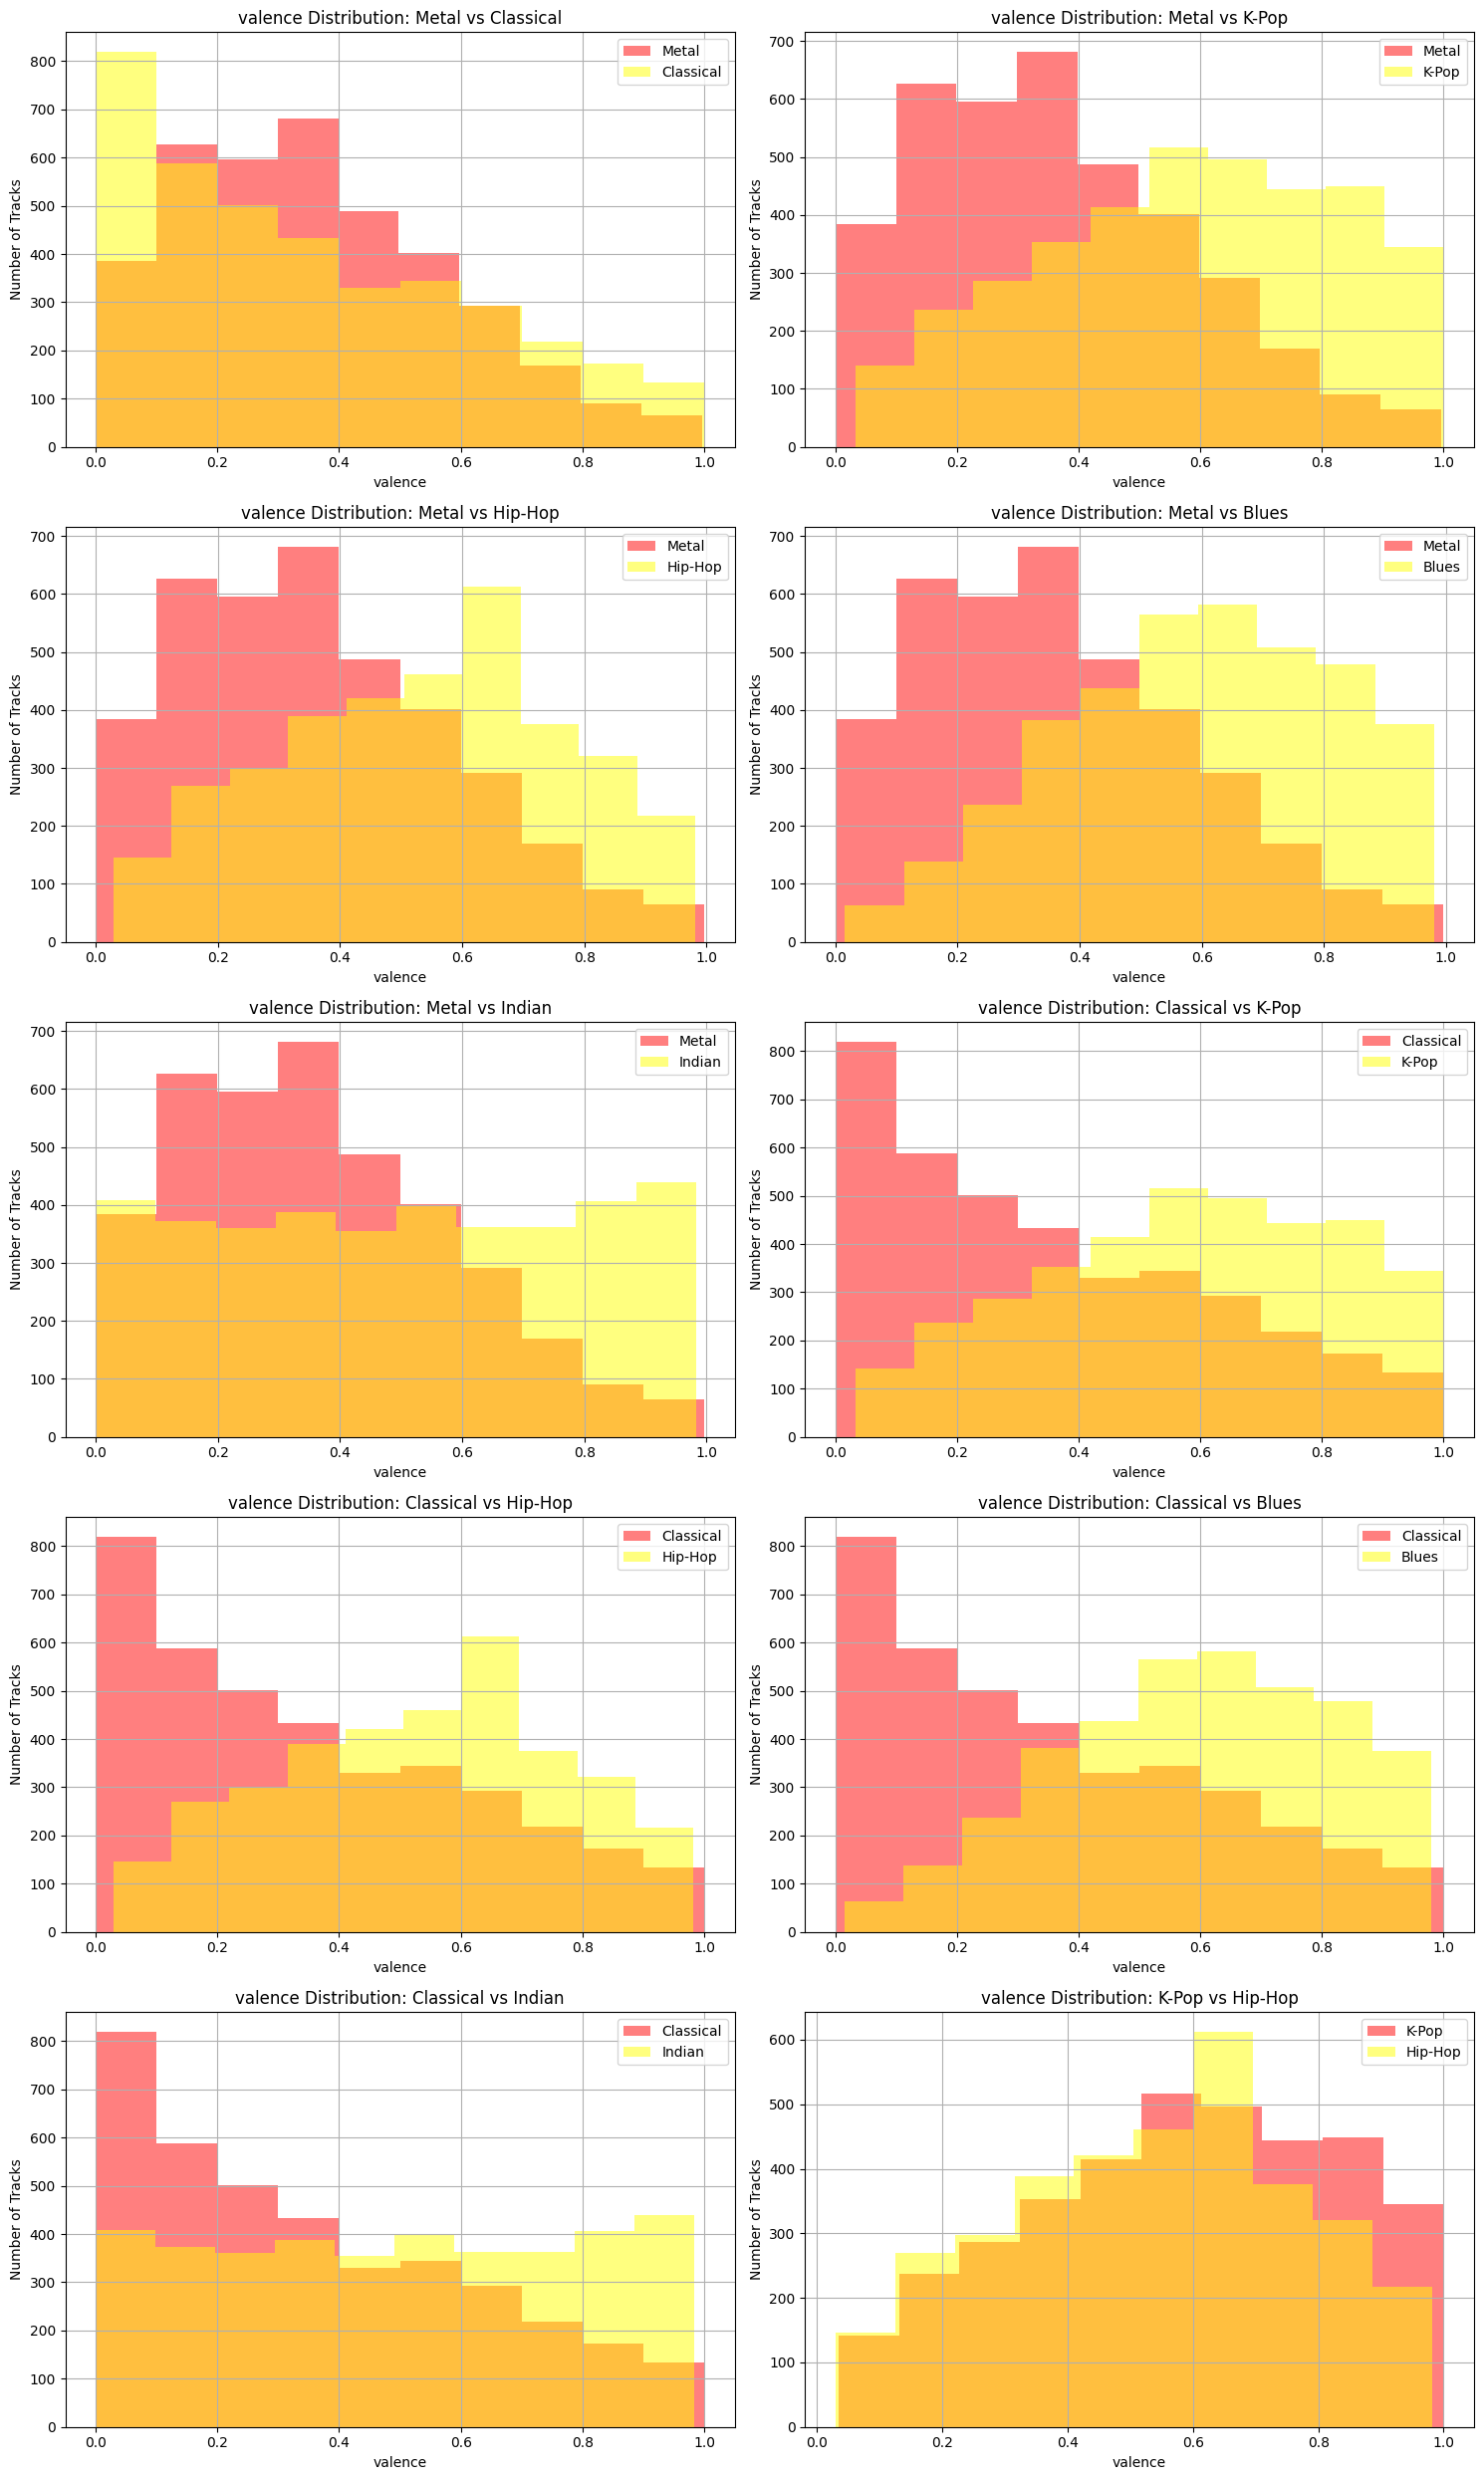

In [38]:
# valence
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    ax.hist(genres_data[genre1]['valence'], bins=10, alpha=0.5, label=genre1, color='red')
    ax.hist(genres_data[genre2]['valence'], bins=10, alpha=0.5, label=genre2, color='yellow')
    ax.set_title(f'valence Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('valence')
    ax.set_ylabel('Number of Tracks')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

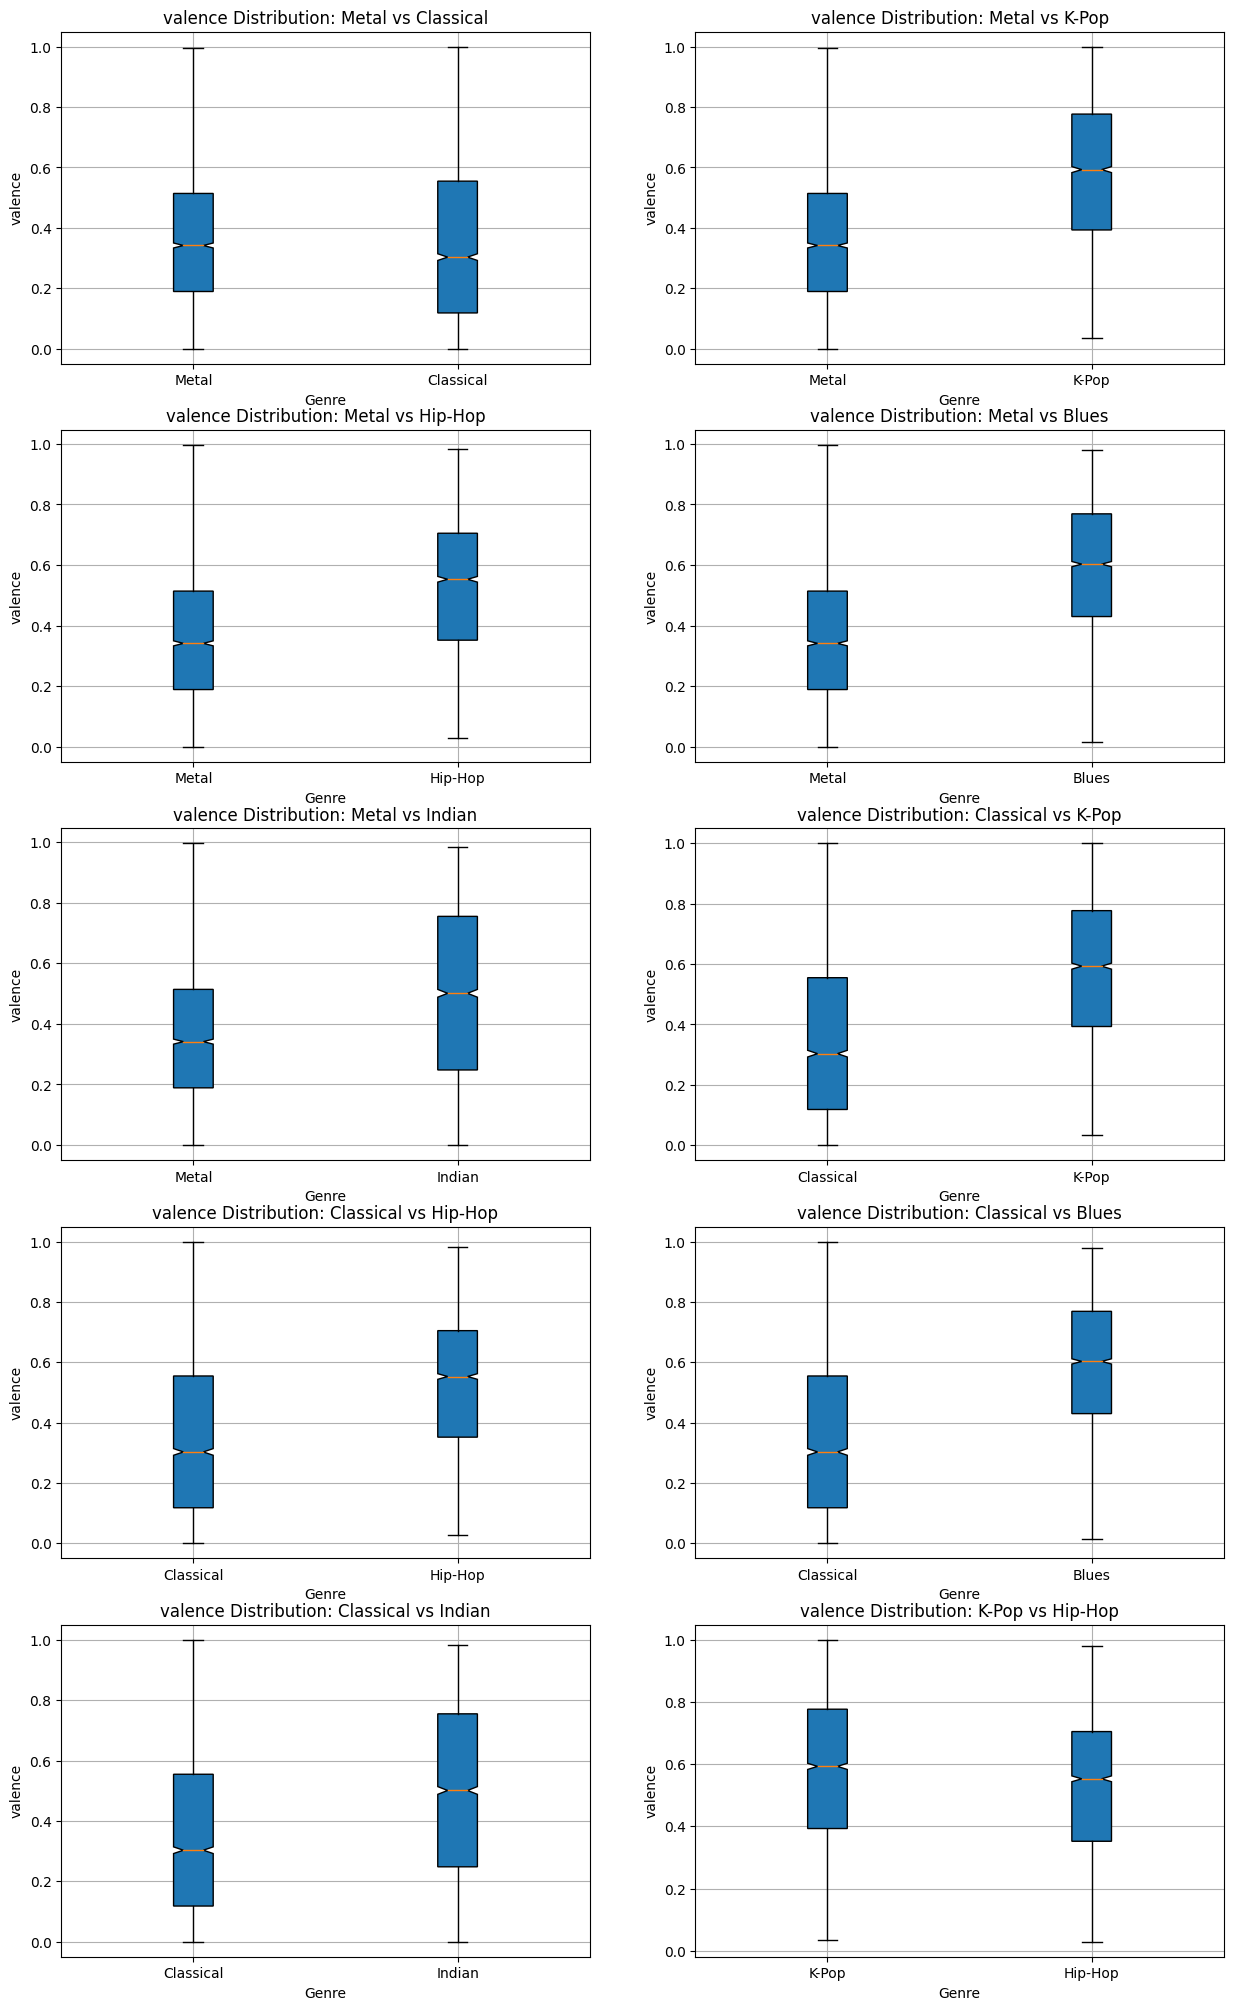

In [39]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    data_to_plot = [genres_data[genre1]['valence'], genres_data[genre2]['valence']]
    ax.boxplot(data_to_plot, labels=[genre1, genre2], notch=True, patch_artist=True)
    ax.set_title(f'valence Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('Genre')
    ax.set_ylabel('valence')
    ax.grid(True)

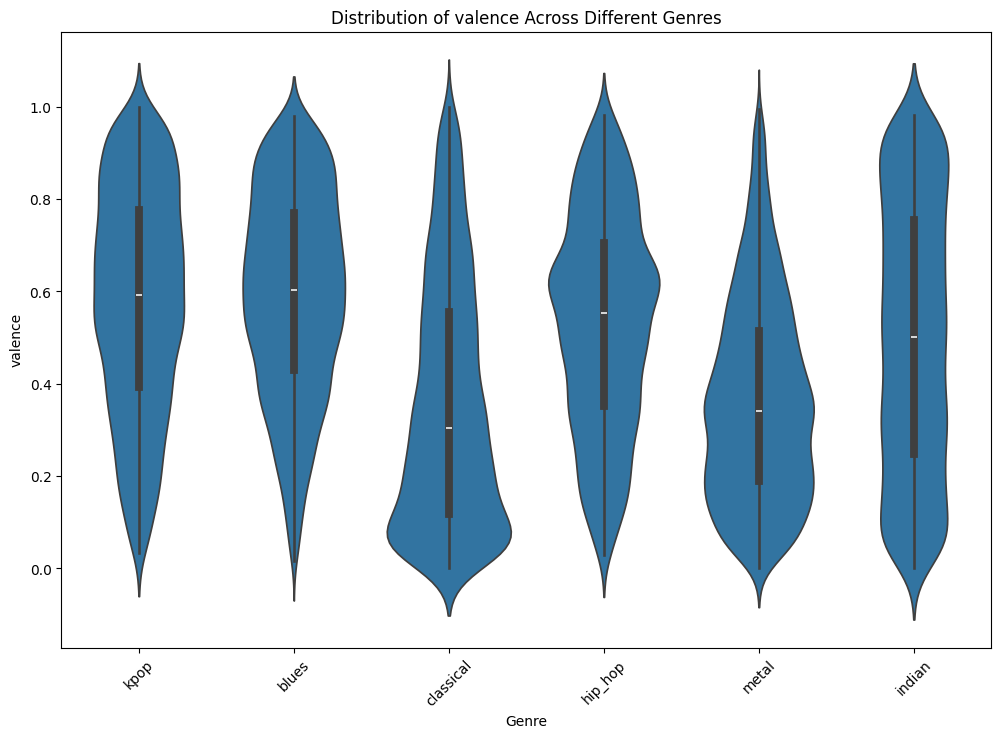

In [31]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='genre_track', y='valence', data=data)
plt.title('Distribution of valence Across Different Genres')
plt.xlabel('Genre')
plt.ylabel('valence')
plt.xticks(rotation=45)
plt.show()

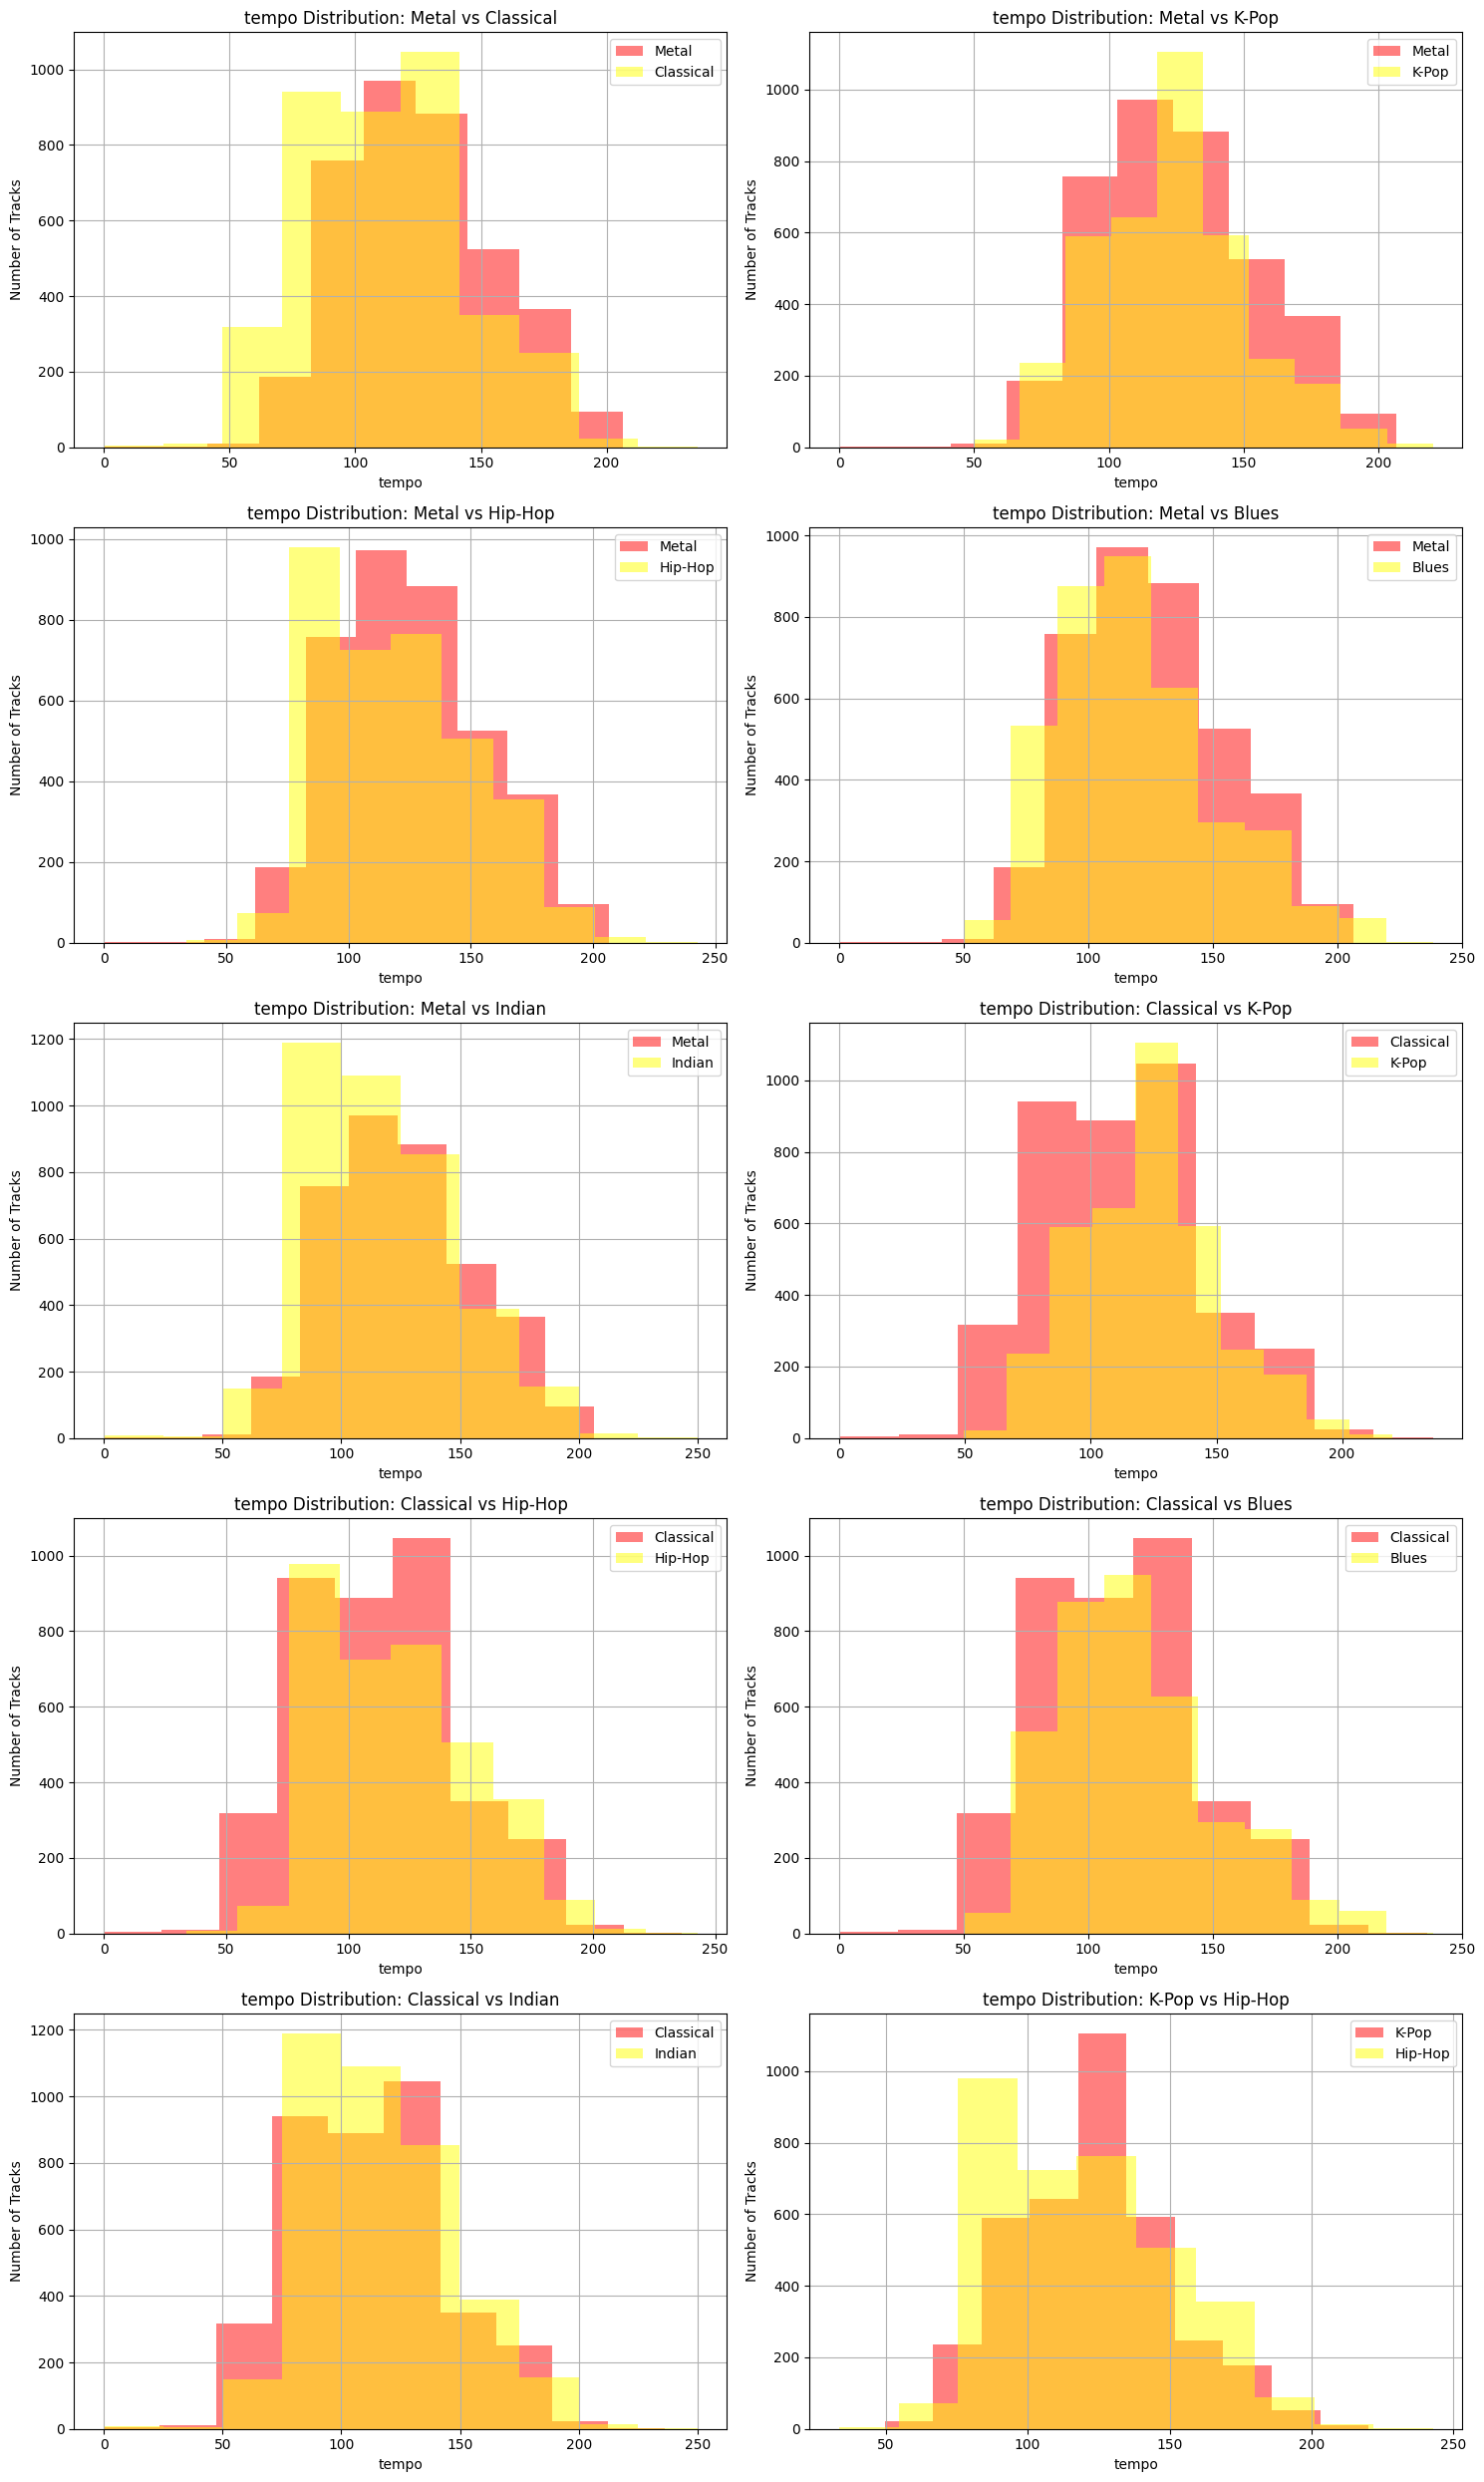

In [40]:
# tempo
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    ax.hist(genres_data[genre1]['tempo'], bins=10, alpha=0.5, label=genre1, color='red')
    ax.hist(genres_data[genre2]['tempo'], bins=10, alpha=0.5, label=genre2, color='yellow')
    ax.set_title(f'tempo Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('tempo')
    ax.set_ylabel('Number of Tracks')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

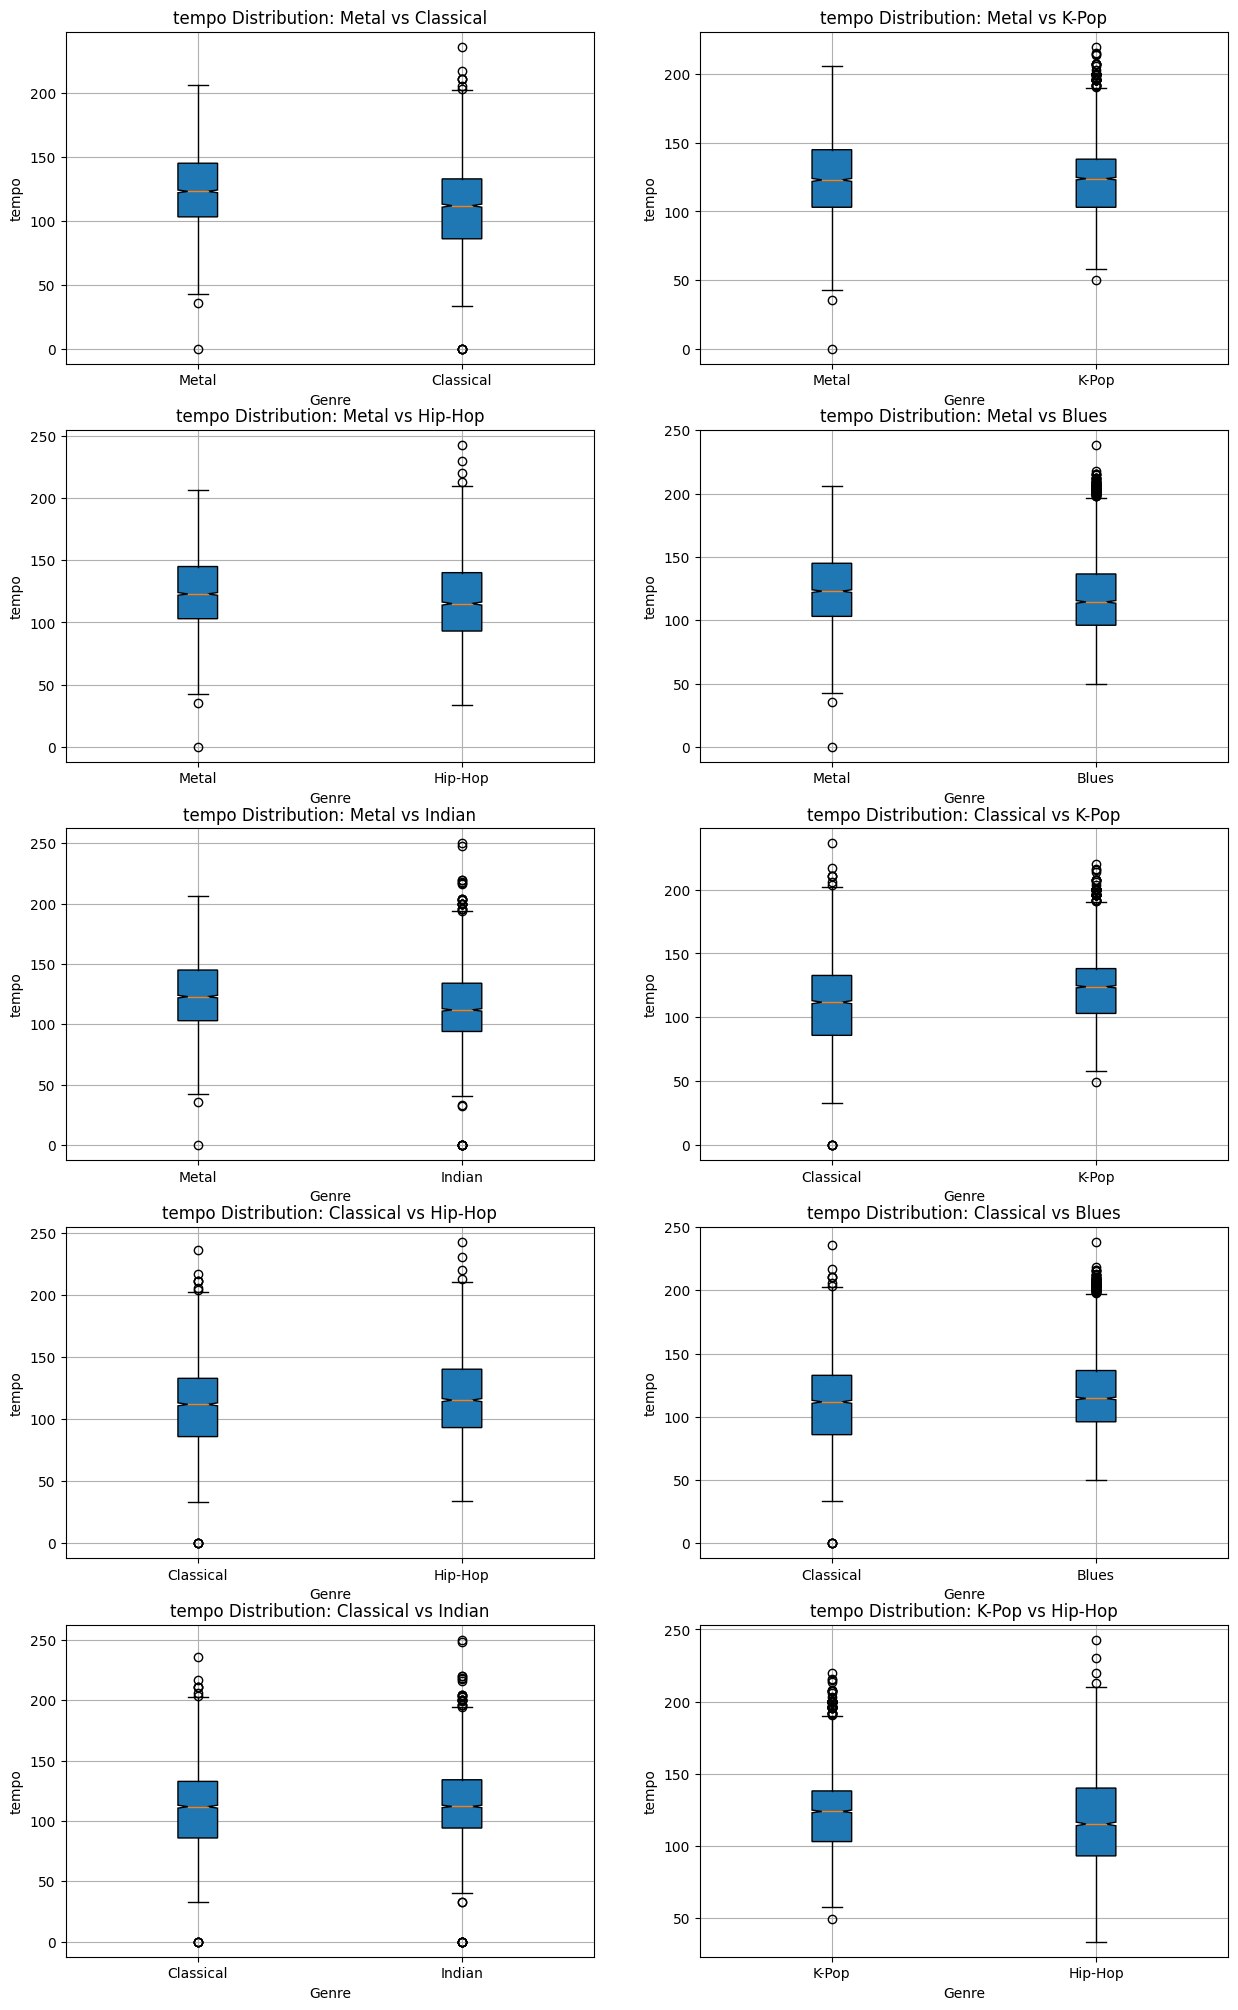

In [41]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    data_to_plot = [genres_data[genre1]['tempo'], genres_data[genre2]['tempo']]
    ax.boxplot(data_to_plot, labels=[genre1, genre2], notch=True, patch_artist=True)
    ax.set_title(f'tempo Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('Genre')
    ax.set_ylabel('tempo')
    ax.grid(True)

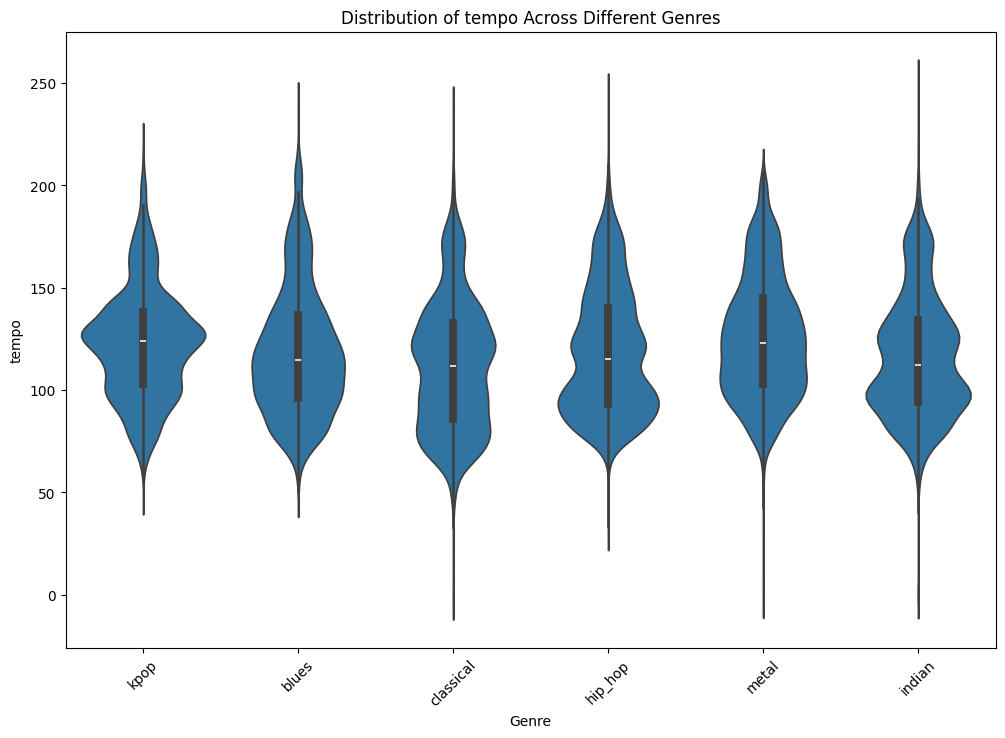

In [32]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='genre_track', y='tempo', data=data)
plt.title('Distribution of tempo Across Different Genres')
plt.xlabel('Genre')
plt.ylabel('tempo')
plt.xticks(rotation=45)
plt.show()

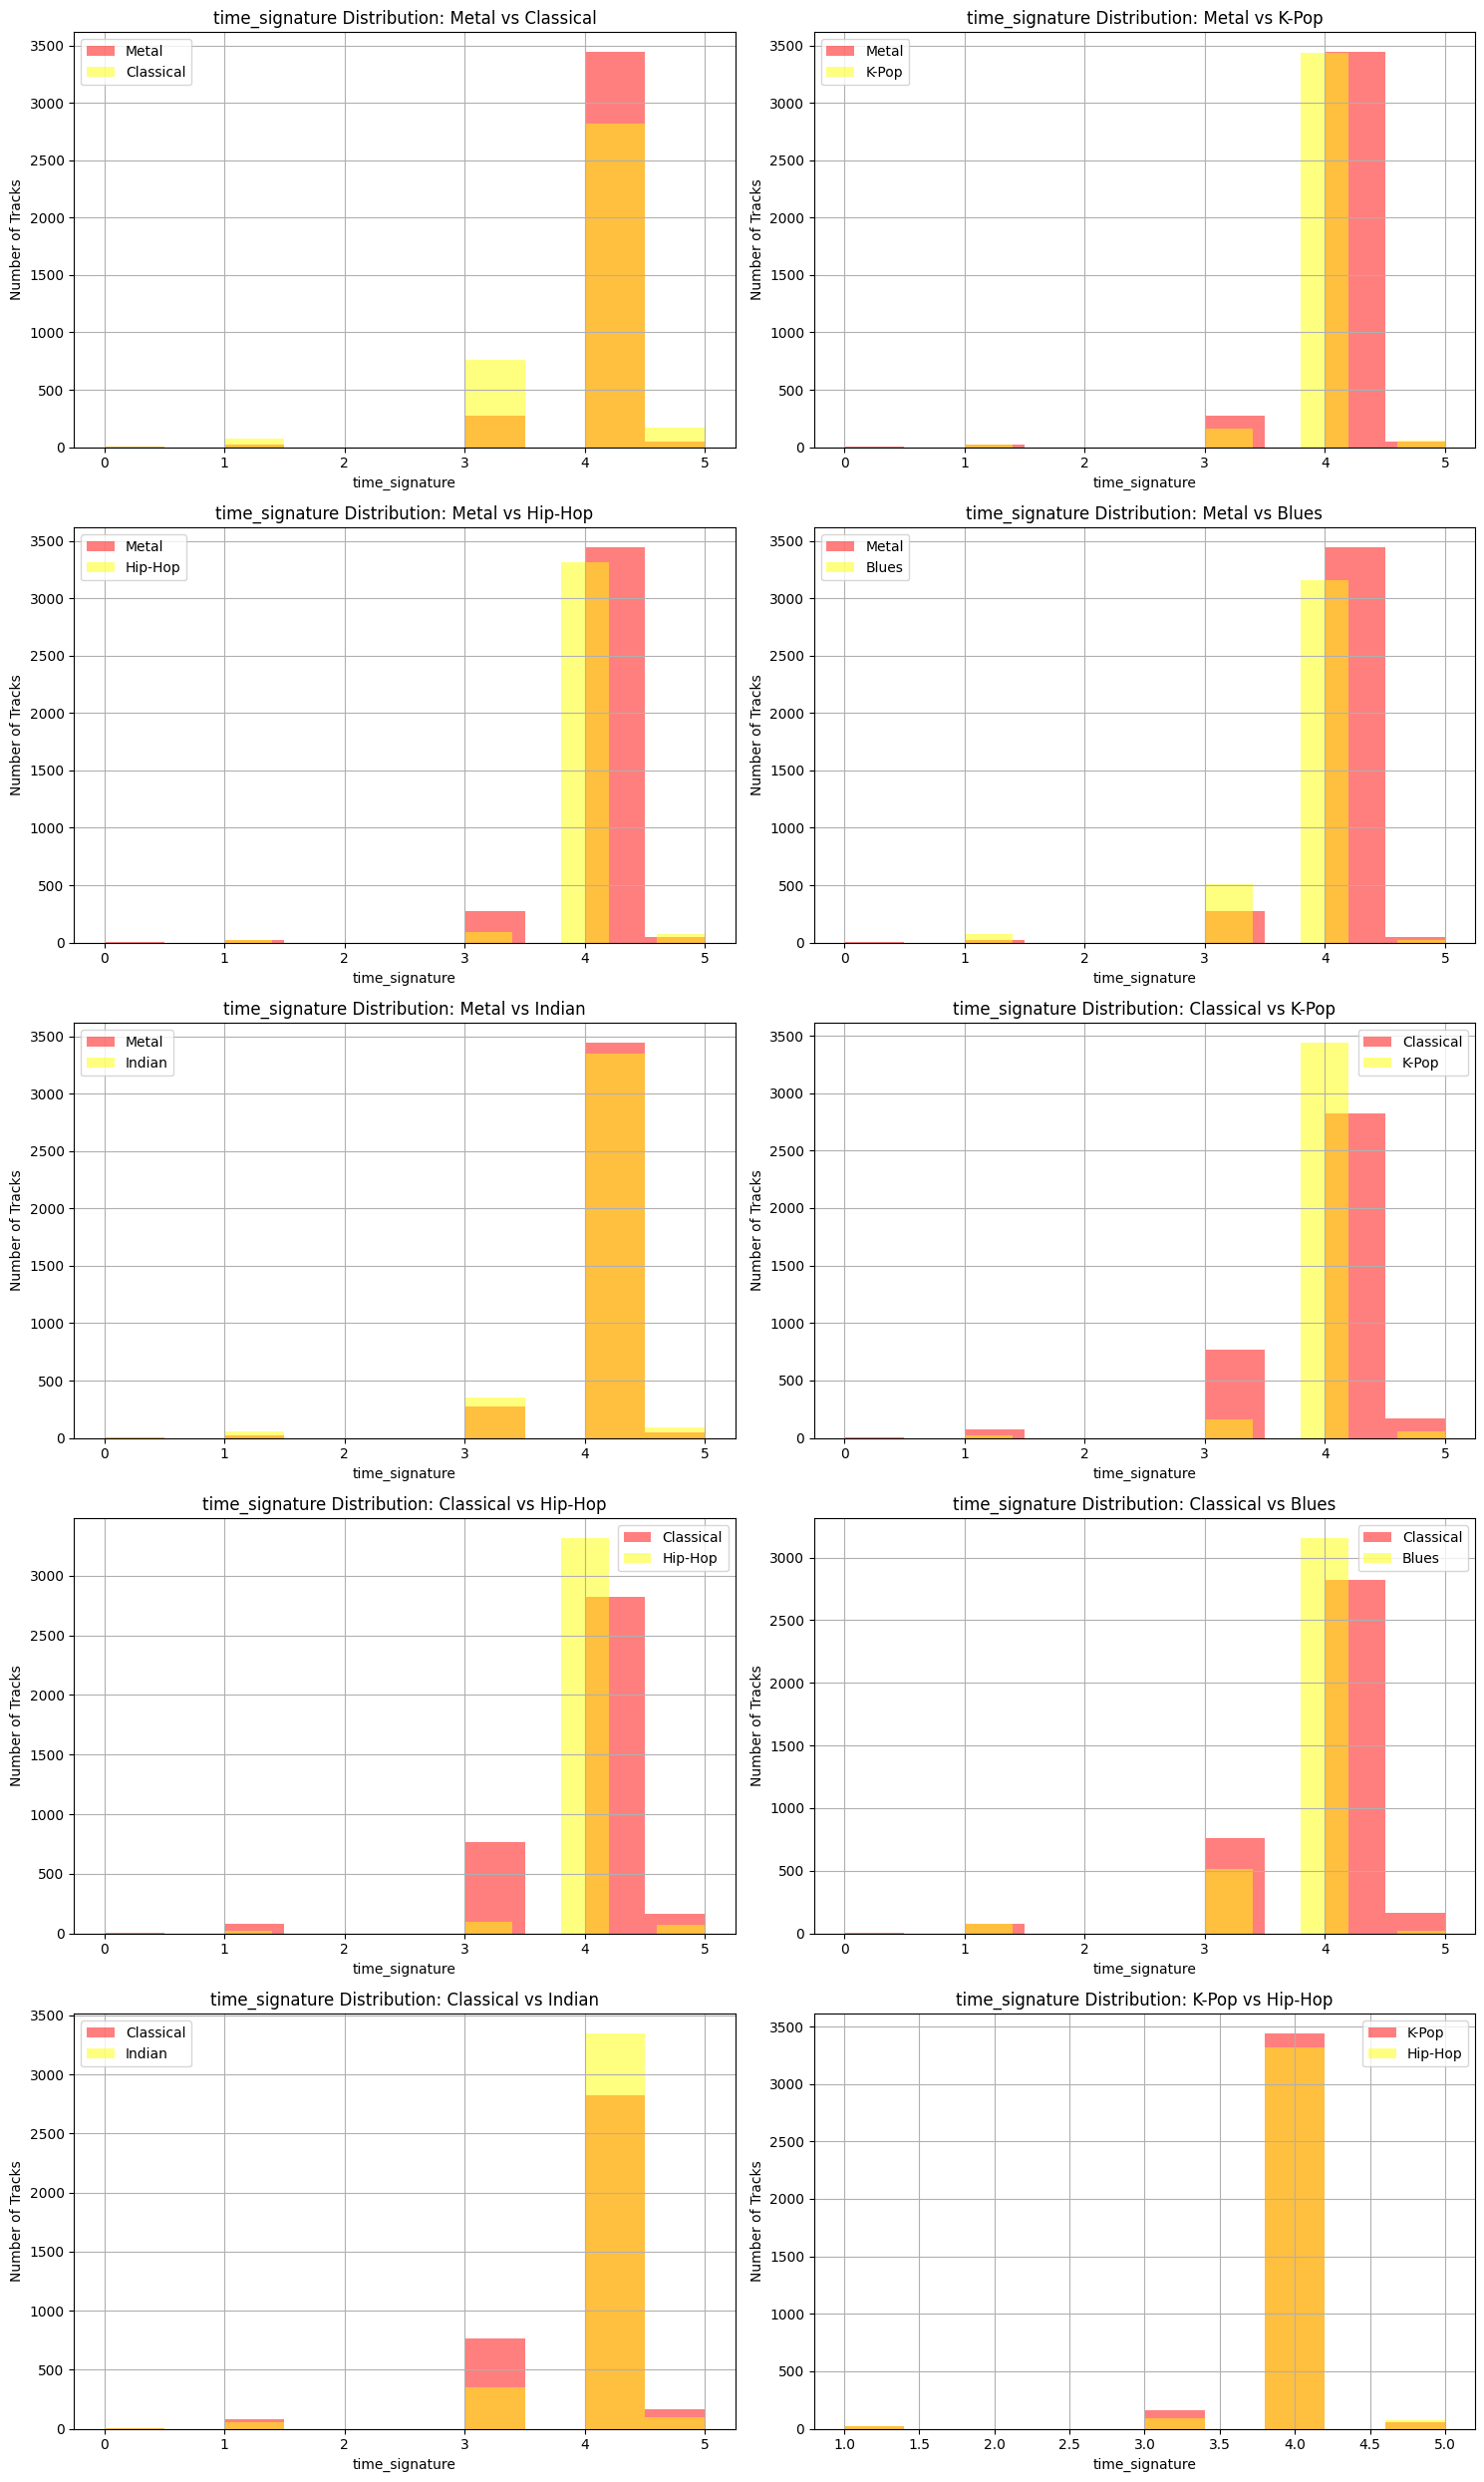

In [42]:
# time_signature
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    ax.hist(genres_data[genre1]['time_signature'], bins=10, alpha=0.5, label=genre1, color='red')
    ax.hist(genres_data[genre2]['time_signature'], bins=10, alpha=0.5, label=genre2, color='yellow')
    ax.set_title(f'time_signature Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('time_signature')
    ax.set_ylabel('Number of Tracks')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

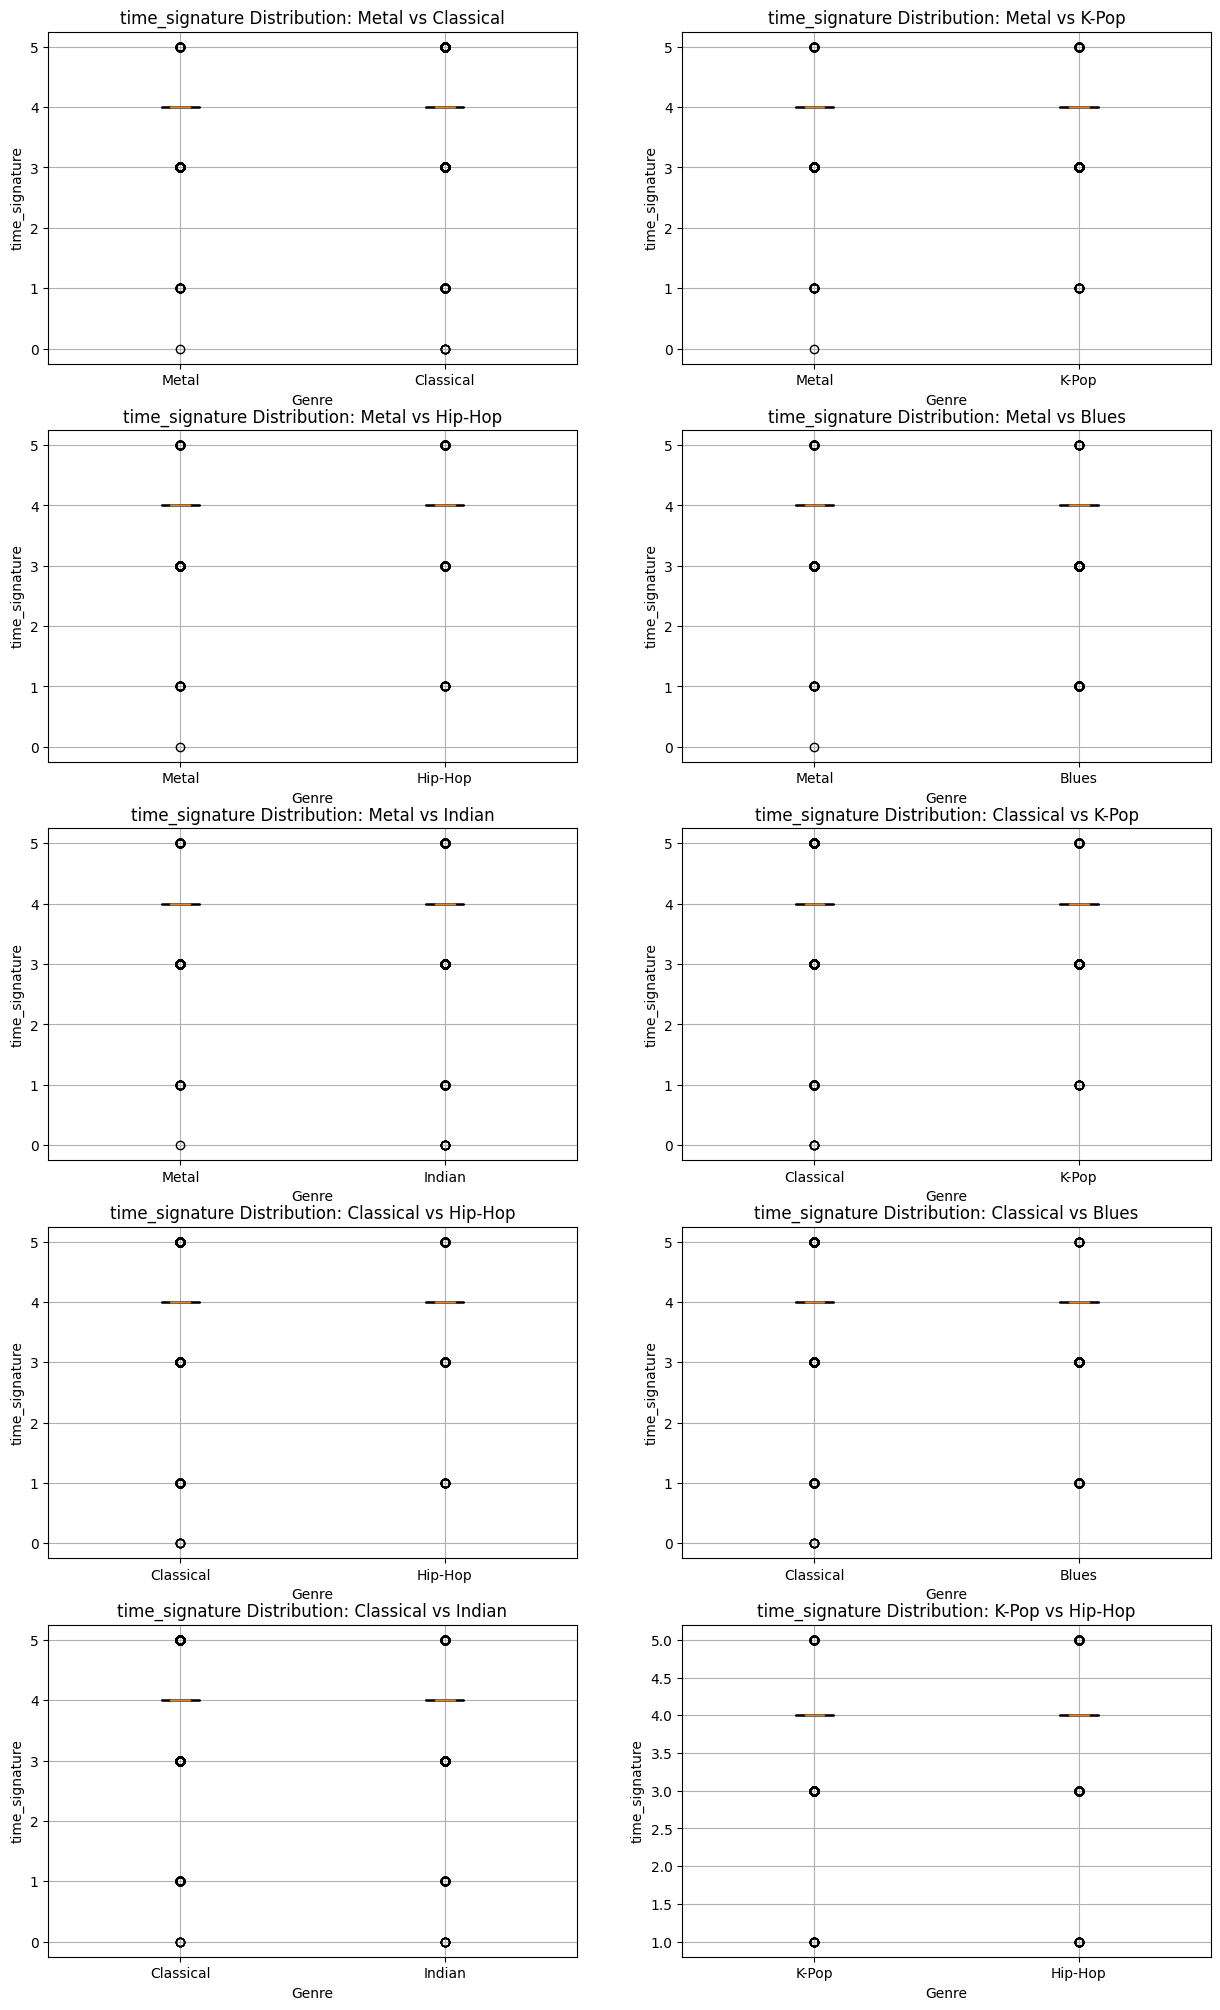

In [43]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for ax, (genre1, genre2) in zip(axs.flat, genre_pairs):
    data_to_plot = [genres_data[genre1]['time_signature'], genres_data[genre2]['time_signature']]
    ax.boxplot(data_to_plot, labels=[genre1, genre2], notch=True, patch_artist=True)
    ax.set_title(f'time_signature Distribution: {genre1} vs {genre2}')
    ax.set_xlabel('Genre')
    ax.set_ylabel('time_signature')
    ax.grid(True)

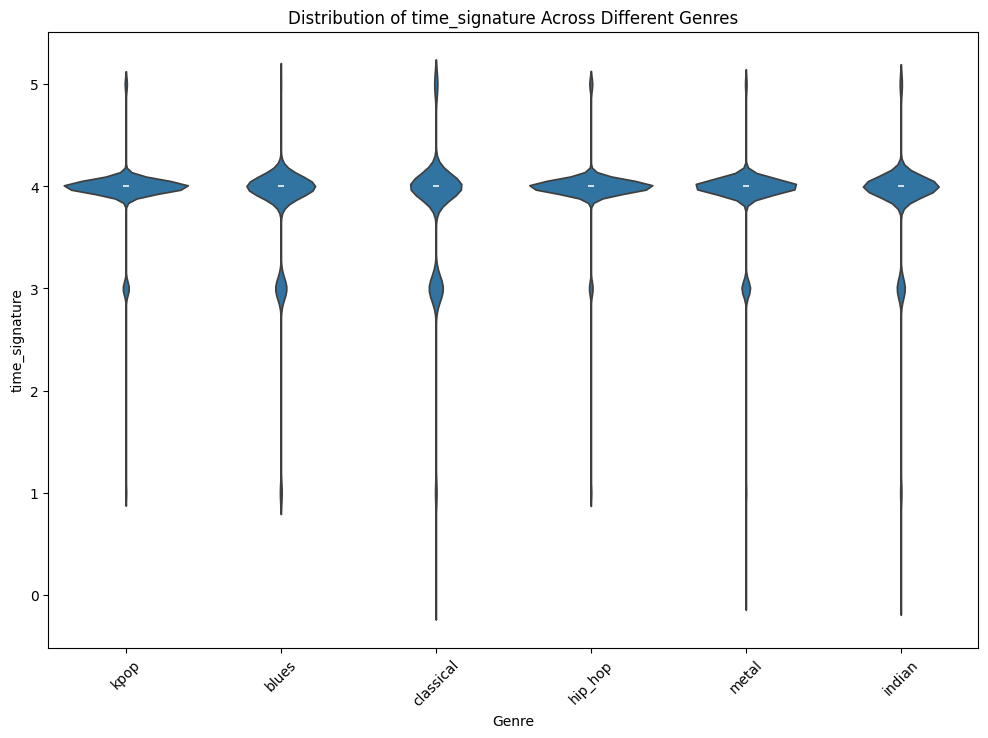

In [33]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='genre_track', y='time_signature', data=data)
plt.title('Distribution of time_signature Across Different Genres')
plt.xlabel('Genre')
plt.ylabel('time_signature')
plt.xticks(rotation=45)
plt.show()

In [7]:
# Словарь замены
replacement_dict1 = {
    'kpop': 1,
    'indian': 2,
    'metal': 3,
    'hip_hop': 4,
    'classical': 5,
    'blues': 6
}

replacement_dict2 = {
    True: 1,
    False: 2
}

data['genre_track'] = data['genre_track'].replace(replacement_dict1)
data['explicit'] = data['explicit'].replace(replacement_dict2)

data

track_id  genre_track  duration_ms  explicit  \
0      162MHwMBYufdE5jyoRobTo            1     228880.0         2   
1      517RaXryInkI9MstFWUDkz            1     190512.0         2   
2      0nvFEQ9DrRrj8wYZfIsSm7            1      35236.0         2   
3      4sg4n7YCHA013vqSzY6t6t            1     182000.0         2   
4      2dOO2z1VZF9bNHoLkG5qEw            1     219506.0         2   
...                       ...          ...          ...       ...   
22435  0D7cOLQsjXY9jPkunN84JC            2     279773.0         2   
22436  0mftTi05eeOQnZ178jZruN            2     300520.0         2   
22437  74klMBiApXASzNAboLR5Xu            2     234000.0         2   
22438  7Gn1H85ok0b2eXYwfgw8C0            2     179266.0         2   
22439  5S53GEeJbsii8Idew95Wrg            2    1799131.0         2   

       danceability  energy   key  loudness  mode  speechiness  acousticness  \
0             0.885  0.9420   1.0    -0.548   0.0       0.0798        0.1770   
1             0.331  0.5320   1.0    -5.119   1.0       0.0416        0.5780   
2             0.748  0.5010   7.0   -12.613   1.0       0.0593        0.0313   
3             0.627  0.8650   5.0    -4.241   1.0       0.0457        0.0025   
4             0.703  0.7870   6.0    -5.058   1.0       0.6290        0.2340   
...             ...     ...   ...       ...   ...          ...           ...   
22435         0.200  0.2270  10.0   -16.243   0.0       0.0375        0.9120   
22436         0.648  0.5350  10.0   -10.505   1.0       0.0561        0.3650   
22437         0.118  0.0602   6.0   -27.248   0.0       0.0432        0.9860   
22438         0.200  0.1330   6.0   -21.504   1.0       0.0407        0.8560   
22439         0.442  0.3610  11.0   -15.399   1.0       0.0598        0.9750   

       instrumentalness  liveness  valence    tempo  time_signature  
0                 0.000    0.1150   0.9370  114.994             4.0  
1                 0.000    0.1130   0.0412  134.929             4.0  
2                 0.263    0.1410   0.7080  109.010             4.0  
3                 0.000    0.3620   0.3600  106.093             4.0  
4                 0.000    0.4080   0.6620  104.776             4.0  
...                 ...       ...      ...      ...             ...  
22435             0.757    0.3300   0.0681  117.764             1.0  
22436             0.000    0.0779   0.6650  111.974             4.0  
22437             0.952    0.0996   0.2010   66.830             4.0  
22438             0.893    0.3450   0.0383  119.165             1.0  
22439             0.751    0.6910   0.1280  101.801             4.0  

[22440 rows x 16 columns]

<Axes: >

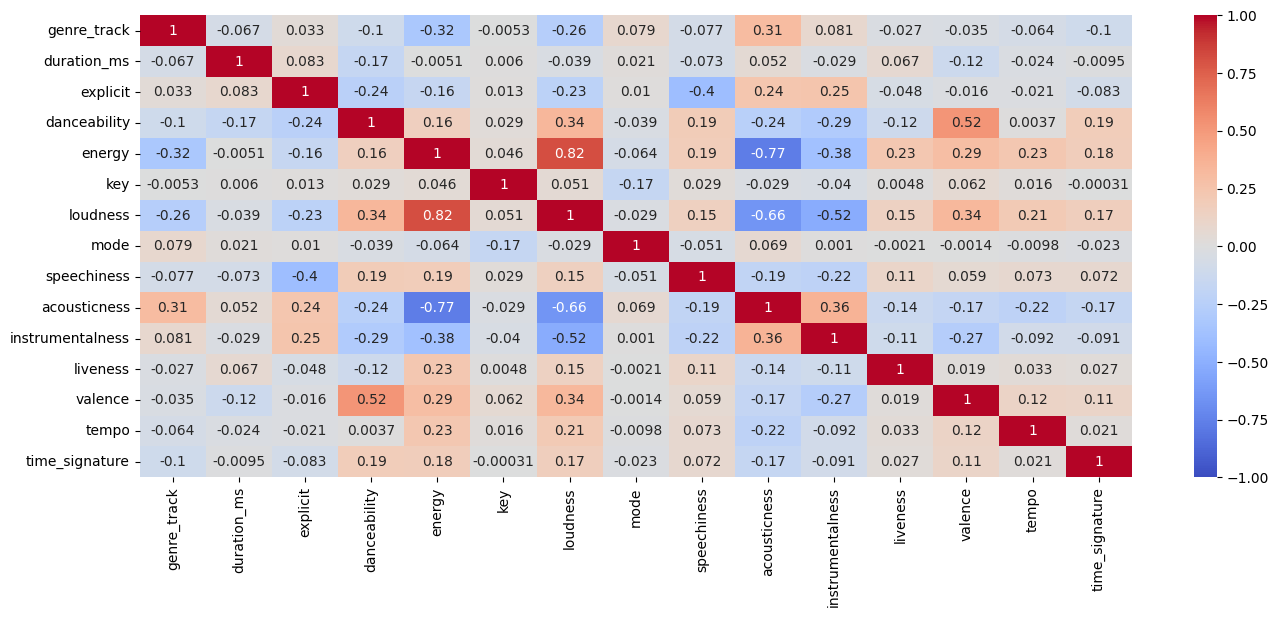

In [7]:
data1 = data.copy()
data1 = data1.drop(columns=['track_id'])

plt.figure(figsize=(16, 6))
sns.heatmap(data = data1.corr(), cmap='coolwarm', vmin = -1, vmax = 1, annot = True)

# Обучение различных моделей

In [8]:
data = data.drop(columns=['track_id'], axis=1)
data

genre_track  duration_ms  explicit  danceability  energy   key  \
0                1     228880.0         2         0.885  0.9420   1.0   
1                1     190512.0         2         0.331  0.5320   1.0   
2                1      35236.0         2         0.748  0.5010   7.0   
3                1     182000.0         2         0.627  0.8650   5.0   
4                1     219506.0         2         0.703  0.7870   6.0   
...            ...          ...       ...           ...     ...   ...   
22435            2     279773.0         2         0.200  0.2270  10.0   
22436            2     300520.0         2         0.648  0.5350  10.0   
22437            2     234000.0         2         0.118  0.0602   6.0   
22438            2     179266.0         2         0.200  0.1330   6.0   
22439            2    1799131.0         2         0.442  0.3610  11.0   

       loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0        -0.548   0.0       0.0798        0.1770             0.000    0.1150   
1        -5.119   1.0       0.0416        0.5780             0.000    0.1130   
2       -12.613   1.0       0.0593        0.0313             0.263    0.1410   
3        -4.241   1.0       0.0457        0.0025             0.000    0.3620   
4        -5.058   1.0       0.6290        0.2340             0.000    0.4080   
...         ...   ...          ...           ...               ...       ...   
22435   -16.243   0.0       0.0375        0.9120             0.757    0.3300   
22436   -10.505   1.0       0.0561        0.3650             0.000    0.0779   
22437   -27.248   0.0       0.0432        0.9860             0.952    0.0996   
22438   -21.504   1.0       0.0407        0.8560             0.893    0.3450   
22439   -15.399   1.0       0.0598        0.9750             0.751    0.6910   

       valence    tempo  time_signature  
0       0.9370  114.994             4.0  
1       0.0412  134.929             4.0  
2       0.7080  109.010             4.0  
3       0.3600  106.093             4.0  
4       0.6620  104.776             4.0  
...        ...      ...             ...  
22435   0.0681  117.764             1.0  
22436   0.6650  111.974             4.0  
22437   0.2010   66.830             4.0  
22438   0.0383  119.165             1.0  
22439   0.1280  101.801             4.0  

[22440 rows x 15 columns]

In [9]:
features = data.columns.drop('genre_track')

scaler = StandardScaler()

data[features] = scaler.fit_transform(data[features])

data

genre_track  duration_ms  explicit  danceability    energy       key  \
0                1    -0.024431  0.411755      1.677613  1.222908 -1.166679   
1                1    -0.212538  0.411755     -1.184152 -0.165140 -1.166679   
2                1    -0.973812  0.411755      0.969920 -0.270091  0.512207   
3                1    -0.254270  0.411755      0.344877  0.962226 -0.047421   
4                1    -0.070389  0.411755      0.737466  0.698158  0.232393   
...            ...          ...       ...           ...       ...       ...   
22435            2     0.225083  0.411755     -1.860851 -1.197713  1.351650   
22436            2     0.326800  0.411755      0.453356 -0.154984  1.351650   
22437            2     0.000671  0.411755     -2.284434 -1.762412  0.232393   
22438            2    -0.267674  0.411755     -1.860851 -1.515949  0.232393   
22439            2     7.674067  0.411755     -0.610766 -0.744058  1.631465   

       loudness      mode  speechiness  acousticness  instrumentalness  \
0      1.418722 -1.310734    -0.193078     -0.522941         -0.736216   
1      0.761921  0.762931    -0.566390      0.547544         -0.736216   
2     -0.314882  0.762931    -0.393415     -0.911893         -0.055262   
3      0.888080  0.762931    -0.526322     -0.988775         -0.736216   
4      0.770686  0.762931     5.174023     -0.370777         -0.736216   
...         ...       ...          ...           ...               ...   
22435 -0.836472 -1.310734    -0.606458      1.439170          1.223792   
22436 -0.011986  0.762931    -0.424688     -0.021068         -0.736216   
22437 -2.417766 -1.310734    -0.550754      1.636716          1.728682   
22438 -1.592418  0.762931    -0.575185      1.289676          1.575920   
22439 -0.715199  0.762931    -0.388529      1.607351          1.208257   

       liveness   valence     tempo  time_signature  
0     -0.513248  1.707129 -0.134970        0.243329  
1     -0.524693 -1.681673  0.519969        0.243329  
2     -0.364469  0.840825 -0.331566        0.243329  
3      0.900155 -0.475656 -0.427400        0.243329  
4      1.163379  0.666807 -0.470669        0.243329  
...         ...       ...       ...             ...  
22435  0.717042 -1.579910 -0.043965       -6.076470  
22436 -0.725545  0.678156 -0.234188        0.243329  
22437 -0.601371 -1.077151 -1.717334        0.243329  
22438  0.802876 -1.692643  0.002063       -6.076470  
22439  2.782784 -1.353309 -0.568408        0.243329  

[22440 rows x 15 columns]

In [10]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
X_train = train_df.drop('genre_track', axis=1)
y_train = train_df['genre_track']
X_test = test_df.drop('genre_track', axis=1)
y_test = test_df['genre_track']

## Catboost

In [11]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

params = {
    'depth': [7, 8],
    'learning_rate': [0.05, 0.1],
    'iterations': [500, 1000, 1500]
}

model = CatBoostClassifier(loss_function='MultiClass', verbose=100)

grid_search = GridSearchCV(estimator=model, param_grid=params, cv=3, scoring='accuracy', verbose=3)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Лучшие параметры:", best_params)
print("Лучшая точность:", best_score)

y_pred = grid_search.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Точность на тестовой выборке: {:.2f}%".format(accuracy * 100))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
0:	learn: 1.7436211	total: 58.9ms	remaining: 29.4s
100:	learn: 1.0422328	total: 1.01s	remaining: 4s
200:	learn: 0.9249952	total: 1.99s	remaining: 2.96s
300:	learn: 0.8435651	total: 2.97s	remaining: 1.96s
400:	learn: 0.7773751	total: 3.89s	remaining: 961ms
499:	learn: 0.7224701	total: 4.79s	remaining: 0us
[CV 1/3] END depth=7, iterations=500, learning_rate=0.05;, score=0.652 total time=   4.9s
0:	learn: 1.7423928	total: 9.28ms	remaining: 4.63s
100:	learn: 1.0430606	total: 925ms	remaining: 3.65s
200:	learn: 0.9260156	total: 1.83s	remaining: 2.72s
300:	learn: 0.8434647	total: 2.73s	remaining: 1.81s
400:	learn: 0.7772037	total: 3.64s	remaining: 899ms
499:	learn: 0.7214856	total: 4.54s	remaining: 0us
[CV 2/3] END depth=7, iterations=500, learning_rate=0.05;, score=0.655 total time=   4.6s
0:	learn: 1.7399450	total: 9.22ms	remaining: 4.6s
100:	learn: 1.0309873	total: 920ms	remaining: 3.63s
200:	learn: 0.9182224	total: 1.83s	remaini

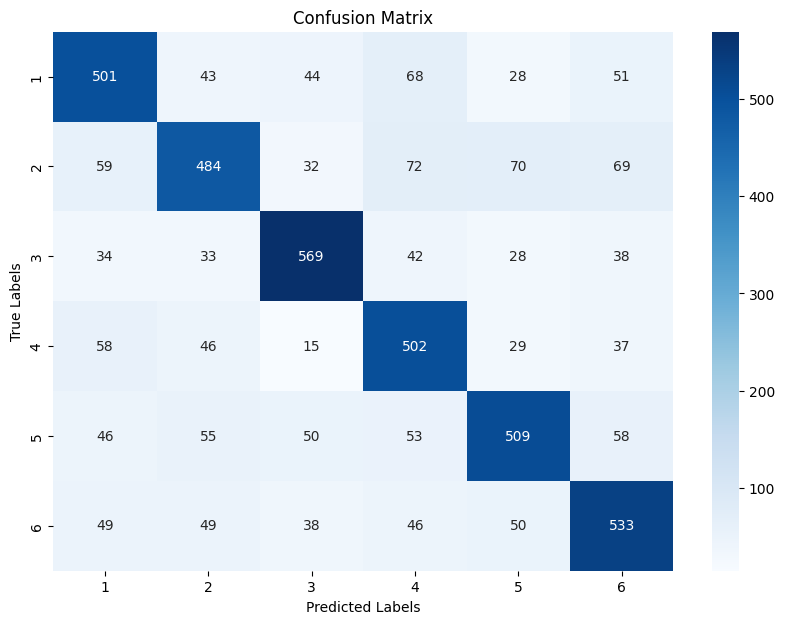

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3, 4, 5, 6], yticklabels=[1, 2, 3, 4, 5, 6])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [51]:
best_model_catboost = grid_search.best_estimator_

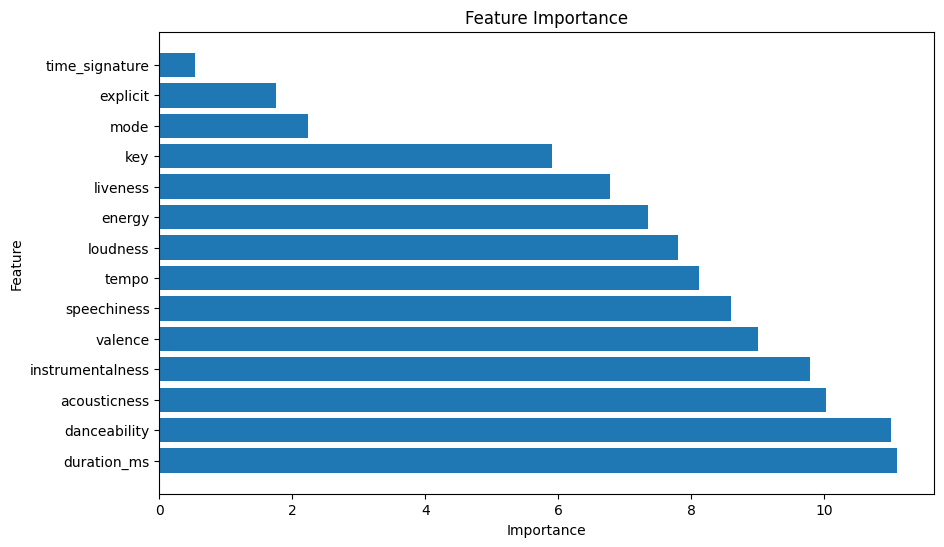

In [56]:
feature_importances = best_model_catboost.feature_importances_
feature_names = X_train.columns

importances = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

importances = importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Попробовал исключить time_signature и explicit, но результаты лучше не стали

In [15]:
# Сохраняем модельку Catboost
best_model_catboost = grid_search.best_estimator_
path = os.path.expanduser('catboost_model.joblib')
joblib.dump(best_model_catboost, path)

['catboost_model.joblib']

## XGBoost

In [19]:
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

In [20]:
param_grid = {
    'n_estimators': [1000, 1500, 2000],
    'learning_rate': [0.05, 0.1],
    'max_depth': [7, 8]
}

model = XGBClassifier(objective='multi:softmax', num_class=6, verbosity=1)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', error_score='raise')

grid.fit(X_train, y_train_adjusted)

best_params = grid.best_params_
best_score = grid.best_score_

print("Лучшие параметры:", best_params)
print("Лучшая точность:", best_score)

y_pred_adjusted = grid.predict(X_test)

accuracy = accuracy_score(y_test_adjusted, y_pred_adjusted)
print("Точность на тестовой выборке: {:.2f}%".format(accuracy * 100))

Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 2000}
Лучшая точность: 0.6603721033868092
Точность на тестовой выборке: 68.32%


Попробуем избавиться от выбросов и обучить еще раз

In [21]:
def remove_outliers(df, column, coef=1.5):
    Q1 = df[column].quantile(0.10)
    Q3 = df[column].quantile(0.90)
    IQR = Q3 - Q1
    lower_bound = Q1 - coef * IQR
    upper_bound = Q3 + coef * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

filtered_data = data.copy()
initial_row_count = len(filtered_data)

features = data.columns.drop('genre_track')

for feature in features:
    filtered_data = remove_outliers(filtered_data, feature)

final_row_count = len(filtered_data)
rows_removed = initial_row_count - final_row_count

print(f'Initial number of rows: {initial_row_count}')
print(f'Final number of rows after removing outliers: {final_row_count}')
print(f'Number of rows removed: {rows_removed}')

print(filtered_data.describe())

Initial number of rows: 22440
Final number of rows after removing outliers: 21375
Number of rows removed: 1065
        genre_track   duration_ms      explicit  danceability        energy  \
count  21375.000000  21375.000000  21375.000000  21375.000000  21375.000000   
mean       3.506620     -0.101128     -0.009353      0.037058      0.015463   
std        1.713159      0.443123      1.009368      0.987541      0.993084   
min        1.000000     -1.068513     -2.428631     -2.625366     -1.965990   
25%        2.000000     -0.377926      0.411755     -0.626263     -0.772835   
50%        3.000000     -0.150857      0.411755      0.127920      0.170023   
75%        5.000000      0.091644      0.411755      0.789123      0.896209   
max        6.000000      2.106418      0.411755      2.225171      1.419267   

                key      loudness          mode   speechiness  acousticness  \
count  21375.000000  21375.000000  21375.000000  21375.000000  21375.000000   
mean       0.001198

In [22]:
train_df, test_df = train_test_split(filtered_data, test_size=0.2, random_state=42)
X_train = train_df.drop('genre_track', axis=1)
y_train = train_df['genre_track']
X_test = test_df.drop('genre_track', axis=1)
y_test = test_df['genre_track']

In [23]:
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

In [24]:
param_grid = {
    'n_estimators': [1000, 1500, 2000],
    'learning_rate': [0.05, 0.1],
    'max_depth': [7, 8]
}

model = XGBClassifier(objective='multi:softmax', num_class=6, verbosity=1)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', error_score='raise')

grid.fit(X_train, y_train_adjusted)

best_params = grid.best_params_
best_score = grid.best_score_

print("Лучшие параметры:", best_params)
print("Лучшая точность:", best_score)

y_pred_adjusted = grid.predict(X_test)

accuracy = accuracy_score(y_test_adjusted, y_pred_adjusted)
print("Точность на тестовой выборке: {:.2f}%".format(accuracy * 100))

Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1000}
Лучшая точность: 0.6572514619883041
Точность на тестовой выборке: 67.37%


Результат лучше не стал, тоже самое было проделано с CatBoost, результат оказался тоже хуже

## LightBLM

In [28]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
X_train = train_df.drop('genre_track', axis=1)
y_train = train_df['genre_track']
X_test = test_df.drop('genre_track', axis=1)
y_test = test_df['genre_track']

In [29]:
param_grid = {
    'n_estimators': [1500, 2000],
    'learning_rate': [0.05, 0.1],
    'max_depth': [7, 8],
    'objective': ['multiclass'],
    'num_class': [6]
}

model = LGBMClassifier(verbose=1)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', error_score='raise', verbose=1)

grid.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Лучшие параметры:", best_params)
print("Лучшая точность:", best_score)

y_pred = grid_search.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Точность на тестовой выборке: {:.2f}%".format(accuracy * 100))

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

## SVM

In [67]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
X_train = train_df.drop('genre_track', axis=1)
y_train = train_df['genre_track']
X_test = test_df.drop('genre_track', axis=1)
y_test = test_df['genre_track']


svm = SVC(kernel='rbf')

parameters = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'decision_function_shape': ['ovo', 'ovr']
}

grid_search = GridSearchCV(svm, parameters, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# Оценка модели
print("Точность классификации:", accuracy_score(y_test, y_pred))
print("Отчет о классификации:\n", classification_report(y_test, y_pred))


Лучшие параметры: {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 0.1}
Точность классификации: 0.6087344028520499
Отчет о классификации:
               precision    recall  f1-score   support

           1       0.53      0.57      0.55       735
           2       0.57      0.51      0.54       786
           3       0.70      0.73      0.72       744
           4       0.58      0.64      0.61       687
           5       0.66      0.58      0.61       771
           6       0.61      0.64      0.63       765

    accuracy                           0.61      4488
   macro avg       0.61      0.61      0.61      4488
weighted avg       0.61      0.61      0.61      4488



Были попытки избавления от ненужных признаков, однако это приводило только к ухудшению точности модели.

Также было применено логарифмирование, однако результаты не стали и при таком подходе.

# Построение нейронной сети

In [60]:
data['genre_track'].value_counts()

genre_track
2    3854
5    3834
3    3796
6    3765
1    3681
4    3510
Name: count, dtype: int64

In [10]:
features = data.drop('genre_track', axis=1)
labels = data['genre_track'] - 1

X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

y_train_encoded = to_categorical(y_train, num_classes=6)
y_val_encoded = to_categorical(y_val, num_classes=6)
y_test_encoded = to_categorical(y_test, num_classes=6)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5', monitor='val_loss', save_best_only=True, mode='min'
)

history = model.fit(X_train, y_train_encoded, epochs=100, batch_size=16,  # уменьшено с 32 до 16
                    validation_data=(X_val, y_val_encoded),
                    callbacks=[early_stopping, model_checkpoint])

test_loss, test_acc = model.evaluate(X_test, y_test_encoded, verbose=2)
print('\nТочность на тестовых данных:', test_acc)



Epoch 1/100
1122/1122 [==============================] - 12s 5ms/step - loss: 1.6765 - accuracy: 0.3932 - val_loss: 1.2576 - val_accuracy: 0.5468
Epoch 2/100
  19/1122 [..............................] - ETA: 6s - loss: 1.4896 - accuracy: 0.4737

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1122/1122 [==============================] - 6s 5ms/step - loss: 1.3839 - accuracy: 0.4904 - val_loss: 1.2378 - val_accuracy: 0.5437
Epoch 3/100
1122/1122 [==============================] - 6s 5ms/step - loss: 1.3404 - accuracy: 0.5158 - val_loss: 1.2138 - val_accuracy: 0.5660
Epoch 4/100
1122/1122 [==============================] - 6s 5ms/step - loss: 1.3217 - accuracy: 0.5284 - val_loss: 1.2047 - val_accuracy: 0.5619
Epoch 5/100
1122/1122 [==============================] - 6s 5ms/step - loss: 1.3055 - accuracy: 0.5369 - val_loss: 1.1891 - val_accuracy: 0.5700
Epoch 6/100
1122/1122 [==============================] - 6s 5ms/step - loss: 1.2883 - accuracy: 0.5414 - val_loss: 1.1817 - val_accuracy: 0.5824
Epoch 7/100
1122/1122 [==============================] - 6s 5ms/step - loss: 1.2756 - accuracy: 0.5486 - val_loss: 1.1745 - val_accuracy: 0.5793
Epoch 8/100
1122/1122 [==============================] - 6s 5ms/step - loss: 1.2683 - accuracy: 0.5515 - val_loss: 1.1727 - val_accuracy: 0.58

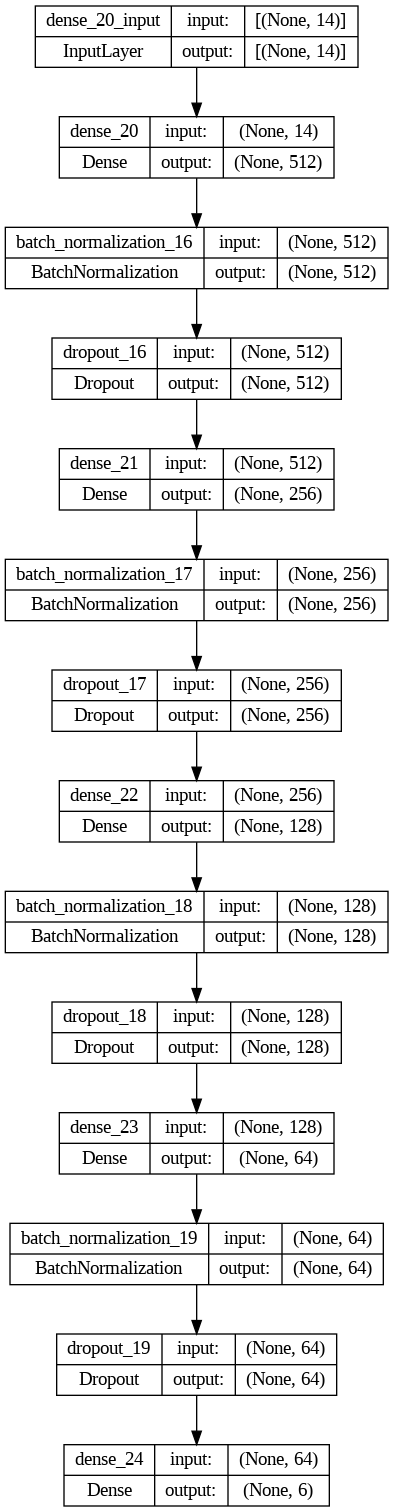

In [34]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Параметр early_stopping используется для предотвращения переобучения и сокращения времени обучения.

Нейронные сети хорошо подходят для работы с большими объемами данных и сложными взаимосвязями. Мой датасет относительно мал, поэтому CatBoost может справляться лучше, так как это градиентный бустинг над деревьями решений, который хорошо работает даже на небольших и менее сложных данных.

# Выводы

В ходе работы над задачей классификации жанров музыки по их числовым характеристикам, были применены различные методы машинного обучения, включая CatBoost, XGBoost, LightGBM, SVM и нейронные сети. Для повышения эффективности моделей, был выполнен ряд предварительных операций с данными, включая стандартизацию через StandardScaler, очистку от нерелевантных признаков и удаление выбросов. Эти шаги помогли сократить шум в данных и акцентировать внимание на значимых атрибутах, что критически важно для улучшения точности предсказаний. В бустингах - это повысило предсказание на 1-2%, в нейросетях и SVM это улучшило предсказание на 5-6%, что еще раз показывает устойивость бустингов к выбросам, шуму и масштабам признаков.

Из всех испытанных методов, наилучшие результаты показал **CatBoost**. Это подчеркивает его превосходную способность к работе с комплексными задачами и эффективность в обнаружении нелинейных зависимостей между признаками.